## Setup and read file

In [239]:
# import many things!
import os, errno
import numpy as np
import datetime as dt
import xarray as xr
import math
from scipy import stats, io
from scipy.interpolate import interp1d

import eofs
from eofs.xarray import Eof

import rhwhitepackages
from rhwhitepackages.readwrite import *
#from rhwhitepackages.readwrite import shiftlons, shiftlonlons
#from rhwhitepackages.stats import regressmaps
#from rhwhitepackages.readwrite import getdenfilename
from rhwhitepackages.plotting import drawmap, drawmap_sub

#from rhwhitepackages.regrid import *
from rhwhitepackages.SSWs import *
from rhwhitepackages.plotting import *
#from rhwhitepackages import CESMmanip
from rhwhitepackages.CESMmanip import *
#from rhwhitepackages import CESMconst
from rhwhitepackages import CESMdiag_Rose

# KDE
from scipy.stats import norm
import statsmodels.api as sm

# plotting
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as mpath
import matplotlib.ticker as mticker

import matplotlib
%matplotlib inline

# Mapping
import mpl_toolkits
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point

# default plot size
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})



In [2]:
# Define new colormap
cmap_def,cmap_wc,cmap_reds = get_colormaps()

In [250]:
# functions

# Reading
def readfiles(dir,filename):
                            
    atmfile = CESMdiag_Rose.compute_all_diagnostics(
                             xrOpen(dir + filename,
                             False),verbose=False)

    return(atmfile)  

def readseasons(Dir,exp,startyr,nyears,name,camname='cam'):
    #atmfields[exp]['annual'] = readfiles(Dir,'Annual' + str(startyr) + '_' + str(nyears) + '_mean_' + name + '.cam2.h0.nc')
    #toPlev(atmfields[exp]['annual'],plevs)

    for seas in ['DJF','MAM','JJA','SON']:
        try:
                atmfields[exp][seas] = readfiles(Dir,seas + str(startyr) + '_' + str(nyears) + 
                                                 '_mean_' + name + '.' + camname + '.h0.nc')
        except SystemExit:
            atmfields[exp][seas]=None    

    atmfields['p' + exp] = {}
            
    for seas in ['DJF','MAM','JJA','SON']:
        try:
            atmfields['p' + exp][seas] = xrOpen(Dir + '/' + seas + str(startyr) + '_' + str(nyears) + 
                                                  '_mean_Xpl_' + name + '.' + camname + '.h0.nc')
        except SystemExit:
            pass

# Plotting
def add_lon(toplot,coord):
    lon_idx = toplot.dims.index(coord)
    cyclic_data, cyclic_coord = add_cyclic_point(toplot.values,
                                                 coord=toplot.coords[coord],
                                                 axis=lon_idx)

    # Copy and add the cyclic coordinate and data
    new_coords = dict(toplot.coords)
    new_coords[coord] = cyclic_coord
    new_values = cyclic_data

    new_da = xr.DataArray(new_values, dims=toplot.dims, coords=new_coords)
    return(new_da)

def set_NPstereo(nrows,ncols,n):
    #proj = ccrs.Stereographic(central_latitude=90.0, central_longitude=0.0, 
    #                          false_easting=0.0, false_northing=0, 
    #                          true_scale_latitude=0, globe=None)
    proj=ccrs.NorthPolarStereo()

    ax = plt.subplot(ncols,nrows,n,projection=proj)

    ax.coastlines()

    ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())

     # Compute a circle in axes coordinates, which we can use as a boundary
     # for the map. We can pan/zoom as much as we like - the boundary will be
     # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

    gl = ax.gridlines(crs=ccrs.PlateCarree(),linewidth=1.5,linestyle = '--')
    gl.ylocator = mticker.FixedLocator([0,30,60])

    gl.xlocator = mticker.FixedLocator([0,30,60,90,120,150,180,210,240,270,300,330,360])
    ax.text(-2,17,'0',transform=ccrs.PlateCarree())
    ax.text(-36,11,'30W',transform=ccrs.PlateCarree())
    ax.text(-62,10,'60W',transform=ccrs.PlateCarree())
    ax.text(-89,10,'90W',transform=ccrs.PlateCarree())
    ax.text(-116,9,'120W',transform=ccrs.PlateCarree())
    ax.text(-140,12,'150W',transform=ccrs.PlateCarree())
    ax.text(-176,18,'180',transform=ccrs.PlateCarree())

    ax.text(30,17,'30E',transform=ccrs.PlateCarree())
    ax.text(60,18,'60E',transform=ccrs.PlateCarree())
    ax.text(88.8,19,'90E',transform=ccrs.PlateCarree())
    ax.text(120,19,'120E',transform=ccrs.PlateCarree())
    ax.text(150,19,'150E',transform=ccrs.PlateCarree())
    
    return(ax)

def plothist_error_comp(expdata,expdata_std,climdata,label,expdata2,expdata2_std,climdata2,
            label2,xmin,xmax,ymin,ymax,
            rotate=None,seas='DJF',colorin='r',pltctl=True,showlegend=True):
    
    # values to interpolate kde onto
    x = np.linspace(xmin, xmax, num=140, endpoint=True)
    style='-'
    linewidth=3
    
    if var =='jetlat':
        xlabel = 'jet latitude'
    elif var == 'jetspeed':
        xlabel = 'jet speed, m/s'
    
    kdemean = sm.nonparametric.KDEUnivariate(expdata)
    kdemean.fit()
    plotmean = kdemean.evaluate(x)
    
    kdemean2 = sm.nonparametric.KDEUnivariate(expdata2)
    kdemean2.fit()
    plotmean2 = kdemean2.evaluate(x)



    # Plot density distribution for  exp   
    color = colorin
    plt.plot(x,plotmean2,
            label = label2,linestyle='-',linewidth='4',color=color)

    plt.fill_between(x, plotmean2 + 1.96 * expdata2_std, plotmean2 - 1.96 * expdata2_std,
                     color=color,alpha = 0.4)
    

    latmax = getmaxlat(climdata2)
    plt.axvline(x=latmax,color=color,linewidth=2.0,linestyle='-')
    
    # Plot density distribution for  CTL
    if pltctl:
        color = 'k'
        plt.plot(x,plotmean,
                label = label,linestyle='--',linewidth='3',color=color)

        plt.fill_between(x, plotmean + 1.96 * expdata_std, plotmean - 1.96 * expdata_std,
                         color=color,alpha = 0.4)

        latmax = getmaxlat(climdata)
        plt.axvline(x=latmax,color=color,linewidth=2.0,linestyle='--')

        plt.xlim(xmin,xmax) 
        plt.ylim(ymin,ymax)

        if showlegend:
            plt.legend(loc='upper right',fontsize=14)

    return(n)

def plotSSWhist_paper(exp,jetdatain,DJFjetdatain,SSW_dates,SSW_dates_fake,basin,var,nrows,n,xmin,xmax,ymin,ymax,
             dayspre1,dayspre2,dayspost1,dayspost2,timestoplot=('pre','post'),extra=False,rotate=None,color='b'):
    
    nfakes =len(SSW_dates_fake[exp])
    # values to interpolate kde onto
    x = np.linspace(xmin, xmax, num=100, endpoint=True)
    style='-'
    linewidth=3
    
    if var =='jetlat':
        xlabel = 'jet latitude'
    elif var == 'jetspeed':
        xlabel = 'jet speed, m/s'

        
    pre,post = calchist_SSWs(jetdatain[exp][basin][var],dayspre1,dayspre2,dayspost1,dayspost2,
                               SSW_dates[exp])

    postmean = post.mean(axis=0)
    
    temp = np.sort(post)
    new = temp[0:np.where(np.isnan(temp))[0][0]]

    kde = sm.nonparametric.KDEUnivariate(new)
    kde.fit()
 

    # Get functions for statistical significance

    for fake in range(0,nfakes):

        pref,postf = calchist_SSWs(jetdatain[exp][basin][var],dayspre1,dayspre2,dayspost1,dayspost2,
                                   SSW_dates_fake[exp][fake])
        
        # if first time through, initialize
        if fake == 0: 
            fkde = {}
            fakemean = 0

        fkde[fake] = {}
        temp = np.sort(postf)
        new = temp[0:np.where(np.isnan(temp))[0][0]]

        kdetemp = sm.nonparametric.KDEUnivariate(new)
        kdetemp.fit()
        fkde[fake] = kdetemp.evaluate(x)
        fakemean += np.mean(fkde[fake])
        
    fakemean = fakemean/nfakes
    
    # plot for post SSW

    temp = np.array(fkde.values(),'float')
    fstd = np.nanstd(temp,axis=0)
    fmean = np.nanmean(temp,axis=0)  

    plt.subplot(nrows,2,n); n+=1
    ## plot density distribution for DJF

    KDEclim = sm.nonparametric.KDEUnivariate(DJFjetdatain[exp]['DJF'][var].values)
    KDEclim.fit()

    # Plot density distribution for pre-SSWs
    #plt.plot(kde.support,kde.density,
    #        label = str(dayspost1) + '-' + str(dayspost2) + ' days post SSW',linestyle=style,linewidth=linewidth,color=color)
    plt.plot(kde.support,kde.density,
            label = 'post SSW',linestyle=style,linewidth=linewidth,color=color)

    # Plot 2 standard deviations of distribution for pretend-pre-SSWs to check significance
    plt.plot(x,fmean,linewidth=linewidth,linestyle='--',color='k',label = r'$CTL_{SSW}$')
    plt.fill_between(x, fmean + 1.96 * fstd, fmean - 1.96 * fstd,color='k',alpha = 0.4)


    plt.plot([postmean,postmean],[ymin,ymax],color=color,linewidth=linewidth)
    CTLmean = DJFjetdatain[exp]['DJF'][var].mean().values
    plt.plot([CTLmean,CTLmean],[ymin,ymax],color='k',linewidth=linewidth)
    #plt.plot([fakemean[timep],fakemean[timep]],[ymin,ymax],color=color,linestyle='--')
    plt.xlim(xmin,xmax) 
    plt.ylim(ymin,ymax)
    #plt.ylabel(r'$relative$ $frequency$',fontsize=14)
    plt.legend(loc='upper right',fontsize=14)

    return(n)

def plot_map_diffs(CTL,explist,exptitles,nrows,n,seas,var,levels,cmap='RdBu_r',plev=-1,
                   xmin=-180,xmax=90,ymin=0,ymax=90,const=1.0,rZM=False,proj='PlateCarree',
                   ncols=2,letters = ['a.','b.','c.','d.','e.','f.'],unit=''):
    if var == 'Z3':
        vartitle = 'Z'
    else:
        vartitle = var
    if rZM:
        vartitle = vartitle + '\''
        
    for exp,expname in zip(explist,exptitles):
        if proj == 'NPStereo':
            proj=ccrs.NorthPolarStereo()
            ax = set_NPstereo(ncols,nrows,n)       
        elif proj == 'PlateCarree':
            proj = ccrs.PlateCarree()
            ax = plt.subplot(ncols,nrows,n,projection=proj)

        elif proj == 'Ortho':
            proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0, globe=None)
            ax = plt.subplot(ncols,nrows,n,projection=proj)

        if plev != -1:
            toplot = const * (atmfields['p' + CTL][seas][var].mean(dim='time').sel(lev_p = plev) - 
                  atmfields['p' + exp][seas][var].mean(dim='time').sel(lev_p = plev))
            title = vartitle + ' ' + str(plev) + 'mb, CTL - ' + expname
            PSmask = atmfields[CTL][seas].PS.mean(dim='time')
    
            toplot = xr.DataArray(np.where(PSmask.values < (plev+10)*100,np.nan,toplot),coords=[('lat',toplot.lat),('lon',toplot.lon)])

        else:
            toplot = const * (atmfields[CTL][seas][var].mean(dim='time') - 
                      atmfields[exp][seas][var].mean(dim='time'))
            title = vartitle + ' , CTL - ' + expname
            PHISmask = atmfields[CTL][seas].PHIS.mean(dim='time') - atmfields[exp][seas].PHIS.mean(dim='time')
            toplot2 = xr.DataArray(np.where(PHISmask.values > 100,np.nan,toplot),coords=[('lat',toplot.lat),('lon',toplot.lon)])
            if var == 'PS':
                toplot = toplot2 - (toplot2.mean(dim='lon'))
                title = vartitle + ' , CTL - ' + expname

            elif var =='PSL':
                toplot = xr.DataArray(toplot.values,coords=[('lat',toplot.lat),('lon',toplot.lon)]) - (toplot2.mean(dim='lon'))
                title = vartitle + ' , CTL - ' + expname
        if rZM:
            toplot = toplot - toplot.mean(dim='lon')
        
        # add cyclic point
        new_da = add_lon(toplot,coord='lon')
   
        #im = plt.contourf(new_da.lon,new_da.lat,new_da.values,
        #                  cmap=cmap,levels=levels,extend='both',transform=ccrs.PlateCarree())
            
        new_da.plot.contourf(ax=ax,cmap=cmap,levels=levels,extend='both',transform=ccrs.PlateCarree(),
                            cbar_kwargs={'label':r'$' + unit + '$','orientation':'horizontal',
                                         'fraction':0.04,'pad':0.04})
  
        #cbar_ax = fig.add_axes([0.55, 0.04, 0.31, 0.03])
        #cbar_ax.tick_params(labelsize=16) 
        #cb = fig.colorbar(im,cax=cbar_ax,orientation='horizontal')
        #cb.set_label(label = r'$' + unit + '$',fontsize=22)

        plt.title('')
        plt.text(0.2, 1.07, letters[n-1] + ' ' + title,
             horizontalalignment='center',
             fontsize=20,
             transform = ax.transAxes)
        
        if proj == 'PlateCarree':
            plt.ylabel('')
            plt.xlabel('')
            plt.ylim(ymin,ymax)
            plt.xlim(xmin,xmax)
        n+=1

# Analysis functions
def getmaxlat(indata):
    maxi = np.argmax(indata).values
    try:
        subset = indata.isel(latitude=slice(maxi-2,maxi+3))
        x = subset.latitude
        f = interp1d(x, subset,kind='cubic')
        xnew = np.linspace(subset.latitude[-1].values,subset.latitude[0].values,100)
    except ValueError:
        subset = indata.isel(lat=slice(maxi-2,maxi+3))
        x = subset.lat
        f = interp1d(x, subset,kind='cubic')
        xnew = np.linspace(subset.lat[-1].values,subset.lat[0].values,100)       
    ynew = f(xnew)
    latmax = xnew[np.argmax(ynew)]

    return(latmax)

## SSW functions:
def calchist_SSWs(invar,dayspre1,dayspre2,dayspost1,dayspost2,SSW_dates):
    nSSWs = len(SSW_dates)
    sort_SSW_dates = np.sort(SSW_dates)
    pre = invar.copy(deep=True)
    post = invar.copy(deep=True)
    pre.values[:] = np.NaN
    post.values[:] = np.NaN
    for iSSW in range(0,nSSWs-1):
        pre[sort_SSW_dates[iSSW]-dayspre1+1:sort_SSW_dates[iSSW]-dayspre2+1] = (
            invar.isel(time=slice(sort_SSW_dates[iSSW]-dayspre1+1,sort_SSW_dates[iSSW]-dayspre2+1)))
        post[sort_SSW_dates[iSSW]+dayspost1+1:sort_SSW_dates[iSSW]+dayspost2+1] = (
            invar.isel(time=slice(sort_SSW_dates[iSSW]+dayspost1+1,sort_SSW_dates[iSSW]+dayspost2+1)))

    return(pre,post)

# Monte Carlo Functions for error estimates
def MC_jetlats(datain,nyears,nMC):
    jetlats_MC = {}

    for n in range(0,nMC):
        jetlats_MC[n] = np.empty((datain.shape))
        jetlats_MC[n][:] = np.nan
        for iyear in range(0,nyears):
            MCyear = np.random.randint(0,nyears)
            jetlats_MC[n][iyear*90:(iyear+1)*90] = datain[MCyear*90:(MCyear+1)*90]
    return(jetlats_MC)

def get_MC(exp,dataset,xmin=15,xmax = 85,basin='Atl',var='jetlat'):
        
    datain = dataset[var]

    jetlats_MC = MC_jetlats(datain,nxyears[exp],nMC)

    # Get functions for statistical significance

    x = np.linspace(xmin, xmax, num=140, endpoint=True)

    MCkde = {}
    for iMC in range(0,nMC):

        MCkde[iMC] = {}
        temp = np.sort(jetlats_MC[iMC])
        try:
            new = temp[0:np.where(np.isnan(temp))[0][0]]
        except IndexError:
            new = temp

        kdetemp = sm.nonparametric.KDEUnivariate(new)
        kdetemp.fit()
        MCkde[iMC] = kdetemp.evaluate(x)


    # Put MCdata into an array so we can take means and standard deviation.
    temp = np.array(MCkde.values(),'float')
    kdeMCstd_temp = np.nanstd(temp,axis=0)
    kdeMCmean_temp = np.nanmean(temp,axis=0)

    new = True
    MCstd_DA = xr.DataArray(kdeMCstd_temp,coords = [('lat',x)])
    MCmean_DA = xr.DataArray(kdeMCmean_temp,coords = [('lat',x)])

    if new:
        DSstd = xr.Dataset({exp:MCstd_DA})
        DSmean = xr.Dataset({exp:MCmean_DA})
        new = False
    else:
        newstd = {exp: MCstd_DA}
        DSstd = DSstd.assign(**newstd)
        newmean = {exp: MCmean_DA}
        DSmean = DSmean.assign(**newmean)

    return(MCmean_DA,MCstd_DA,jetlats_MC)

## Tip jet functions
def calc_tipjets(argfile,argfilePSL,obs=False):
    # Select DJF
    if obs:
        dataseas = argfile.groupby('time.season')
        for iseas,data in dataseas:
            if iseas == 'DJF':
                DJF = data
        dataseas = argfilePSL.groupby('time.season')
        for iseas,data in dataseas:
            if iseas == 'DJF':
                DJF_PSL = data.msl   
    else:
        DJF = selectmonths(argfile,'DJF')
        try:
            DJF_PSL = selectmonths(argfilePSL['PSL'],'DJF')
        except KeyError:
            DJF_PSL = selectmonths(argfilePSL['PS'],'DJF')
            
    # Read data
    MSL = {}
    lats={}
    lons={}
    for point in ['0','a','b','c']:
        if obs:
            MSL[point] = (DJF_PSL.sel(latitude=points[point]['lat'],method='nearest')
                                  .sel(longitude=points[point]['lon'],method='nearest'))
            lats[point] = DJF_PSL.latitude.sel(latitude=points[point]['lat'],method='nearest')
            lons[point] = DJF_PSL.longitude.sel(longitude=points[point]['lon'],method='nearest')
        else:   
            MSL[point] = (DJF_PSL.sel(lat=points[point]['lat'],method='nearest')
                                      .sel(lon=points[point]['lon'],method='nearest'))
            lats[point] = DJF_PSL.lat.sel(lat=points[point]['lat'],method='nearest')
            lons[point] = DJF_PSL.lon.sel(lon=points[point]['lon'],method='nearest')

    if obs:
        Tlow = DJF['t2m'].sel(latitude=slice(62,57)).sel(longitude=slice(316,324))
        Ulow = DJF['u10'].sel(latitude=slice(62,57)).sel(longitude=slice(316,324))
        
    else:
        Tlow = DJF['T'].sel(lat=slice(57,62)).sel(lon=slice(316,324))
        Ulow = DJF['U'].sel(lat=slice(57,62)).sel(lon=slice(316,324))

    # Get timeseries of maximum U in the box, and 2m T at the location of maximum U

    if obs:
        stackedU = Ulow.stack(z=('latitude', 'longitude'))
        stackedT = Tlow.stack(z=('latitude', 'longitude'))    
    else:
        stackedU = Ulow.stack(z=('lat', 'lon'))
        stackedT = Tlow.stack(z=('lat', 'lon'))

    temp = stackedU.argmax(dim=('z'))
    temptimes = np.arange(len(temp))

    indices = [] 
    indices.append(temptimes)
    indices.append(temp.values)

    umax = stackedU.values[indices]
    T2max = stackedT.values[indices]

    # Get gradients of MSLP: need distance in km between the two points.
    from geopy.distance import great_circle
    dist0A = great_circle((lats['0'],lons['0']),(lats['a'],lons['a'])).m
    dist0B = great_circle((lats['0'],lons['0']),(lats['b'],lons['b'])).m
    dist0C = great_circle((lats['0'],lons['0']),(lats['c'],lons['c'])).m

    grad0A = (MSL['a'] - MSL['0'])/dist0A
    grad0B = (MSL['b'] - MSL['0'])/dist0B
    grad0C = (MSL['c'] - MSL['0'])/dist0C

    MSLgrad = (1.0/3.0) * (grad0A + grad0B + grad0C)

    # Create xarray of these values
    stacked = np.stack((umax,T2max,MSLgrad),axis=-1)

    da = xr.DataArray(stacked,dims=('time','var'))

    # Normalize data
    udata = umax - umax.mean()
    normU = np.linalg.norm(udata)
    normUdata = udata/normU

    Tdata = T2max - T2max.mean()
    normT = np.linalg.norm(Tdata)
    normTdata = Tdata/normT

    MSLdata = MSLgrad - MSLgrad.mean()
    normM = np.linalg.norm(MSLdata)
    normMSLdata = MSLdata/normM

    stackednorm = np.stack((normTdata,normUdata,normMSLdata),axis=-1)
    danorm = xr.DataArray(stackednorm,dims=('time','var'))

    #calculate EOFs of normalized data:
    solver = Eof(danorm)

    Norm_pcs = solver.pcs()
    Norm_eofs = solver.eofs()
    variance_fractions = solver.varianceFraction()
    reconstruction1 = solver.reconstructedField(1)
    reconstruction2 = solver.reconstructedField(2)
    reconstruction3 = solver.reconstructedField(3)

    eigenvalues = solver.eigenvalues()
    return(DJF,DJF_PSL,normU,umax,reconstruction1)

def plot_tip_comp(n,reconstruct,U,T,PSL,normU,umax_in,plot=False):
    indices = np.where(reconstruct[:,1]*normU + umax_in.mean() > n)

    Ucomp = U[indices].mean(dim='time')
    Tcomp = T[indices].mean(dim='time')
    SLPcomp = PSL[indices].mean(dim='time')

    Umean = U.mean(dim='time')
    Tmean = T.mean(dim='time')
    SLPmean = PSL.mean(dim='time')

    if plot:
        matplotlib.rcParams['figure.figsize']=(25,4)
        matplotlib.rcParams.update({'font.size':12})
        nrows = 1
        n=1
        ax = plt.subplot(nrows,3,n,projection=ccrs.PlateCarree()); n+=1
        drawmap_sub(ax)
        (Ucomp-Umean).plot.contourf(cmap='RdBu_r',levels=15,vmin=-16,vmax=16)
        ax.set_xticks((-60,-40,-20,0))
        ax.set_yticks((30,40,50,60,70))
        plt.xlabel('')
        plt.ylabel('')
        plt.title('Composite of anomalous 10m U during tip jet events')

        ax = plt.subplot(nrows,3,n,projection=ccrs.PlateCarree()); n+=1
        drawmap_sub(ax)
        (Tcomp - Tmean).plot.contourf(cmap='RdBu_r',levels=15,vmin=-6,vmax=6)
        ax.set_xticks((-60,-40,-20,0))
        ax.set_yticks((30,40,50,60,70))
        plt.xlabel('')
        plt.ylabel('')
        plt.title('Composite of anomalous 2m T during tip jet events')


        ax = plt.subplot(nrows,3,n,projection=ccrs.PlateCarree()); n+=1
        drawmap_sub(ax)
        (SLPcomp - SLPmean).plot.contourf(cmap='RdBu_r',levels=15,vmin=-2500,vmax=2500)
        ax.set_xticks((-60,-40,-20,0))
        ax.set_yticks((30,40,50,60,70))
        plt.xlabel('')
        plt.ylabel('')
        plt.title('Composite of anomalous SLP during tip jet events')

        plt.show()
    return(indices)

def print_tip_jets(argfile,argfilePSL,exp,threshold,plot=False):
    DJF_exp,DJF_PSL_exp,normU_exp,maxU_exp,reconstuct_exp = calc_tipjets(argfile,argfilePSL)

    # Plot surface condition composites for tip jet, max speed > 18m/s
    indices = plot_tip_comp(threshold,reconstuct_exp,DJF_exp['U'],DJF_exp['T'],
                            DJF_PSL_exp,normU_exp,maxU_exp,plot)
    
    nyears = len(DJF_exp.time)/90
    tipdays_ann = np.zeros(nyears,np.float)
    
    tipdays = DJF_exp.isel(time=indices[0])
    
    for iyear in range(0,nyears):
        tipdays_ann[iyear] = len(tipdays.sel(time=slice(365*(iyear+1),365*(iyear+2))).time)/90.0
        
    tipdays_mean = np.mean(tipdays_ann)
    tipdays_stderr = np.std(tipdays_ann)/np.sqrt(nyears)

    
    if plot:
        # Print number of tip jet events
        print(exp + '; U threshold: ' + str(threshold) + 'm/s')
        print(str(len(indices[0])) + ' events')
        #print('Event frequency: ' + str(float(len(indices[0]))/float(len(DJF_PSL_exp.time))))

        print('Event frequency: ' + str(tipdays_mean) + ' +/- ' + str(tipdays_stderr * 1.96))

    return(tipdays_mean,tipdays_stderr,indices)

def plot_Ucs_tip(indices,argfileUdaily):
    DJF_U850 = selectmonths(argfileUdaily,'DJF')

    U850_tip = DJF_U850.isel(time=indices[0])
    
    matplotlib.rcParams['figure.figsize']=(10,4)
    matplotlib.rcParams.update({'font.size':12})

    U850_tip.sel(lon=slice(300,360)).mean(dim='lon').mean(dim='time').U.plot(linewidth=2,color='b')
    plt.xlim(20,90)
    

def remove_tipdays(Udata,jetlats,indices):
        
    titles = {}
    titles[0] = 'Removing Tip jet days'

    ititle = 0
    nn=1
    dataseas = jetlats.groupby('time.season')
    for iseas,data in dataseas:
        if iseas == 'DJF':
                DJF_jetlats = data
                
    njetlat = len(DJF_jetlats)
    # in case we have more data for tip jets than for the jet latitude index
    maxindex= np.amin(np.argwhere(indices > njetlat))
    indicessub = indices[0:maxindex]
    
    #print the jetlatitude on days when there is a tip jet
    jetlatstip = DJF_jetlats.isel(time = indicessub)
    # remove tip jet days from the jetlats
    jetlatsnotip = DJF_jetlats.copy(deep=True)

    jetlatsnotip[indicessub] = np.nan
    
    plot_tip_notip(DJF_jetlats,jetlatstip,jetlatsnotip)
    plt.title('a.',loc='left')
    plt.title('')
    plt.xticks([20,30,40,50,60,70,80],['20N','30N','40N','50N','60N','70N','80N'])
    plt.xlim(20,85)
    plt.yticks([0,0.01,0.02,0.03,0.04,0.05])
    plt.ylabel('frequency')
    plt.legend(fontsize = 12,loc='best')

    
    
def plot_tip_notip(DJF_jetlats,jetlatstip,jetlatsnotip):
    Z = {}

    Z['all'] = sm.nonparametric.KDEUnivariate(DJF_jetlats.values)
    Z['all'].fit()

    Z['tip'] = sm.nonparametric.KDEUnivariate(jetlatstip.values)
    Z['tip'].fit()

    Z['notip'] = sm.nonparametric.KDEUnivariate(jetlatsnotip.values)
    Z['notip'].fit()  

    #matplotlib.rcParams['figure.figsize']=(15,nrows * 4)
    #matplotlib.rcParams.update({'font.size':18})
    n=1
    style='-'
    linewidth=2
    titles = {}
    titles['all'] = 'Jet latitude index for all DJF days'
    titles['tip'] = 'Jet latitude index for only tip jet days (DJF)'
    titles['notip'] = 'Jet latitude index excluding tip jet days (DJF)'
    colors = {}
    colors['all'] = 'k'
    colors['notip'] = 'deepskyblue'
    colors['tip'] = 'navy'
    
    styles = {}
    styles['all'] = '--'
    styles['notip'] = '-'
    styles['tip'] = '-'
    
    labels = {}
    labels['all'] = 'all days'
    labels['notip'] = 'non tip jet days'
    labels['tip'] = 'tip jet days (x 1/3)'

    
    const = {}
    const['all'] = 1.0
    const['notip'] = 1.0
    const['tip'] = 0.3333
    
    for exp in ['all','notip','tip']:
        plt.plot(Z[exp].support,const[exp] * Z[exp].density,label=labels[exp],
                 color=colors[exp],linestyle=styles[exp],linewidth=4)



In [6]:
# Define experiment titles
exptitles = {}
exptitles['pwaccm-ctl-extended'] = 'CTL'
exptitles['pwaccm-flat-extended'] = 'Flat'
exptitles['pwaccm-NoMT-extended'] = 'No_H'
exptitles['pwaccm-NoR-extended'] = 'No_R'
exptitles['pwaccm-NoG-extended'] = 'No_G'
exptitles['pwaccm-shiftG-extended'] = 'Shift_G'
exptitles['pwaccm-ctl-cesmssts'] = 'CESM SSTs'
exptitles['pcesm-topo'] = 'CAM4'

exptitles['waccm-ctl-extended'] = 'CTL'
exptitles['waccm-flat-extended'] = 'Flat'
exptitles['waccm-NoMT-extended'] = 'No_H'
exptitles['waccm-NoR-extended'] = 'No_R'
exptitles['waccm-NoG-extended'] = 'No_G'
exptitles['waccm-shiftG-extended'] = 'Shift_G'
exptitles['waccm-ctl-cesmssts'] = 'CESM SSTs'

exptitles['cesm-topo'] = 'CAM4'

#exptitles['CESMtopo'] = 'CAM4 CTL'

TJnames = {}
TJnames['waccm-ctl-extended'] = 'CTL'
TJnames['waccm-flat-extended'] = 'Flat'
TJnames['waccm-NoMT-extended'] = 'NoMT'
TJnames['waccm-NoR-extended'] = 'NoR'
TJnames['waccm-NoG-extended'] = 'NoG'
TJnames['waccm-shiftG-extended'] = 'ShiftGLND'
TJnames['waccm-ctl-cesmssts'] = 'CESMSSTs'
TJnames['cesm-topo'] = 'cesm-topo'


### Read data

In [251]:
## Read in WACCM and ERAI for climatological maps

atmfields={}

# Read seasonal means
exp = 'waccm-ctl-extended'
name='WACCMSC_CTL_122'
atmfields[exp] = {}
startyr=2
nyears=60

Dir='/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + name + '/atm/hist/'
readseasons(Dir,exp,startyr,nyears,name)

exp = 'waccm-varyAll-1980-2010'
name='WACCMSC_f19_1980-2010'
atmfields[exp] = {}
startyr=1980
nyears=30

Dir='/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + name + '/atm/hist/'
readseasons(Dir,exp,startyr,nyears,name)


exp = 'waccm-ctl-cesmssts'
name='WACCMSC_f19_2000_CESMSSTs'
atmfields[exp] = {}
startyr=2
nyears=60

Dir='/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + name + '/atm/hist/'
readseasons(Dir,exp,startyr,nyears,name)


exp = 'waccm-NoMT-extended'
name='WACCMSC_f19_NoMT'
atmfields[exp] = {}
startyr=2
nyears=60

Dir='/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + name + '/atm/hist/'
readseasons(Dir,exp,startyr,nyears,name)

exp = 'waccm-flat-extended'
name='WACCMSC_f19_Flat'
atmfields[exp] = {}
startyr=2
nyears=60

Dir='/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + name + '/atm/hist/'
readseasons(Dir,exp,startyr,nyears,name)

exp = 'waccm-NoR-extended'
name='WACCMSC_f19_NoR'
atmfields[exp] = {}
startyr=2
nyears=60

Dir='/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + name + '/atm/hist/'
readseasons(Dir,exp,startyr,nyears,name)

exp = 'waccm-NoG-extended'
name='WACCMSC_f19_NoG'
atmfields[exp] = {}
startyr=2
nyears=60

Dir='/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + name + '/atm/hist/'
readseasons(Dir,exp,startyr,nyears,name)

exp = 'waccm-shiftG-extended'
name='WACCMSC_f19_ShiftGLND'
atmfields[exp] = {}
startyr=2
nyears=60

Dir='/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + name + '/atm/hist/'
readseasons(Dir,exp,startyr,nyears,name)

exp = 'cesm-topo'
atmfields[exp] = {}
startyr=2
nyears=40

name='CESMtopof19_daily'

Dir='/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + name + '/atm/hist/'
readseasons(Dir,exp,startyr,nyears,name,camname='cam2')

exp='erai'
atmfields[exp] = {}
Dir = '/home/disk/eos4/rachel/Obs/ERAI/Processed/0.75deg/'
atmfields[exp]['DJF'] = xrOpen(Dir + 'DJF_clim_U_V_T_250_850_075deg_1979-2015.nc').u

ERAps = xrOpen(Dir + 'DJF_clim_Surf_0.75deg_1979-2015.nc').sp


# Get seasonal means over North Atlantic
avgDJFU = {}
exp = 'erai'
avgDJFU[exp] = atmfields[exp]['DJF'].sel(level = 850).sel(longitude=slice(300,360)).mean(dim='longitude')

for exp in ['waccm-ctl-extended','waccm-varyAll-1980-2010',
            'waccm-shiftG-extended','waccm-NoG-extended','waccm-flat-extended',
            'waccm-NoMT-extended','waccm-NoR-extended','cesm-topo']:
    avgDJFU[exp] = atmfields['p' + exp]['DJF'].U.sel(lev_p = 850).sel(lon=slice(300,360)).mean(dim='lon')


/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/CESMtopof19_daily/atm/hist/MAM2_40_mean_CESMtopof19_daily.cam2.h0.nc
/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/CESMtopof19_daily/atm/hist/JJA2_40_mean_CESMtopof19_daily.cam2.h0.nc
/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/CESMtopof19_daily/atm/hist/SON2_40_mean_CESMtopof19_daily.cam2.h0.nc
/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/CESMtopof19_daily/atm/hist//MAM2_40_mean_Xpl_CESMtopof19_daily.cam2.h0.nc
/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/CESMtopof19_daily/atm/hist//JJA2_40_mean_Xpl_CESMtopof19_daily.cam2.h0.nc
/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/CESMtopof19_daily/atm/hist//SON2_40_mean_Xpl_CESMtopof19_daily.cam2.h0.nc


In [91]:
# Read in matlab JLI data

exps = ['erai','waccm-ctl-extended','waccm-varyAll-1980-2010','waccm-cesmsst-extended',
        'waccm-shiftG-extended','waccm-NoG-extended','waccm-flat-extended',
        'waccm-NoMT-extended','waccm-NoR-extended','cesm-topo']

jetdata = {}

basins = ['Atl']
fileAtl={}
filePac={}

for exp in exps:
    fileAtl[exp] = io.loadmat('/home/disk/p/chilge//Research/mountains_project/data/' +
                              'jet850_atl_zmean_' + exp + '.mat')
    
# load different heights
fileAtl['erai_700'] = io.loadmat('/home/disk/p/chilge//Research/mountains_project/data/' +
                              'jet700_atl_zmean_erai.mat')
fileAtl['erai_500'] = io.loadmat('/home/disk/p/chilge//Research/mountains_project/data/' +
                              'jet500_atl_zmean_erai.mat') 
   
exps = exps + ['erai_700','erai_500']
    
def getdata(indict,filein,name,timesnew,tstart,tend,attrs,leap=False):
    # Create a dataset with values and times
    js = xr.DataArray(filein['jetspeed'][:][0][tstart:tend], dims=['time'],
                     coords={'time':('time',timesnew)})
    jl = xr.DataArray(filein['jetlat'][:][0][tstart:tend], dims=['time'], 
                      coords={'time':('time',timesnew)})
    
    if leap:
        # Leap years exist in the data and we will use the dates for subsetting
        indict[name] = xr.decode_cf(xr.Dataset({'jetspeed': (['time'],js),'jetlat': (['time'],jl)},
                               coords={'time': (['time'],timesnew,attrs)}))
    else:
        indict[name] = (xr.Dataset({'jetspeed': (['time'],js),'jetlat': (['time'],jl)},
                               coords={'time': (['time'],timesnew)}))
        
for exp in exps:
    jetdata[exp]={}
    times = np.array(fileAtl[exp]['time'][:])
    # for erai seasonal, start data is 1979, for other data, it's 1980
    attrs = {'units': 'days since 0001-01-01 00:00:00'}

    tstart = 0
    tend = len(times)
    
    if exp in ['erai','erai_700','erai_500']: 
        # For ERAI units are actually days since 0000-00-00, but python won't accept that as a date
        # So alter the times values to make them correct
        times = times-365
        
    if exp in ['waccm-varyAll-1980-2010']:
        # times need to be in days since 1980-01-01, i.e. the start date
        times = times - times[0]
        
    if exp in ['erai','erai_700','erai_500']: 
        leap=True
    else:
        leap=False

    timesnew = np.squeeze(times)

    if exp == 'waccm-ctl-extended':
        # select only the first 60 years
        tend = 365*60
        timesnew = np.squeeze(times[tstart:tend])
    
    getdata(jetdata[exp],fileAtl[exp],'Atl',timesnew,tstart,tend,attrs,leap=leap)
    

In [9]:
# Read in Lanczos Low Pass filtered matlab data

jetdataLPF = {}

basins = ['Atl']
fileAtl={}

# Lanczos filtered
expsLPF = ['erai','waccm-varyAll-1980-2010','waccm-shiftG-extended','waccm-NoG-extended','waccm-flat-extended',
            'waccm-cesmsst-extended','waccm-ctl-extended','waccm-NoMT-extended','waccm-NoR-extended']

for exp in expsLPF:
    fileAtl[exp] = io.loadmat('/home/disk/p/chilge//Research/mountains_project/data/' +
                              'jet850-lanczosFilt_atl_zmean_' + exp + '.mat')
    
def getdata(indict,filein,name,timesnew,tstart,tend,attrs,leap=False):
    # Create a dataset with values and times
    js = xr.DataArray(filein['jetspeed'][:][0][tstart:tend], dims=['time'],
                     coords={'time':('time',timesnew)})
    jl = xr.DataArray(filein['jetlat'][:][0][tstart:tend], dims=['time'], 
                      coords={'time':('time',timesnew)})
    
    if leap:
        # Leap years exist in the data and we will use the dates for subsetting
        indict[name] = xr.decode_cf(xr.Dataset({'jetspeed': (['time'],js),'jetlat': (['time'],jl)},
                               coords={'time': (['time'],timesnew,attrs)}))
    else:
        indict[name] = (xr.Dataset({'jetspeed': (['time'],js),'jetlat': (['time'],jl)},
                               coords={'time': (['time'],timesnew)}))
        
for exp in expsLPF:
    jetdataLPF[exp]={}
    times = np.array(fileAtl[exp]['time'][:])
    # for erai seasonal, start data is 1979, for other data, it's 1980
    attrs = {'units': 'days since 0001-01-01 00:00:00'}

    tstart = 0
    tend = len(times)
    
    if exp in ['erai','erai_700','erai_500']: 
        # For ERAI units are actually days since 0000-00-00, but python won't accept that as a date
        # So alter the times values to make them correct
        times = times-365
        
        
    if exp in ['erai','erai_700','erai_500']: 
        leap=True
    else:
        leap=False

    timesnew = np.squeeze(times)

    if exp == 'waccm-ctl-extended':
        # select only the first 60 years
        tend = 365*60
        timesnew = np.squeeze(times[tstart:tend])
    
    getdata(jetdataLPF[exp],fileAtl[exp],'Atl',timesnew,tstart,tend,attrs,leap=leap)
    

In [253]:
# Read CMIP climatological and JLI data
# Read in CMIP data

CMIPexps = ['ACCESS1-0','CanAM4','CMCC-CM','EC-EARTH','GFDL-CM3','GFDL-HIRAM-C180',
           'GFDL-HIRAM-C360','HadGEM2-A','IPSL-CM5A-MR','inmcm4','MIROC5','MIROC-ESM',
            'NorESM1-M']

startdates = {}
startdates['ACCESS1-0'] = '19790101'
startdates['CanAM4'] = '19790101'
startdates['CMCC-CM'] = '19790101'
startdates['EC-EARTH'] = '19790101'
startdates['GFDL-CM3'] = '19790101'
startdates['GFDL-HIRAM-C180'] = '19790101'
startdates['GFDL-HIRAM-C360'] = '19790101'
startdates['HadGEM2-A'] = '19780901'
startdates['IPSL-CM5A-MR'] = '19800101'
startdates['inmcm4'] = '19790101'
startdates['MIROC5'] = '19790101'
startdates['MIROC-ESM'] = '19790101'
startdates['NorESM1-M'] = '19790101'

enddates = {}
enddates['ACCESS1-0'] = '20081231'
enddates['CanAM4'] = '20091231'
enddates['CMCC-CM'] = '20081231'
enddates['EC-EARTH'] = '20081231'
enddates['GFDL-CM3'] = '20081231'
enddates['GFDL-HIRAM-C180'] = '20081231'
enddates['GFDL-HIRAM-C360'] = '20081231'
enddates['HadGEM2-A'] = '20081230'
enddates['IPSL-CM5A-MR'] = '20091231'
enddates['inmcm4'] = '20081231'
enddates['MIROC5'] = '20081231'
enddates['MIROC-ESM'] = '20081231'
enddates['NorESM1-M'] = '20081231'

# Read in times from raw files:
Dir = '/home/disk/eos4/rachel/CMIP/CMIP5/HIS/U_pl/'
rawU = {}
rawtimes={}

for exp in CMIPexps:
    print exp
    rawtimes[exp] = xrOpen(Dir + '/ua_day_' + exp + '_amip_r1i1p1_' + startdates[exp] + '-' + 
                         enddates[exp] + '.nc').time.values
    
# Read in seasonal climatologies
Dir = '/home/disk/eos4/rachel/CMIP/CMIP5/HIS/U_pl/seasmean/'
seasU = {}

for exp in CMIPexps:
    seasU[exp] = xrOpen(Dir + '/seas_clim_ua_' + exp + '_amip_r1i1p1_' + startdates[exp] + '-' + 
                         enddates[exp] + '.nc').ua.sel(plev=[85000])


# take average over the north atlantic region
for exp in CMIPexps:
    avgDJFU[exp] = seasU[exp].isel(time=0).sel(lon=slice(300,360)).mean(dim='lon')

    
# Read in matlab jet latitude data for CMIP experiments
nyears = 30

basins = ['Atl']
fileAtl={}
filePac={}

for exp in CMIPexps:
    fileAtl[exp] = io.loadmat('/home/disk/p/chilge//Research/mountains_project/data/jet850_atl_zmean_' + exp + '_HIS.mat')

def getdata(jetdata,filein,name,timesnew,tstart=0):
    # Create a dataset with values and times
    js = xr.DataArray(filein['jetspeed'][:][0][tstart:tend], dims=['time'], coords={'time':timesnew})
    jl = xr.DataArray(filein['jetlat'][:][0][tstart:tend], dims=['time'], coords={'time':timesnew})

    jetdata[name] = xr.Dataset({'jetspeed': (['time'],js),'jetlat': (['time'],jl)},coords={'time': (['time'],timesnew)})

for exp in CMIPexps:
    jetdata[exp]={}
    
    times = np.array(fileAtl[exp]['time'][:])
    if exp == 'erai': 
        # get rid of year 1979, as I don't have that in my data
        tstart = 364
        # run for 35 years, i.e. 1980-2014
        tend = len(times)#35*365 + tstart-1
        ntimes = times.shape[0]
        timesnew = np.arange(0,tend-tstart)
    else:
        tstart=0
        nyears = len(times)/365
        tend = len(times)#nyears*365
        timesnew = rawtimes[exp] #np.arange(0,tend-tstart)
    
    getdata(jetdata[exp],fileAtl[exp],'Atl',timesnew,tstart)

ACCESS1-0
CanAM4
CMCC-CM
EC-EARTH
GFDL-CM3
GFDL-HIRAM-C180
GFDL-HIRAM-C360
HadGEM2-A
IPSL-CM5A-MR
inmcm4
MIROC5
MIROC-ESM
NorESM1-M


In [255]:
# initialize dictionaries and read tip jet data
infiletip = {}
infilePS = {}

# Read in files
exp = 'CTL'
Dir = '/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/WACCMSC_CTL_122/atm/hist/'
infiletip[exp] = (xrOpen(Dir + 'Z3_U_T_lowest_hybrid_WACCMSC_CTL_122.cam.h2.0002-0061.nc',False)
                                            .sel(lat = slice(30,80)).sel(lon = slice(290,360))
                                            .sel(lev=992,method='nearest'))

infilePS[exp] = (xrOpen(Dir + 'PS_daily_WACCMSC_CTL_122.cam.h2.0002-0061.nc',False)
                                            .sel(lat = slice(30,80)).sel(lon = slice(290,360)))

for exp in ['NoR','NoMT','NoG','Flat','ShiftGLND']:
    # Read in file
    expname = 'WACCMSC_f19_' + exp
    Dir = '/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + expname + '/atm/hist/'
    infiletip[exp] = (xrOpen(Dir + 'Z3_U_T_lowest_hybrid_' + expname + '.cam.h2.0002-0061.nc',False)
                                                .sel(lat = slice(30,80)).sel(lon = slice(290,360))
                                                .sel(lev=992,method='nearest'))

    infilePS[exp] = (xrOpen(Dir + 'PS_daily_' + expname + '.cam.h2.0002-0061.nc',False)
                                                .sel(lat = slice(30,80)).sel(lon = slice(290,360)))
    
exp = 'CESMSSTs'
expname = 'WACCMSC_f19_2000_CESMSSTs'
Dir = '/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + expname + '/atm/hist/'
infiletip[exp] = (xrOpen(Dir + 'Z3_U_T_lowest_hybrid_' + expname + '.cam.h2.0002-0061.nc',False)
                                            .sel(lat = slice(30,80)).sel(lon = slice(290,360))
                                            .sel(lev=992,method='nearest'))

infilePS[exp] = (xrOpen(Dir + 'PS_daily_' + expname + '.cam.h2.0002-0061.nc',False)
                                            .sel(lat = slice(30,80)).sel(lon = slice(290,360)))

exp = 'cesm-topo'
expname = 'CESMtopof19_daily'
Dir = '/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + expname + '/atm/hist/'
infiletip[exp] = (xrOpen(Dir + 'Z3_U_T_lowest_hybrid_' + expname + '.cam.h2.0002-0051.nc',False)
                                            .sel(lat = slice(30,80)).sel(lon = slice(290,360))
                                            .sel(lev=992,method='nearest'))

infilePS[exp] = (xrOpen(Dir + 'PS_daily_' + expname + '.cam.h1.0002-0051.nc',False)
                                            .sel(lat = slice(30,80)).sel(lon = slice(290,360)))


Dir = '/home/disk/eos4/rachel/Obs/ERAI/Daily/'
infiletip['erai'] = (xrOpen(Dir + 'U10_T2_MSLP_daily_1979-2015.nc').sel(latitude = slice(80,30))
                                                            .sel(longitude = slice(290,360)))

In [147]:
## initialize dictionaries and read daily U data
dailyU = {}

# Read in files
exp = 'waccm-ctl-extended'
Dir = '/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/WACCMSC_CTL_122/atm/hist/'
dailyU[exp] = (xrOpen(Dir + 'U_plWACCMSC_CTL_122.cam.h2.0002-0101.nc',False).sel(lev_p = 850)).isel(time=slice(0,365*60))

# The JLI data are actually from the 1979-2010 run, starting in year 2
exp='waccm-varyAll-1980-2010'
Dir = '/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/WACCMSC_f19_1979-2010/atm/hist/'
dailyU[exp] = (xrOpen(Dir + 'U_plWACCMSC_f19_1979-2010.cam.h2.1980-2009.nc',False).sel(lev_p = 850))

# Read in files
exp = 'cesm-topo'
expname = 'CESMtopof19_daily'

Dir = '/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/' + expname + '/atm/hist/'
dailyU[exp] = (xrOpen(Dir + 'U_pl' + expname + '.cam.h2.0002-0051.nc',False).sel(lev_p = 850))


# At 850mb for JLI
Dir = '/home/disk/eos4/rachel/Obs/ERAI/Daily/'
dailyU['erai'] = xrOpen(Dir + '/ERAI_U850_daily_1980-2015.nc').u


In [823]:
## Read in daily data at 10mb for SSWs
# initialize
U60_10 = {}

exp = 'waccm-ctl-extended'
Dir = '/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/WACCMSC_CTL_122/atm/hist/'
WACCM_U = xrOpen(Dir + '/U_plWACCMSC_CTL_122.cam.h2.0002-0101.nc',False).U.sel(lev_p=[10,250,850])

# Select only the first 60 years of the extended run
U60_10[exp] = WACCM_U.sel(lev_p=10).mean(dim='lon').sel(lat=60,method='nearest').sel(time=slice(0,60*365))


ERAI_file = xrOpen('/home/disk/eos4/rachel/Obs/ERAI/Daily/' + 'ERAI_U10mb_daily_1980-2015.nc')
U60_10['erai'] = ERAI_file.u.sel(latitude=60,method='nearest').mean(dim='longitude').sel(time=slice('1980','2009'))


## Process data

In [254]:
# Split by seasons
JLI_seas = {}
JLI_LPF_seas = {}

basin = 'Atl'

for exp in exps:
    JLI_seas[exp] = {}
    
    for iseas in ['DJF','MAM','JJA','SON']:
        JLI_seas[exp][iseas] = {}
        
    for var in ('jetspeed','jetlat'):
        if exp in ['erai','erai_700','erai_500']:
            # Use groupby in seasons as leap years exist
            seasdata = jetdata[exp][basin][var].groupby('time.season')
            for iseas,data in seasdata:
                JLI_seas[exp][iseas][var] = data

        else: 
            # No leap years
            for iseas in ['DJF','MAM','JJA','SON']:
                JLI_seas[exp][iseas][var] = selectmonths(jetdata[exp][basin][var],iseas)

for exp in expsLPF:
    JLI_LPF_seas[exp] = {}
    
    for iseas in ['DJF','MAM','JJA','SON']:
        JLI_LPF_seas[exp][iseas] = {}
        
    for var in ('jetspeed','jetlat'):
        if exp in ['erai','erai_700','erai_500']:
            # LPF version
            seasdata = jetdataLPF[exp][basin][var].groupby('time.season')
            for iseas,data in seasdata:
                JLI_LPF_seas[exp][iseas][var] = data
        else: 
            # No leap years
            for iseas in ['DJF','MAM','JJA','SON']:
                JLI_LPF_seas[exp][iseas][var] = selectmonths(jetdataLPF[exp][basin][var],iseas)
                  
for exp in CMIPexps:
    JLI_seas[exp] = {}

    for iseas in ['DJF','MAM','JJA','SON']:
        JLI_seas[exp][iseas] = {}

    basin = 'Atl'
    var = 'jetlat'
    temp = jetdata[exp][basin][var].groupby('time.season')
    for iseas,data in temp:
        JLI_seas[exp][iseas][var] = data             

In [148]:
# Split daily data by seasons
dailyU_seas = {}
for exp in ['erai','waccm-varyAll-1980-2010','waccm-ctl-extended']:
    dailyU_seas[exp] = {}
    
    for iseas in ['DJF','MAM','JJA','SON']:
        dailyU_seas[exp][iseas] = {}
        
    if exp in ['erai','erai_700','erai_500']:
        # Use groupby in seasons as leap years exist
        seasdata = dailyU[exp].groupby('time.season')
        for iseas,data in seasdata:
            dailyU_seas[exp][iseas] = data

    else: 
        # No leap years
        for iseas in ['DJF','MAM','JJA','SON']:
            dailyU_seas[exp][iseas] = selectmonths(dailyU[exp],iseas)


In [826]:
# Identify SSWs
#nyearsERA = U60_10['erai'].shape[0]/365.0
#nyearsW = U60_10['waccm-varyAll-1980-2010'].shape[0]/365.0

SSW_dates = {}
for exp in ['waccm-ctl-extended']:
    SSW_dates[exp] = np.array(findSSWs(U60_10[exp],10,Obs=False))
    ## Subtract 365 to get indices in correct form. Now must always use isel, not sel
    SSW_dates[exp] = SSW_dates[exp] - int(U60_10[exp].time[0].values)

    
# ERAI SSWs
SSW_dates['erai'] = np.array(findSSWs(U60_10['erai'],10,Obs=True,startyr=1980))


mean: 0.440677966102 ; s.e.: 0.07681982128
mean: 0.6 ; s.e.: 0.111554670205


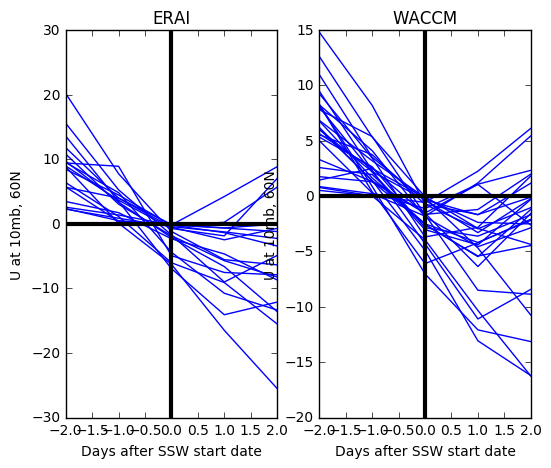

In [830]:
# Check timing is correct for SSWS:
matplotlib.rcParams['figure.figsize']=(12,5)
matplotlib.rcParams.update({'font.size':10})

plt.subplot(1,2,1)
for istart in SSW_dates['erai']:
    plt.plot(np.arange(-2,3),U60_10['erai'].isel(time=slice(istart-2,istart+3)).values,
             color='b')
plt.axhline(0,color='k',linewidth=3)
plt.axvline(0,color='k',linewidth=3)
plt.ylabel('U at 10mb, 60N')
plt.xlabel('Days after SSW start date')
plt.title('ERAI')

plt.subplot(1,2,2)
for istart in SSW_dates['waccm-ctl-extended']:
    plt.plot(np.arange(-2,3),U60_10['waccm-ctl-extended'].isel(time=slice(istart-2,istart+3)).values,
             color='b')
plt.axhline(0,color='k',linewidth=3)
plt.axvline(0,color='k',linewidth=3)
plt.ylabel('U at 10mb, 60N')
plt.xlabel('Days after SSW start date')
plt.title('WACCM')
plt.show()

### Bootstrap re-sampling

In [48]:
# Set number of years in sample
nxyears = {}
nxyears['erai'] = 30
nxyears['waccm-ctl-extended'] = 60
nxyears['waccm-varyAll-1980-2010'] = 30
nxyears['waccm-flat-extended'] = 60
nxyears['waccm-shiftG-extended'] = 60
nxyears['waccm-NoG-extended'] = 60
nxyears['waccm-NoMT-extended'] = 60
nxyears['waccm-NoR-extended'] = 60
nxyears['waccm-cesmsst-extended'] = 60
nxyears['waccm-ctl_250'] = 50
nxyears['waccm-ctl_500'] = 50
nxyears['erai_250'] = 34
nxyears['erai_500'] = 30
nxyears['erai_700'] = 30
nxyears['cesm-topo'] = 50


In [49]:
# Initialize dictionaries
kdeMCstd = {}
kdeMCmean = {}
kdeMCstd_LPF = {}
kdeMCmean_LPF = {}
jetlats_BS = {}
jetlats_LPF_BS = {}

for iseas in ['DJF','MAM','JJA','SON']:
    kdeMCstd[iseas] = {}
    kdeMCmean[iseas] = {}
    kdeMCstd_LPF[iseas] = {}
    kdeMCmean_LPF[iseas] = {}
    jetlats_BS[iseas] = {}
    jetlats_LPF_BS[iseas] = {}
    



In [108]:
# MC simulations on standard data
nMC = 1000

iseas = 'DJF'
kdeMCstd[iseas][nMC] = {}
kdeMCmean[iseas][nMC] = {}
kdeMCstd_LPF[iseas][nMC] = {}
kdeMCmean_LPF[iseas][nMC] = {}
jetlats_BS[iseas][nMC]  = {}
jetlats_LPF_BS[iseas][nMC]  = {}

for exp in ['erai','waccm-varyAll-1980-2010','waccm-ctl-extended']:
    print(exp)
    kdeMCmean[iseas][nMC][exp],kdeMCstd[iseas][nMC][exp],jetlats_BS[iseas][exp] = get_MC(exp,JLI_seas[exp][iseas])
    

erai
waccm-varyAll-1980-2010
waccm-ctl-extended


In [40]:
# MC simulations on standard data
nMC = 1000

iseas = 'DJF'
kdeMCstd[iseas][nMC] = {}
kdeMCmean[iseas][nMC] = {}
kdeMCstd_LPF[iseas][nMC] = {}
kdeMCmean_LPF[iseas][nMC] = {}
jetlats_BS[iseas][nMC]  = {}
jetlats_LPF_BS[iseas][nMC]  = {}

for exp in ['erai','erai_700','erai_500','waccm-ctl-extended','waccm-varyAll-1980-2010',
            'waccm-cesmsst-extended','waccm-shiftG-extended','waccm-NoG-extended','waccm-flat-extended',
            'waccm-NoMT-extended','waccm-NoR-extended','cesm-topo']:
    print(exp)
    kdeMCmean[iseas][nMC][exp],kdeMCstd[iseas][nMC][exp],jetlats_BS[iseas][exp] = get_MC(exp,JLI_seas[exp][iseas])
    

erai
erai_700
erai_500
waccm-ctl-extended
waccm-cesmsst-extended
waccm-shiftG-extended
waccm-NoG-extended
waccm-flat-extended
waccm-NoMT-extended
waccm-NoR-extended
cesm-topo


In [107]:
# MC simulations on LPF data
nMC = 1000

iseas = 'DJF'
kdeMCstd_LPF[iseas][nMC] = {}
kdeMCmean_LPF[iseas][nMC] = {}
jetlats_LPF_BS[iseas][nMC]  = {}

for exp in ['erai','waccm-varyAll-1980-2010','waccm-ctl-extended']:
    print(exp)
    kdeMCmean_LPF[iseas][nMC][exp],kdeMCstd_LPF[iseas][nMC][exp],jetlats_LPF_BS[iseas][exp] = get_MC(
                                                                            exp,JLI_LPF_seas[exp][iseas])
    

erai
waccm-varyAll-1980-2010
waccm-ctl-extended


In [41]:
# MC simulations on LPF data
nMC = 1000

iseas = 'DJF'
kdeMCstd_LPF[iseas][nMC] = {}
kdeMCmean_LPF[iseas][nMC] = {}
jetlats_LPF_BS[iseas][nMC]  = {}

for exp in ['erai','waccm-ctl-extended','waccm-varyAll-1980-2010',
            'waccm-shiftG-extended','waccm-NoG-extended','waccm-flat-extended',
            'waccm-NoMT-extended']:
    print(exp)
    kdeMCmean_LPF[iseas][nMC][exp],kdeMCstd_LPF[iseas][nMC][exp],jetlats_LPF_BS[iseas][exp] = get_MC(
                                                                            exp,JLI_LPF_seas[exp][iseas])
    

erai
waccm-ctl-extended
waccm-shiftG-extended
waccm-NoG-extended
waccm-flat-extended
waccm-NoMT-extended


In [831]:
# Bootstrap resampling for SSWs, keeping SSW dates (non-deseasonalized data)
nfakes = 1000
SSW_dates_fake = {}

for exp in ['erai','waccm-ctl-extended']:
    print exp
    SSW_dates_fake[exp] = {}
    if exp in ['erai']:
        nyears = 31
    elif exp == 'waccm-ctl-extended':
        nyears = 60
    else:
        sys.exit('incorrect exp' + str(exp))
      
    nSSWs = len(SSW_dates[exp])
    SSW_days= SSW_dates[exp] % 365
    baseyears = np.arange(0,365*nyears,365)

    for n in range(0,nfakes):
        # pick nSSWs random years with replacement
        years = np.random.randint(0,nyears-1,[nSSWs])
        baseyears = years * 365
        
        #pick nSSWs from SSW_days, with replacement
        dayind = np.random.randint(0,nSSWs,[nSSWs])
    
        shuf_SSW_days = SSW_days[dayind]

        SSW_dates_fake[exp][n] = baseyears[0:nSSWs] + shuf_SSW_days
    


erai
waccm-ctl-extended


### Tip jet Analysis

In [ ]:
# Define points - based on Vage et al. 2009
points = {}
points['0'] = {}
points['0']['lat'] = 62.0
points['0']['lon'] = 320.0

points['a'] = {}
points['a']['lat'] = 60.0
points['a']['lon'] = 313.0

points['b'] = {}
points['b']['lat'] = 58.0
points['b']['lon'] = 316.0

points['c'] = {}
points['c']['lat'] = 56.0
points['c']['lon'] = 320.0

In [817]:
# Calculate frequency of tip jets, ERA-I and WACCM
TJ_freq_mean = {}
TJ_freq_stderr = {}
TJindices = {}

for Uthresh in [16,18,20,22]:
    TJ_freq_mean[Uthresh] = {}
    TJ_freq_stderr[Uthresh] = {}
    TJindices[Uthresh] = {}
    
    for iexp in ['CTL','Flat','NoMT','NoR','NoG','ShiftGLND','cesm-topo','CESMSSTs']:
        TJ_freq_mean[Uthresh][iexp],TJ_freq_stderr[Uthresh][iexp],TJindices[Uthresh][iexp] = print_tip_jets(
            infiletip[iexp],infilePS[iexp],iexp,Uthresh,plot=False)
        
    # Calculate frequency of tip jets for ERA-Interim. This uses slightly different data (10m U and 2m T) and
    # so we don't expect the mean frequency to match WACCM.
    iexp = 'erai'
    Estartyr = 1980 # because daily data starts in 1980
    Eendyr = 2015
    DJF_exp,DJF_PSL_exp,normU_exp,maxU_exp,reconstuct_exp = calc_tipjets(
        infiletip[iexp].sel(time=slice(str(Estartyr),str(Eendyr))),
        infiletip[iexp].sel(time=slice(str(Estartyr),str(Eendyr))),
        obs=True)
    
    plot=False
    indices = plot_tip_comp(Uthresh,reconstuct_exp,DJF_exp['u10'],DJF_exp['t2m'],
                                DJF_PSL_exp,normU_exp,maxU_exp,plot)

    nyears = len(DJF_exp.time)/90
    tipdays_ann = np.zeros(nyears,np.float)

    tipdays = DJF_exp.isel(time=indices[0])

    for iyear in np.arange(Estartyr,Eendyr+1):
        tipdays_ann[iyear-Estartyr] = len(tipdays.sel(time=slice(str(iyear),str(iyear))).time)/90.0

    tipdays_mean = np.mean(tipdays_ann)
    tipdays_stderr = np.std(tipdays_ann)/np.sqrt(nyears)
    
    TJ_freq_mean[Uthresh][iexp] = tipdays_mean
    TJ_freq_stderr[Uthresh][iexp] = tipdays_stderr
    TJindices[Uthresh][iexp] = indices
    

In [967]:
for Uthresh in [16,18,20,22]:      
    # Calculate frequency of tip jets for ERA-Interim. This uses slightly different data (10m U and 2m T) and
    # so we don't expect the mean frequency to match WACCM.
    iexp = 'erai'
    Estartyr = 1980 # because daily data starts in 1980
    Eendyr = 2015
    DJF_exp,DJF_PSL_exp,normU_exp,maxU_exp,reconstuct_exp = calc_tipjets(
        infiletip[iexp].sel(time=slice(str(Estartyr),str(Eendyr))),
        infiletip[iexp].sel(time=slice(str(Estartyr),str(Eendyr))),
        obs=True)
    
    plot=False
    indices = plot_tip_comp(Uthresh,reconstuct_exp,DJF_exp['u10'],DJF_exp['t2m'],
                                DJF_PSL_exp,normU_exp,maxU_exp,plot)

    nyears = len(DJF_exp.time)/90
    tipdays_ann = np.zeros(nyears,np.float)

    tipdays = DJF_exp.isel(time=indices[0])

    for iyear in np.arange(Estartyr,Eendyr+1):
        tipdays_ann[iyear-Estartyr] = len(tipdays.sel(time=slice(str(iyear),str(iyear))).time)/90.0

    tipdays_mean = np.mean(tipdays_ann)
    tipdays_stderr = np.std(tipdays_ann)/np.sqrt(nyears)
    
    TJ_freq_mean[Uthresh][iexp] = tipdays_mean
    TJ_freq_stderr[Uthresh][iexp] = tipdays_stderr
    TJindices[Uthresh][iexp] = indices
    

In [977]:
# Print mean tip jet frequency and standard error on the mean.
iexp = 'erai'
Uthresh = 16
print(90 * TJ_freq_mean[Uthresh][iexp])
print(90 * TJ_freq_stderr[Uthresh][iexp])


iexp = 'CTL'
Uthresh = 16
print(90 * TJ_freq_mean[Uthresh][iexp])
print(90 * TJ_freq_stderr[Uthresh][iexp])

iexp = 'cesm-topo'
Uthresh = 16
print(90 * TJ_freq_mean[Uthresh][iexp])
print(90 * TJ_freq_stderr[Uthresh][iexp])

12.6111111111
1.11891549247
16.4166666667
0.839739267295
15.28
1.01431356099


In [981]:
# Calculate fraction of tip jet days that will be northern peak days: Uthresh=16
npeak_lat1 = 53
npeak_lat2 = 61

otherpeak_lat1 = 30
otherpeak_lat2 = 85

thresh = 16

exp = 'CTL'
exp2= 'CTL'

argfileUdaily = dailyU[exp2].sel(time=slice(365,365*61))
indices = TJindices[thresh][exp]

DJF_U850 = selectmonths(argfileUdaily,'DJF')

U850_tip = DJF_U850.U.isel(time=indices[0]).sel(lon=slice(300,360)).mean(dim='lon')

#Central peak:
U850_central_tip = U850_tip.sel(lat=slice(otherpeak_lat1,otherpeak_lat2)).max(dim='lat')
U850_north_tip = U850_tip.sel(lat=slice(npeak_lat1,npeak_lat2)).max(dim='lat')

U850_diffs = U850_north_tip - U850_central_tip

U850_diffs[...] = np.where(U850_diffs.values >= 0, 1,0)

nyears = len(DJF_U850.time)/90

nU850_diff_pos_ann = np.zeros(nyears,np.float)
for iyear in range(0,nyears):
    ntips_ann = len(U850_tip.sel(time=slice(365*(iyear+1),365*(iyear+2))).time)
    if ntips_ann > 0:
        nU850_diff_pos_ann[iyear] = (float(np.sum(U850_diffs.sel(time=slice(365*(iyear+1),365*(iyear+2)))))
                                     /float(ntips_ann))
    else:
        nU850_diff_pos_ann[iyear] = np.nan
        
nfrac_mean = np.nanmean(nU850_diff_pos_ann)
nfrac_stderr = np.nanstd(nU850_diff_pos_ann)/np.sqrt(nyears)


ntips = len(U850_diffs.time)
frac_northern = float(np.sum(U850_diff_pos))/float(ntips)
print(exp)
print(str(nfrac_mean) + ' +/- ' + str(nfrac_stderr) + ' of tip jet days will be northern peak days')


# Number of tip jet events when max wind between 42-47N exceeds max wind between 55-62N
exp = 'cesm-topo'
exp2= 'cesm-topo'

argfileUdaily = dailyU[exp2].sel(time=slice(365,365*61))
indices = TJindices[thresh][exp]

DJF_U850 = selectmonths(argfileUdaily,'DJF')

U850_tip = DJF_U850.U.isel(time=indices[0]).sel(lon=slice(300,360)).mean(dim='lon')

#Central peak:
U850_central_tip = U850_tip.sel(lat=slice(otherpeak_lat1,otherpeak_lat2)).max(dim='lat')
U850_north_tip = U850_tip.sel(lat=slice(npeak_lat1,npeak_lat2)).max(dim='lat')

U850_diffs = U850_north_tip - U850_central_tip

U850_diffs[...] = np.where(U850_diffs.values >= 0, 1,0)

nyears = len(DJF_U850.time)/90

nU850_diff_pos_ann = np.zeros(nyears,np.float)
for iyear in range(0,nyears):
    ntips_ann = len(U850_tip.sel(time=slice(365*(iyear+1),365*(iyear+2))).time)
    if ntips_ann > 0:
        nU850_diff_pos_ann[iyear] = (float(np.sum(U850_diffs.sel(time=slice(365*(iyear+1),365*(iyear+2)))))
                                     /float(ntips_ann))
    else:
        nU850_diff_pos_ann[iyear] = np.nan
        
nfrac_mean = np.nanmean(nU850_diff_pos_ann)
nfrac_stderr = np.nanstd(nU850_diff_pos_ann)/np.sqrt(nyears)


ntips = len(U850_diffs.time)
frac_northern = float(np.sum(U850_diff_pos))/float(ntips)
print(exp)
print(str(nfrac_mean) + ' +/- ' + str(nfrac_stderr) + ' of tip jet days will be northern peak days')


CTL
0.708732811899 +/- 0.0208049696811 of tip jet days will be northern peak days
cesm-topo
0.533537703565 +/- 0.02178500005 of tip jet days will be northern peak days


In [982]:
# Calculate fraction of tip jet days that will be northern peak days: Uthresh=18
npeak_lat1 = 53
npeak_lat2 = 61

otherpeak_lat1 = 30
otherpeak_lat2 = 85

thresh = 18

exp = 'CTL'
exp2= 'CTL'

argfileUdaily = dailyU[exp2].sel(time=slice(365,365*61))
indices = TJindices[thresh][exp]

DJF_U850 = selectmonths(argfileUdaily,'DJF')

U850_tip = DJF_U850.U.isel(time=indices[0]).sel(lon=slice(300,360)).mean(dim='lon')

#Central peak:
U850_central_tip = U850_tip.sel(lat=slice(otherpeak_lat1,otherpeak_lat2)).max(dim='lat')
U850_north_tip = U850_tip.sel(lat=slice(npeak_lat1,npeak_lat2)).max(dim='lat')

U850_diffs = U850_north_tip - U850_central_tip

U850_diffs[...] = np.where(U850_diffs.values >= 0, 1,0)

nyears = len(DJF_U850.time)/90

nU850_diff_pos_ann = np.zeros(nyears,np.float)
for iyear in range(0,nyears):
    ntips_ann = len(U850_tip.sel(time=slice(365*(iyear+1),365*(iyear+2))).time)
    if ntips_ann > 0:
        nU850_diff_pos_ann[iyear] = (float(np.sum(U850_diffs.sel(time=slice(365*(iyear+1),365*(iyear+2)))))
                                     /float(ntips_ann))
    else:
        nU850_diff_pos_ann[iyear] = np.nan
        
nfrac_mean = np.nanmean(nU850_diff_pos_ann)
nfrac_stderr = np.nanstd(nU850_diff_pos_ann)/np.sqrt(nyears)


ntips = len(U850_diffs.time)
frac_northern = float(np.sum(U850_diff_pos))/float(ntips)
print(exp)
print(str(nfrac_mean) + ' +/- ' + str(nfrac_stderr) + ' of tip jet days will be northern peak days')


# Number of tip jet events when max wind between 42-47N exceeds max wind between 55-62N
exp = 'cesm-topo'
exp2= 'cesm-topo'

argfileUdaily = dailyU[exp2].sel(time=slice(365,365*61))
indices = TJindices[thresh][exp]

DJF_U850 = selectmonths(argfileUdaily,'DJF')

U850_tip = DJF_U850.U.isel(time=indices[0]).sel(lon=slice(300,360)).mean(dim='lon')

#Central peak:
U850_central_tip = U850_tip.sel(lat=slice(otherpeak_lat1,otherpeak_lat2)).max(dim='lat')
U850_north_tip = U850_tip.sel(lat=slice(npeak_lat1,npeak_lat2)).max(dim='lat')

U850_diffs = U850_north_tip - U850_central_tip

U850_diffs[...] = np.where(U850_diffs.values >= 0, 1,0)

nyears = len(DJF_U850.time)/90

nU850_diff_pos_ann = np.zeros(nyears,np.float)
for iyear in range(0,nyears):
    ntips_ann = len(U850_tip.sel(time=slice(365*(iyear+1),365*(iyear+2))).time)
    if ntips_ann > 0:
        nU850_diff_pos_ann[iyear] = (float(np.sum(U850_diffs.sel(time=slice(365*(iyear+1),365*(iyear+2)))))
                                     /float(ntips_ann))
    else:
        nU850_diff_pos_ann[iyear] = np.nan
        
nfrac_mean = np.nanmean(nU850_diff_pos_ann)
nfrac_stderr = np.nanstd(nU850_diff_pos_ann)/np.sqrt(nyears)


ntips = len(U850_diffs.time)
frac_northern = float(np.sum(U850_diff_pos))/float(ntips)
print(exp)
print(str(nfrac_mean) + ' +/- ' + str(nfrac_stderr) + ' of tip jet days will be northern peak days')


CTL
0.770134402863 +/- 0.0237690480608 of tip jet days will be northern peak days
cesm-topo
0.557332050143 +/- 0.0289288959746 of tip jet days will be northern peak days


In [984]:
# Calculate fraction of tip jet days that will be northern peak days: Uthresh=22
npeak_lat1 = 53
npeak_lat2 = 61

otherpeak_lat1 = 30
otherpeak_lat2 = 85

thresh = 22

exp = 'CTL'
exp2= 'CTL'

argfileUdaily = dailyU[exp2].sel(time=slice(365,365*61))
indices = TJindices[thresh][exp]

DJF_U850 = selectmonths(argfileUdaily,'DJF')

U850_tip = DJF_U850.U.isel(time=indices[0]).sel(lon=slice(300,360)).mean(dim='lon')

#Central peak:
U850_central_tip = U850_tip.sel(lat=slice(otherpeak_lat1,otherpeak_lat2)).max(dim='lat')
U850_north_tip = U850_tip.sel(lat=slice(npeak_lat1,npeak_lat2)).max(dim='lat')

U850_diffs = U850_north_tip - U850_central_tip

U850_diffs[...] = np.where(U850_diffs.values >= 0, 1,0)

nyears = len(DJF_U850.time)/90

nU850_diff_pos_ann = np.zeros(nyears,np.float)
for iyear in range(0,nyears):
    ntips_ann = len(U850_tip.sel(time=slice(365*(iyear+1),365*(iyear+2))).time)
    if ntips_ann > 0:
        nU850_diff_pos_ann[iyear] = (float(np.sum(U850_diffs.sel(time=slice(365*(iyear+1),365*(iyear+2)))))
                                     /float(ntips_ann))
    else:
        nU850_diff_pos_ann[iyear] = np.nan
        
nfrac_mean = np.nanmean(nU850_diff_pos_ann)
nfrac_stderr = np.nanstd(nU850_diff_pos_ann)/np.sqrt(nyears)


ntips = len(U850_diffs.time)
frac_northern = float(np.sum(U850_diff_pos))/float(ntips)
print(exp)
print(str(nfrac_mean) + ' +/- ' + str(nfrac_stderr) + ' of tip jet days will be northern peak days')


# Number of tip jet events when max wind between 42-47N exceeds max wind between 55-62N
exp = 'cesm-topo'
exp2= 'cesm-topo'

argfileUdaily = dailyU[exp2].sel(time=slice(365,365*61))
indices = TJindices[thresh][exp]

DJF_U850 = selectmonths(argfileUdaily,'DJF')

U850_tip = DJF_U850.U.isel(time=indices[0]).sel(lon=slice(300,360)).mean(dim='lon')

#Central peak:
U850_central_tip = U850_tip.sel(lat=slice(otherpeak_lat1,otherpeak_lat2)).max(dim='lat')
U850_north_tip = U850_tip.sel(lat=slice(npeak_lat1,npeak_lat2)).max(dim='lat')

U850_diffs = U850_north_tip - U850_central_tip

U850_diffs[...] = np.where(U850_diffs.values >= 0, 1,0)

nyears = len(DJF_U850.time)/90

nU850_diff_pos_ann = np.zeros(nyears,np.float)
for iyear in range(0,nyears):
    ntips_ann = len(U850_tip.sel(time=slice(365*(iyear+1),365*(iyear+2))).time)
    if ntips_ann > 0:
        nU850_diff_pos_ann[iyear] = (float(np.sum(U850_diffs.sel(time=slice(365*(iyear+1),365*(iyear+2)))))
                                     /float(ntips_ann))
    else:
        nU850_diff_pos_ann[iyear] = np.nan
        
nfrac_mean = np.nanmean(nU850_diff_pos_ann)
nfrac_stderr = np.nanstd(nU850_diff_pos_ann)/np.sqrt(nyears)


ntips = len(U850_diffs.time)
frac_northern = float(np.sum(U850_diff_pos))/float(ntips)
print(exp)
print(str(nfrac_mean) + ' +/- ' + str(nfrac_stderr) + ' of tip jet days will be northern peak days')


CTL
0.820382395382 +/- 0.0347662990545 of tip jet days will be northern peak days
cesm-topo
0.678486997636 +/- 0.0394900090252 of tip jet days will be northern peak days


## Figure 1

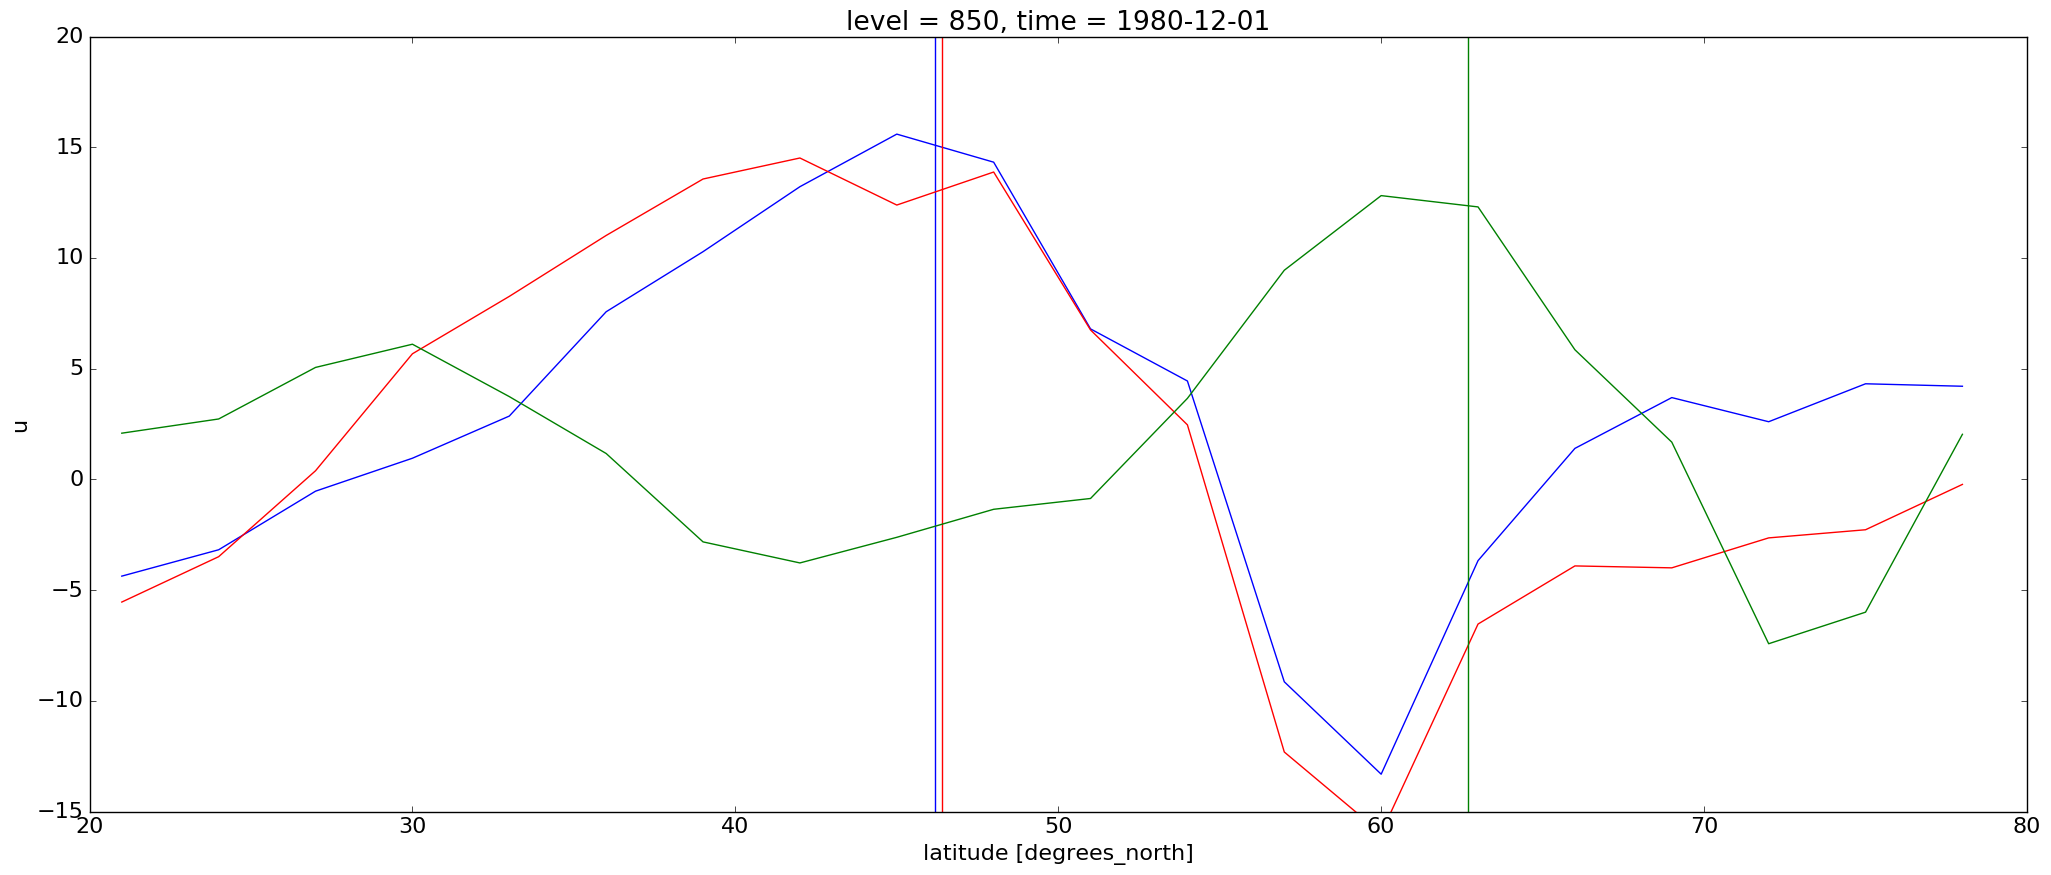

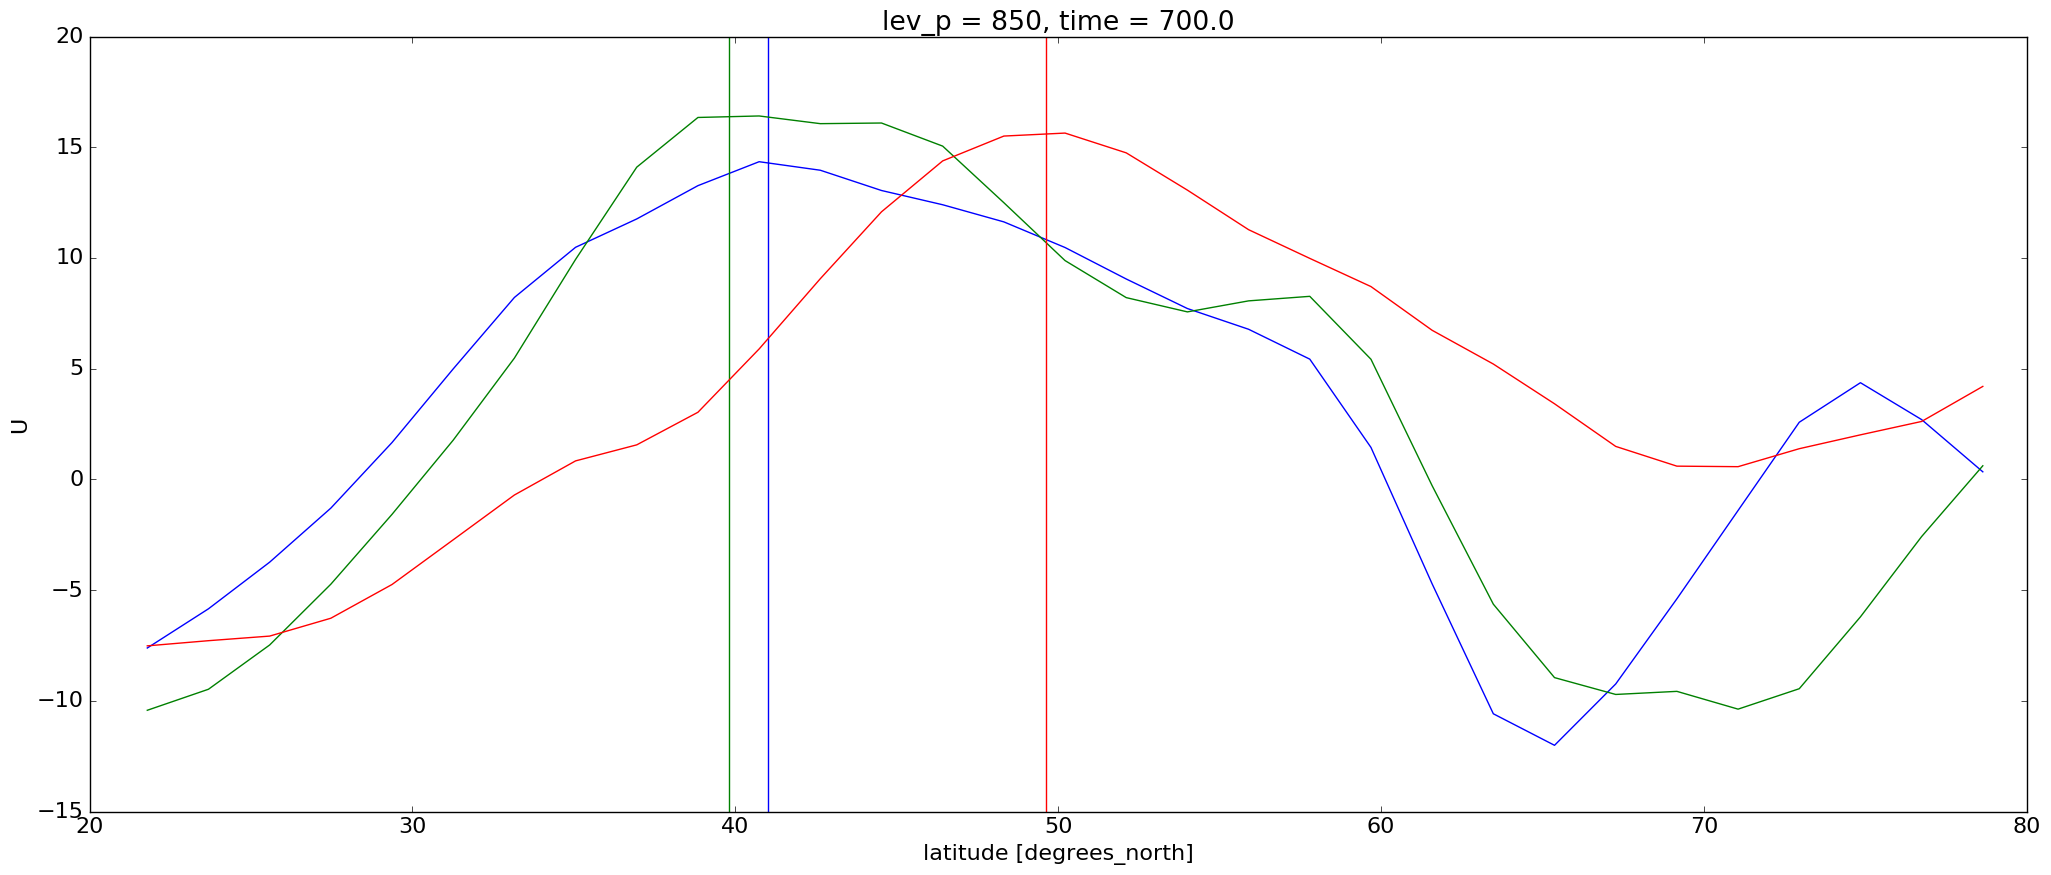

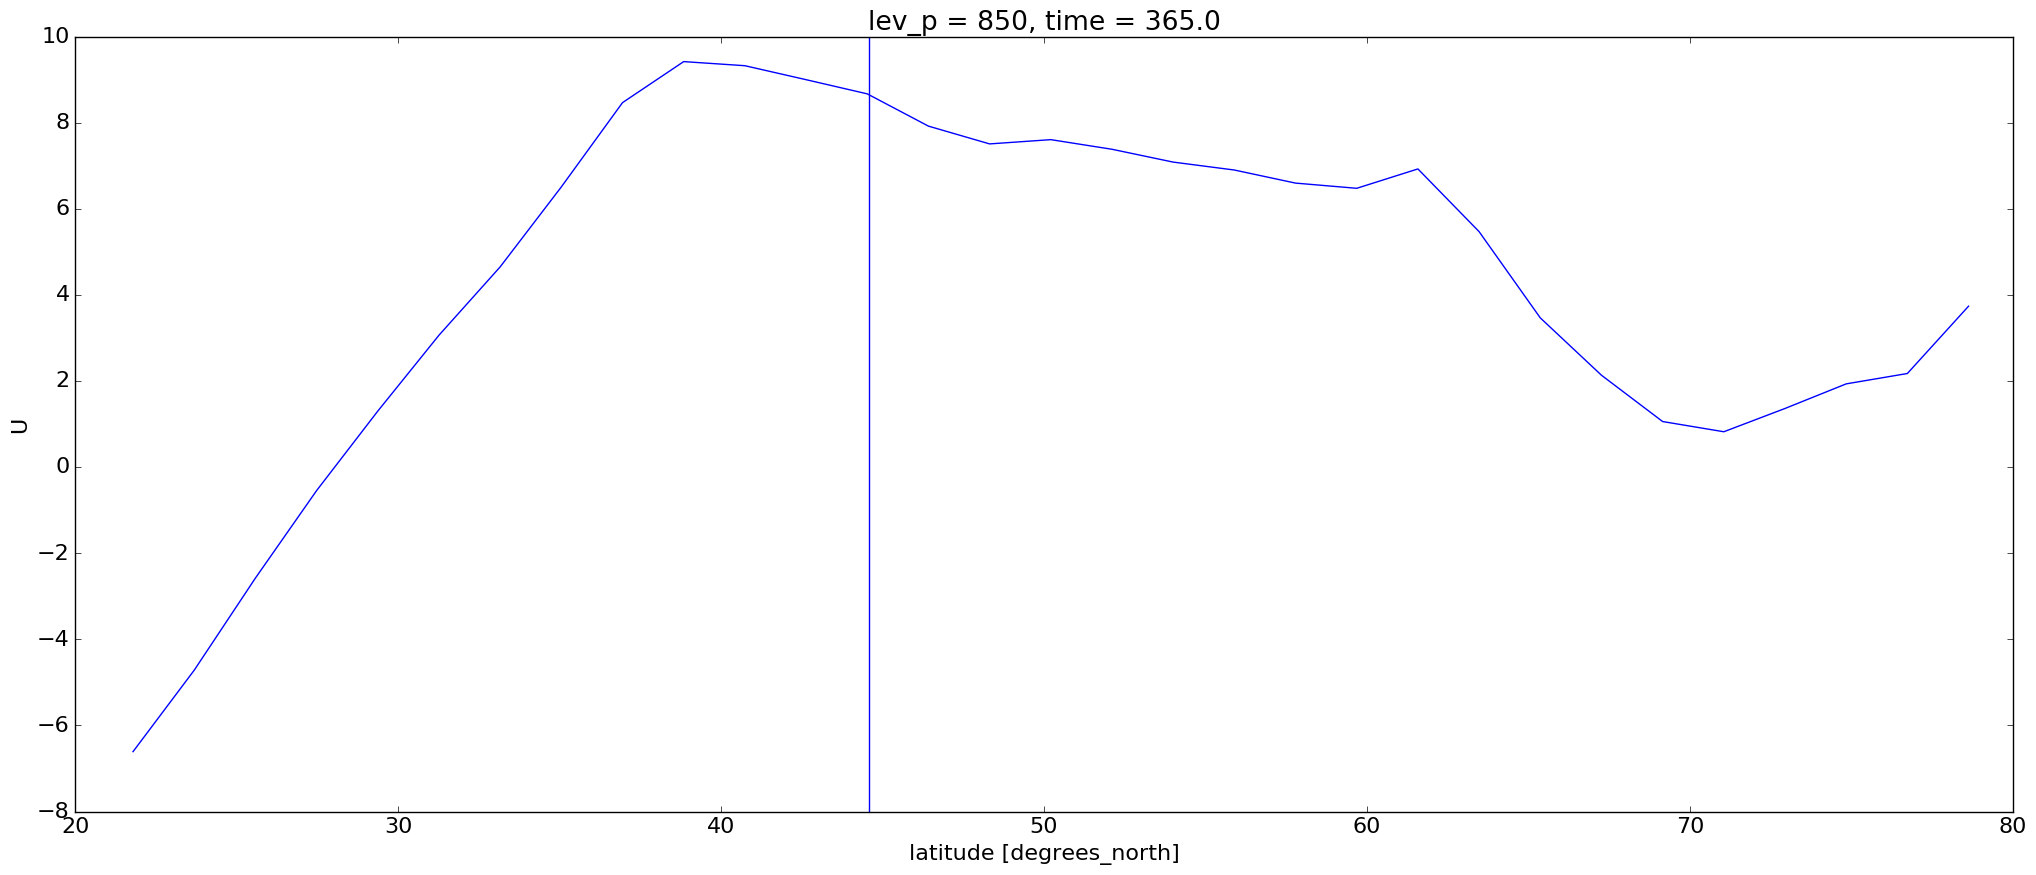

In [158]:
## Test that daily data matches with JLI data
iexp = 'erai'
iseas = 'DJF'

JLIval = JLI_seas[iexp][iseas]['jetlat'].values[0]
toplot = (dailyU_seas[iexp][iseas].sel(longitude=slice(300,360)).sel(latitude=slice(80,20)).
          mean(dim='longitude').isel(time=0))
toplot.plot(color='b')
plt.axvline(JLIval,color='b')

JLIval = JLI_seas[iexp][iseas]['jetlat'].values[30]
toplot = (dailyU_seas[iexp][iseas].sel(longitude=slice(300,360)).sel(latitude=slice(80,20))
          .mean(dim='longitude').isel(time=30))
toplot.plot(color='r')
plt.axvline(JLIval,color='r')

JLIval = JLI_seas[iexp][iseas]['jetlat'].values[60]
toplot = (dailyU_seas[iexp][iseas].sel(longitude=slice(300,360)).sel(latitude=slice(80,20))
          .mean(dim='longitude').isel(time=60))
toplot.plot(color='g')
plt.axvline(JLIval,color='g')
plt.show()

iexp = 'waccm-ctl-extended'
iseas = 'DJF'

JLIval = JLI_seas[iexp][iseas]['jetlat'].values[0]
toplot = (dailyU_seas[iexp][iseas].U.sel(lon=slice(300,360)).sel(lat=slice(20,80)).
          mean(dim='lon').isel(time=0))
toplot.plot(color='b')
plt.axvline(JLIval,color='b')
iexp = 'waccm-ctl-extended'
iseas = 'DJF'

JLIval = JLI_seas[iexp][iseas]['jetlat'].values[30]
toplot = (dailyU_seas[iexp][iseas].U.sel(lon=slice(300,360)).sel(lat=slice(20,80)).
          mean(dim='lon').isel(time=30))
toplot.plot(color='g')
plt.axvline(JLIval,color='g')
plt.ylim(-15,20)


JLIval = JLI_seas[iexp][iseas]['jetlat'].values[60]
toplot = (dailyU_seas[iexp][iseas].U.sel(lon=slice(300,360)).sel(lat=slice(20,80)).
          mean(dim='lon').isel(time=60))
toplot.plot(color='r')
plt.axvline(JLIval,color='r')
plt.ylim(-15,20)
plt.show()

iexp = 'waccm-varyAll-1980-2010'
iseas = 'DJF'

JLIval = JLI_seas[iexp][iseas]['jetlat'].values[0]
dailyU_seas[iexp][iseas].U.sel(lon=slice(300,360)).sel(lat=slice(20,80)).mean(dim='lon').isel(time=0).plot()
plt.axvline(JLIval)
plt.show()



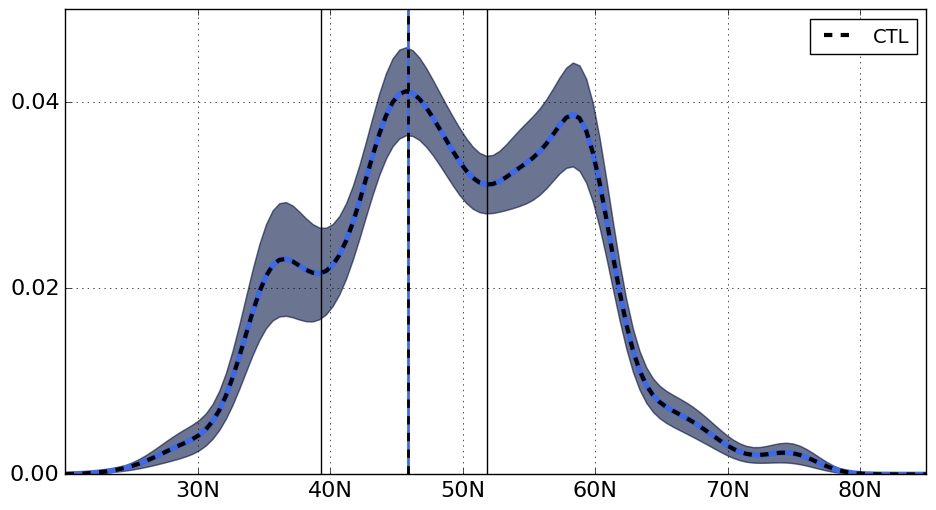

In [197]:
# Plot ERA=I to determine the regime boundaries
matplotlib.rcParams['figure.figsize']=(25,6)
matplotlib.rcParams.update({'font.size':16})

lowerbound = 39.3
upperbound=51.8

nrows = 1
n=1
ctl = 'erai'
for exp in ['erai']:
    plt.subplot(nrows,2,n);
    plothist_error_comp(JLI_seas[ctl][iseas]['jetlat'],kdeMCstd[iseas][nMC][ctl],
                atmfields[ctl][iseas].sel(level = 850).sel(longitude=slice(300,360))
                        .mean(dim='longitude').sel(latitude=slice(80,20)).squeeze(),
                'CTL',
                JLI_seas[exp][iseas]['jetlat'],kdeMCstd[iseas][nMC][exp],
                atmfields[exp][iseas].sel(level = 850).sel(longitude=slice(300,360))
                        .mean(dim='longitude').sel(latitude=slice(80,20)),
                '',15,85,0.0,0.05,colorin='royalblue')
    plt.xticks([20,30,40,50,60,70,80],['','30N','40N','50N','60N','70N','80N'],fontsize=16)
    plt.yticks([0.0,0.02,0.04])
    plt.xlim(20,85)
    plt.subplots_adjust(wspace=0.25, hspace=0.25) 
    if exp in ['waccm-flat-extended','waccm-NoR-extended','waccm-shiftG-extended']:
        plt.ylabel('frequency',fontsize = 14)
    plt.grid(True)
    #plt.legend(loc='upper right')
    
    plt.axvline(lowerbound,color='k')
    plt.axvline(upperbound,color='k')

    n+=1


In [198]:
# find northern peak days: ERAI and WACCM CTL
iseas = 'DJF'

south_U = {}
mid_U = {}
north_U = {}

south_indices = {}
mid_indices = {}
north_indices = {}


for iexp in ['erai','waccm-varyAll-1980-2010','waccm-ctl-extended']:

    south_indices[iexp] = np.concatenate(np.argwhere(JLI_seas[iexp][iseas]['jetlat'].values < lowerbound)).ravel()
    mid_indices[iexp] = np.concatenate(np.argwhere((JLI_seas[iexp][iseas]['jetlat'].values >= lowerbound) & 
                              (JLI_seas[iexp][iseas]['jetlat'].values <= upperbound))).ravel()
    north_indices[iexp] = np.concatenate(np.argwhere(JLI_seas[iexp][iseas]['jetlat'].values > upperbound)).ravel()

    south_U[iexp] = dailyU_seas[iexp][iseas].isel(time=south_indices[iexp])
    mid_U[iexp] = dailyU_seas[iexp][iseas].isel(time=mid_indices[iexp])
    north_U[iexp] = dailyU_seas[iexp][iseas].isel(time=north_indices[iexp])


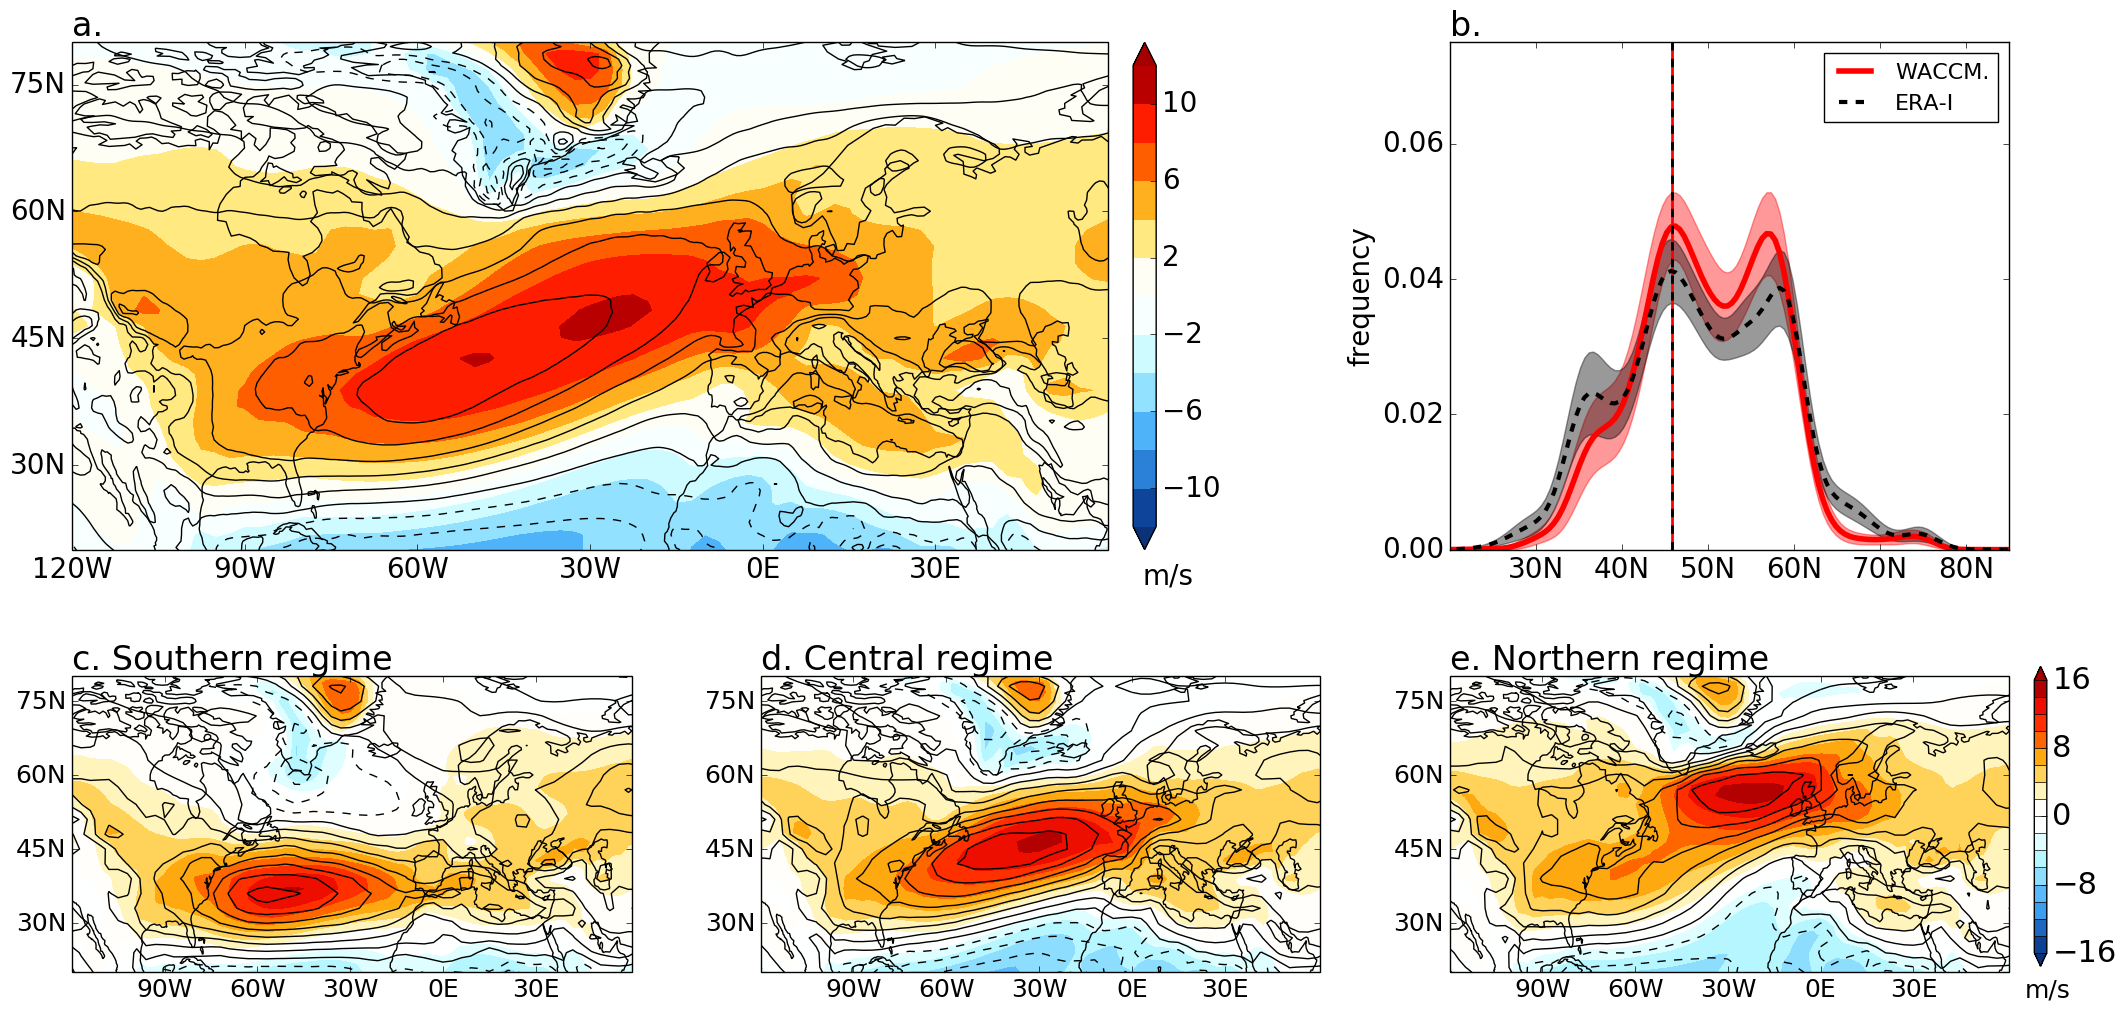

In [227]:
# plot for paper: absolute values

matplotlib.rcParams['figure.figsize']=(25,12)
matplotlib.rcParams.update({'font.size':20})

n=1
#ax1 = plt.subplot2grid((2, 1), (0, 0), colspan = width)
#ax2 = plt.subplot2grid((2, 1), (1, 0), rowspan = height)

levels0 = np.arange(-12,12.1,2)
levels0E = levels0
levellabels0 = [-10,-6,-2,2,6,10]

exp = 'waccm-varyAll-1980-2010'
ctl = 'erai'


plev=850
ymin=20
ymax=80
cenlon = 0
iseas='DJF'

cmap='RdBu_r'

fig, axes = plt.subplots(nrows=5, ncols=6)

#plt.subplot2grid((3, 1), (0, 0), rowspan = 1.5) ; n+=1 #(2,1,1); n+=1
var = 'U'
ax = plt.subplot2grid((5, 6), (0, 0),rowspan=3, colspan = 4,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

pltCTL = atmfields['p' + exp][iseas][var].mean(dim='time').sel(lev_p = plev)
toplotCTLlat = pltCTL.lat
toplotCTLlon = shiftlonlons(pltCTL.lon,len(pltCTL.lon))
pltCTL = shiftlons(pltCTL,len(pltCTL.lon))

pltERA = atmfields[ctl][iseas].mean(dim='time').sel(level=plev)
pltERAlat = pltERA.latitude
pltERAlon = shiftlonlons(pltERA.longitude,len(pltERA.longitude))
pltERA = shiftlons(pltERA,len(pltERA.longitude))


plt.contourf(toplotCTLlon,toplotCTLlat,pltCTL,
                       cmap=cmap_wc,levels=levels0,extend='both',cbar_kwargs={'pad':0.02})
ax.set_xticks([-120,-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['120W','90W','60W','30W','0E','30E'])

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'])

cbar = plt.colorbar(extend='max',ticks=levellabels0,pad=0.02)
    
plt.contour(pltERAlon,pltERAlat,pltERA,
               colors='k',levels=levels0E)
plt.title('a.',loc='left')
plt.text(66,16,'m/s')
plt.ylim(ymin,ymax)
plt.xlim(-120,60)
plt.subplots_adjust( wspace=0.05, hspace=1.0)    


plt.subplot2grid((5, 6), (0, 4),rowspan=3,colspan=2) ; n+=1 #(2,1,1); n+=1

linewidth=2
var='jetlat'
ymin=0; ymax= 0.075

plothist_error_comp(JLI_seas[ctl][iseas]['jetlat'],kdeMCstd[iseas][nMC][ctl],
                avgDJFU[ctl].sel(latitude=slice(80,20)).squeeze(),
                'ERA-I',
                JLI_seas[exp][iseas]['jetlat'],kdeMCstd[iseas][nMC][exp],
                avgDJFU[exp].sel(lat=slice(20,80)).squeeze(),
                'WACCM.',15,85,0.0,0.08,colorin='r')

plt.legend(loc='best')
plt.title('')

plt.title('b.',loc='left')

plt.ylabel('frequency')
plt.ylim(ymin,ymax)
plt.xticks([20,30,40,50,60,70,80],['','30N','40N','50N','60N','70N','80N'])
plt.yticks([0.0,0.02,0.04,0.06])
plt.xlim(20,85)
plt.legend(fontsize=16,loc='best')


exp = 'waccm-ctl-extended'
ctl = 'erai'
                
levels0 = np.arange(-16,16.1,2.0)
levels0E = levels0

levellabels0 = [-16,-8,0,8,16]


ax = plt.subplot2grid((5, 6), (3, 0),rowspan=2, colspan = 2,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

toplotEXP = south_U[exp].U.mean(dim='time').squeeze()
toplotEXP = add_lon(toplotEXP,coord='lon')

plt.contourf(toplotEXP.lon,toplotEXP.lat,toplotEXP,
            cmap=cmap_wc,levels=levels0,extend='both',add_colorbar=True)
#cbar = plt.colorbar(extend='max',ticks=levellabels0,pad=0.02)


toplotCTL = south_U[ctl].mean(dim='time').squeeze()
toplotCTL = add_lon(toplotCTL,coord='longitude')

plt.contour(toplotCTL.longitude,toplotCTL.latitude,toplotCTL,
            colors='k',levels=levels0,extend='both',add_colorbar=True)


ax.set_xticks([-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['90W','60W','30W','0E','30E'],fontsize=18)

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'],fontsize=18)
    
plt.title('c. Southern regime',loc='left')
plt.title('')
plt.xlabel('')

plt.ylim(20,80)
plt.xlim(-120,61)


ax = plt.subplot2grid((5, 6), (3, 2),rowspan=2, colspan = 2,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

toplotEXP = mid_U[exp].U.mean(dim='time').squeeze()
toplotEXP = add_lon(toplotEXP,coord='lon')

plt.contourf(toplotEXP.lon,toplotEXP.lat,toplotEXP,
            cmap=cmap_wc,levels=levels0,extend='both',add_colorbar=False)
#cbar = plt.colorbar(extend='max',ticks=levellabels0,pad=0.02)


toplotCTL = mid_U[ctl].mean(dim='time').squeeze()
toplotCTL = add_lon(toplotCTL,coord='longitude')

plt.contour(toplotCTL.longitude,toplotCTL.latitude,toplotCTL,
            colors='k',levels=levels0,extend='both',add_colorbar=False)

ax.set_xticks([-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['90W','60W','30W','0E','30E'],fontsize=18)

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'],fontsize=18)
    
plt.title('d. Central regime',loc='left')
plt.title('')
plt.xlabel('')

plt.ylim(20,80)
plt.xlim(-120,61)



ax = plt.subplot2grid((5, 6), (3, 4),rowspan=2, colspan = 2,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

toplotEXP = north_U[exp].U.mean(dim='time').squeeze()
toplotEXP = add_lon(toplotEXP,coord='lon')

im = plt.contourf(toplotEXP.lon,toplotEXP.lat,toplotEXP,
            cmap=cmap_wc,levels=levels0,extend='both',add_colorbar=True)
#cbar = plt.colorbar(extend='max',ticks=levellabels0,pad=0.02)


toplotCTL = north_U[ctl].mean(dim='time').squeeze()
toplotCTL = add_lon(toplotCTL,coord='longitude')

plt.contour(toplotCTL.longitude,toplotCTL.latitude,toplotCTL,
            colors='k',levels=levels0,extend='both',add_colorbar=True)

ax.set_xticks([-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['90W','60W','30W','0E','30E'],fontsize=18)

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'],fontsize=18)
    
plt.title('e. Northern regime',loc='left')
plt.title('')
plt.xlabel('')
plt.text(66,15,'m/s',fontsize=18)

plt.ylim(20,80)
plt.xlim(-120,61)

plt.subplots_adjust(wspace=0.6, hspace=1.5)  

cbar_ax = fig.add_axes([0.91, 0.13, 0.005, 0.25])
cbar_ax.tick_params(labelsize=22) 
fig.colorbar(im,cax=cbar_ax,drawedges=True,orientation='vertical',ticks=levellabels0)

plt.show()



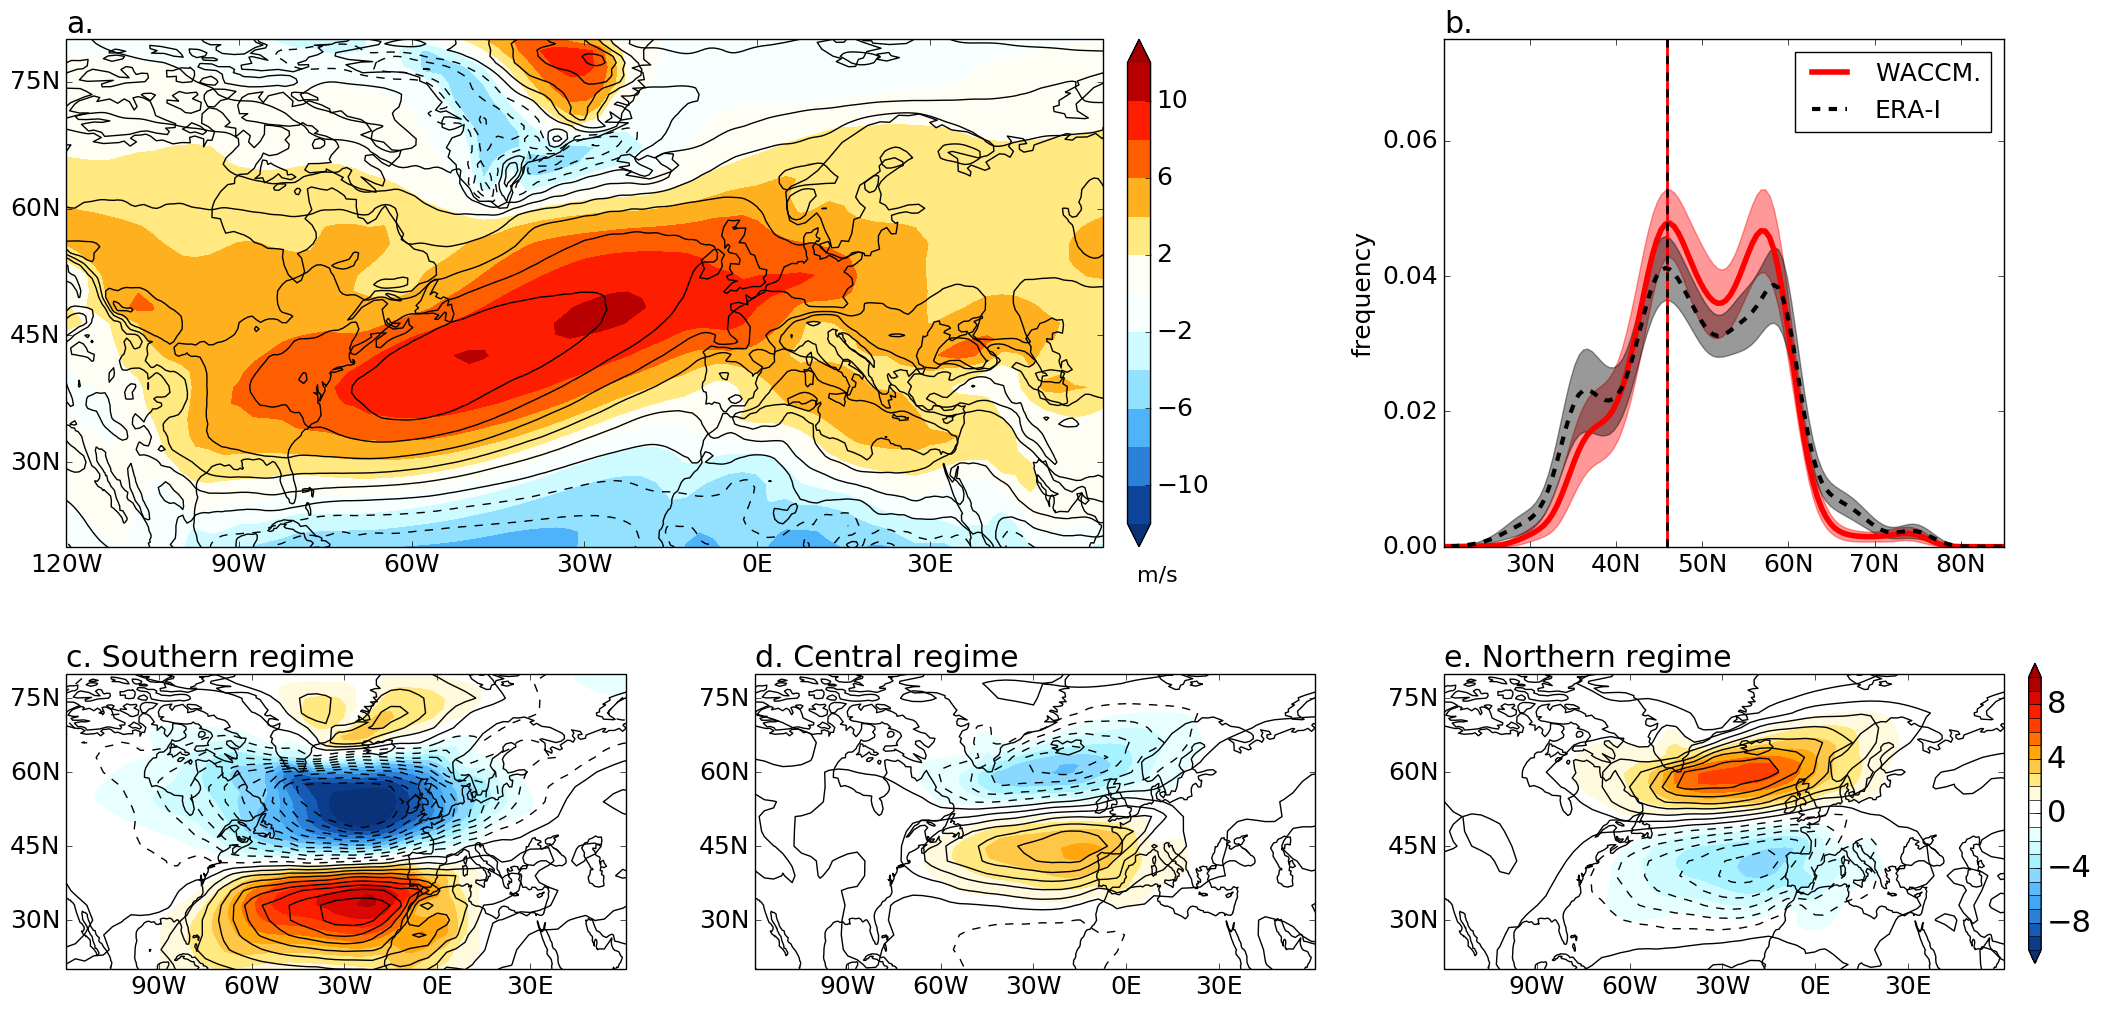

In [228]:
# plot for paper: anomalies 

matplotlib.rcParams['figure.figsize']=(25,12)
matplotlib.rcParams.update({'font.size':18})

n=1

levels0 = np.arange(-12,12.1,2)
levels0E = levels0
levellabels0 = [-10,-6,-2,2,6,10]

exp = 'waccm-varyAll-1980-2010'
ctl = 'erai'

plev=850
ymin=20
ymax=80
cenlon = 0
iseas='DJF'

cmap='RdBu_r'

fig, axes = plt.subplots(nrows=5, ncols=6)


#plt.subplot2grid((3, 1), (0, 0), rowspan = 1.5) ; n+=1 #(2,1,1); n+=1
var = 'U'
ax = plt.subplot2grid((5, 6), (0, 0),rowspan=3, colspan = 4,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

pltCTL = atmfields['p' + exp][iseas][var].mean(dim='time').sel(lev_p = plev)
toplotCTLlat = pltCTL.lat
toplotCTLlon = shiftlonlons(pltCTL.lon,len(pltCTL.lon))
pltCTL = shiftlons(pltCTL,len(pltCTL.lon))

pltERA = atmfields[ctl][iseas].mean(dim='time').sel(level=plev)
pltERAlat = pltERA.latitude
pltERAlon = shiftlonlons(pltERA.longitude,len(pltERA.longitude))
pltERA = shiftlons(pltERA,len(pltERA.longitude))


plt.contourf(toplotCTLlon,toplotCTLlat,pltCTL,
                       cmap=cmap_wc,levels=levels0,extend='both',cbar_kwargs={'pad':0.02})
ax.set_xticks([-120,-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['120W','90W','60W','30W','0E','30E'])

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'])

cbar = plt.colorbar(extend='max',ticks=levellabels0,pad=0.02)
    
plt.contour(pltERAlon,pltERAlat,pltERA,
               colors='k',levels=levels0E)
plt.title('a.',loc='left')
plt.text(66,16,'m/s',fontsize=16)
plt.ylim(ymin,ymax)
plt.xlim(-120,60)
plt.subplots_adjust( wspace=0.05, hspace=1.0)    


plt.subplot2grid((5, 6), (0, 4),rowspan=3,colspan=2) ; n+=1 #(2,1,1); n+=1

linewidth=2
var='jetlat'
ymin=0; ymax= 0.075

plothist_error_comp(JLI_seas[ctl][iseas]['jetlat'],kdeMCstd[iseas][nMC][ctl],
                avgDJFU[ctl].sel(latitude=slice(80,20)).squeeze(),
                'ERA-I',
                JLI_seas[exp][iseas]['jetlat'],kdeMCstd[iseas][nMC][exp],
                avgDJFU[exp].sel(lat=slice(20,80)).squeeze(),
                'WACCM.',15,85,0.0,0.08,colorin='r')

plt.legend(loc='best')
plt.title('')

plt.title('b.',loc='left')

plt.ylabel('frequency')
plt.ylim(ymin,ymax)
plt.xticks([20,30,40,50,60,70,80],['','30N','40N','50N','60N','70N','80N'])
plt.yticks([0.0,0.02,0.04,0.06])
plt.xlim(20,85)
plt.legend(fontsize=18,loc='best')





exp = 'waccm-ctl-extended'
ctl = 'erai'

levels0 = np.arange(-10,10.1,1.0)
levels0E = levels0

levellabels0 = [-8,-4,0,4,8]


ax = plt.subplot2grid((5, 6), (3, 0),rowspan=2, colspan = 2,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

toplotEXP = south_U[exp].U.mean(dim='time').squeeze() - dailyU_seas[exp][iseas].U.mean(dim='time').squeeze().values
toplotEXP = add_lon(toplotEXP,coord='lon')

plt.contourf(toplotEXP.lon,toplotEXP.lat,toplotEXP,
            cmap=cmap_wc,levels=levels0,extend='both',add_colorbar=True)

toplotCTL = south_U[ctl].mean(dim='time').squeeze()- dailyU_seas[ctl][iseas].mean(dim='time').squeeze()
toplotCTL = add_lon(toplotCTL,coord='longitude')

plt.contour(toplotCTL.longitude,toplotCTL.latitude,toplotCTL,
            colors='k',levels=levels0,extend='both',add_colorbar=True)


ax.set_xticks([-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['90W','60W','30W','0E','30E'],fontsize=18)

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'],fontsize=18)

    
plt.title('c. Southern regime',loc='left')
plt.title('')
plt.xlabel('')

plt.ylim(20,80)
plt.xlim(-120,61)


ax = plt.subplot2grid((5, 6), (3, 2),rowspan=2, colspan = 2,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

toplotEXP = mid_U[exp].U.mean(dim='time').squeeze() - dailyU_seas[exp][iseas].U.mean(dim='time').squeeze().values
toplotEXP = add_lon(toplotEXP,coord='lon')

plt.contourf(toplotEXP.lon,toplotEXP.lat,toplotEXP,
            cmap=cmap_wc,levels=levels0,extend='both',add_colorbar=True)


toplotCTL = mid_U[ctl].mean(dim='time').squeeze() - dailyU_seas[ctl][iseas].mean(dim='time').squeeze()
toplotCTL = add_lon(toplotCTL,coord='longitude')

plt.contour(toplotCTL.longitude,toplotCTL.latitude,toplotCTL,
            colors='k',levels=levels0,extend='both',add_colorbar=True)

ax.set_xticks([-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['90W','60W','30W','0E','30E'],fontsize=18)

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'],fontsize=18)

plt.title('d. Central regime',loc='left')
plt.title('')
plt.xlabel('')

plt.ylim(20,80)
plt.xlim(-120,61)



ax = plt.subplot2grid((5, 6), (3, 4),rowspan=2, colspan = 2,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

toplotEXP = north_U[exp].U.mean(dim='time').squeeze() - dailyU_seas[exp][iseas].U.mean(dim='time').squeeze().values
toplotEXP = add_lon(toplotEXP,coord='lon')

im = plt.contourf(toplotEXP.lon,toplotEXP.lat,toplotEXP,
            cmap=cmap_wc,levels=levels0,extend='both',add_colorbar=True)

toplotCTL = north_U[ctl].mean(dim='time').squeeze() - dailyU_seas[ctl][iseas].mean(dim='time').squeeze()
toplotCTL = add_lon(toplotCTL,coord='longitude')

plt.contour(toplotCTL.longitude,toplotCTL.latitude,toplotCTL,
            colors='k',levels=levels0,extend='both',add_colorbar=True)

ax.set_xticks([-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['90W','60W','30W','0E','30E'],fontsize=18)

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'],fontsize=18)

    
plt.title('e. Northern regime',loc='left')
plt.title('')
plt.xlabel('')

plt.ylim(20,80)
plt.xlim(-120,61)

plt.subplots_adjust(wspace=0.6, hspace=1.5)  

cbar_ax = fig.add_axes([0.91, 0.13, 0.005, 0.25])
cbar_ax.tick_params(labelsize=22) 
fig.colorbar(im,cax=cbar_ax,drawedges=True,orientation='vertical',ticks=levellabels0)

plt.show()



## Figure 2

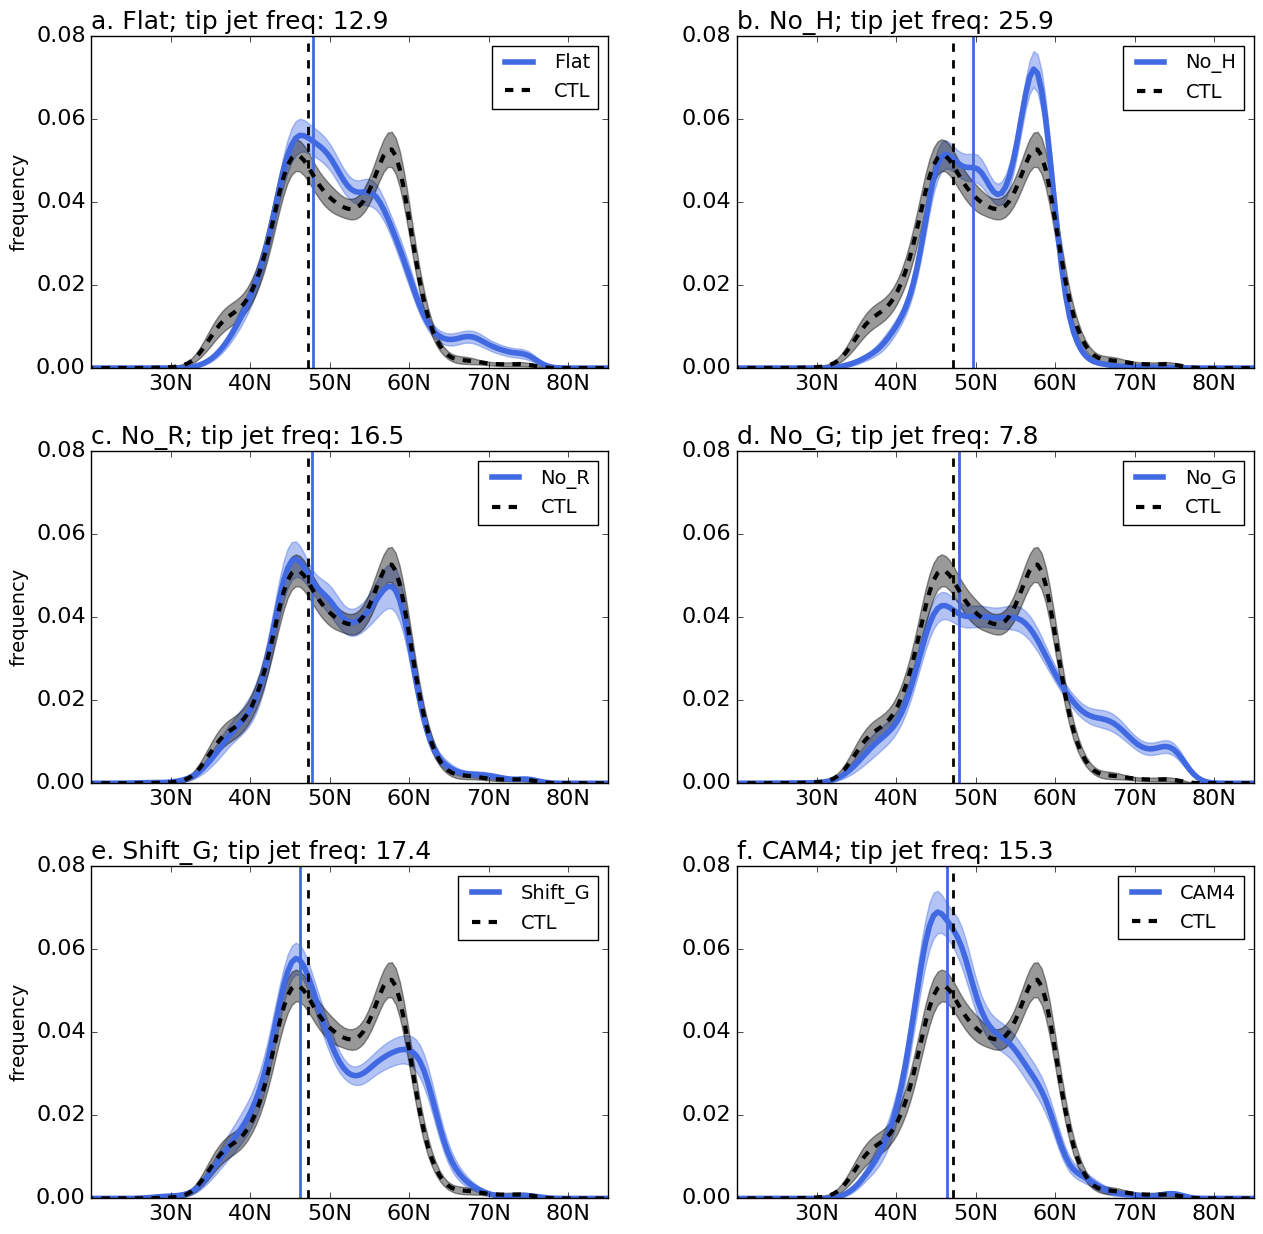

In [976]:
# plot for DJF new colours: Uthresh = 16
nMC = 1000
nrows =3

# nMC = 1000 
matplotlib.rcParams['figure.figsize']=(15,nrows * 5)
matplotlib.rcParams.update({'font.size':16})

subplottitles = ['a. Flat','b. No_H','c. No_R','d. No_G','e. Shift_G','f. CAM4']
legendtitles = ['Flat','No_H','No_R','No_G','Shift_G','CAM4']

n=1
Uthresh = 16

fig, axes = plt.subplots(nrows=nrows, ncols=2)

iseas = 'DJF'
ctl = 'waccm-ctl-extended'
for exp in ['waccm-flat-extended','waccm-NoMT-extended','waccm-NoR-extended',
            'waccm-NoG-extended','waccm-shiftG-extended','cesm-topo']:
    plt.subplot(nrows,2,n);
    plothist_error_comp(JLI_seas[ctl][iseas]['jetlat'],kdeMCstd[iseas][nMC][ctl],
                atmfields['p' + ctl][iseas].U.sel(lev_p = 850).sel(lon=slice(300,360))
                        .mean(dim='lon').sel(lat=slice(20,80)).squeeze(),
                'CTL',
                JLI_seas[exp][iseas]['jetlat'],kdeMCstd[iseas][nMC][exp],
                atmfields['p' + exp][iseas].U.sel(lev_p = 850).sel(lon=slice(300,360))
                        .mean(dim='lon').sel(lat=slice(20,80)),
                legendtitles[n-1],15,85,0.0,0.08,colorin='royalblue')
    plt.title(subplottitles[n-1] + '; tip jet freq: ' + "{:3.1f}".format(90.0 * TJ_freq_mean[Uthresh][TJnames[exp]]),
              loc='left',fontsize=18)
    plt.xticks([20,30,40,50,60,70,80],['','30N','40N','50N','60N','70N','80N'],fontsize=16)
    plt.yticks([0.0,0.02,0.04,0.06,0.08])
    plt.xlim(20,85)
    plt.subplots_adjust(wspace=0.25, hspace=0.25) 
    if exp in ['waccm-flat-extended','waccm-NoR-extended','waccm-shiftG-extended']:
        plt.ylabel('frequency',fontsize = 14)
    #plt.legend(loc='upper right')
    n+=1
    
fig.savefig('/home/disk/eos4/rachel/Figures/JetRegimes/JLIfig_16_July19.pdf')


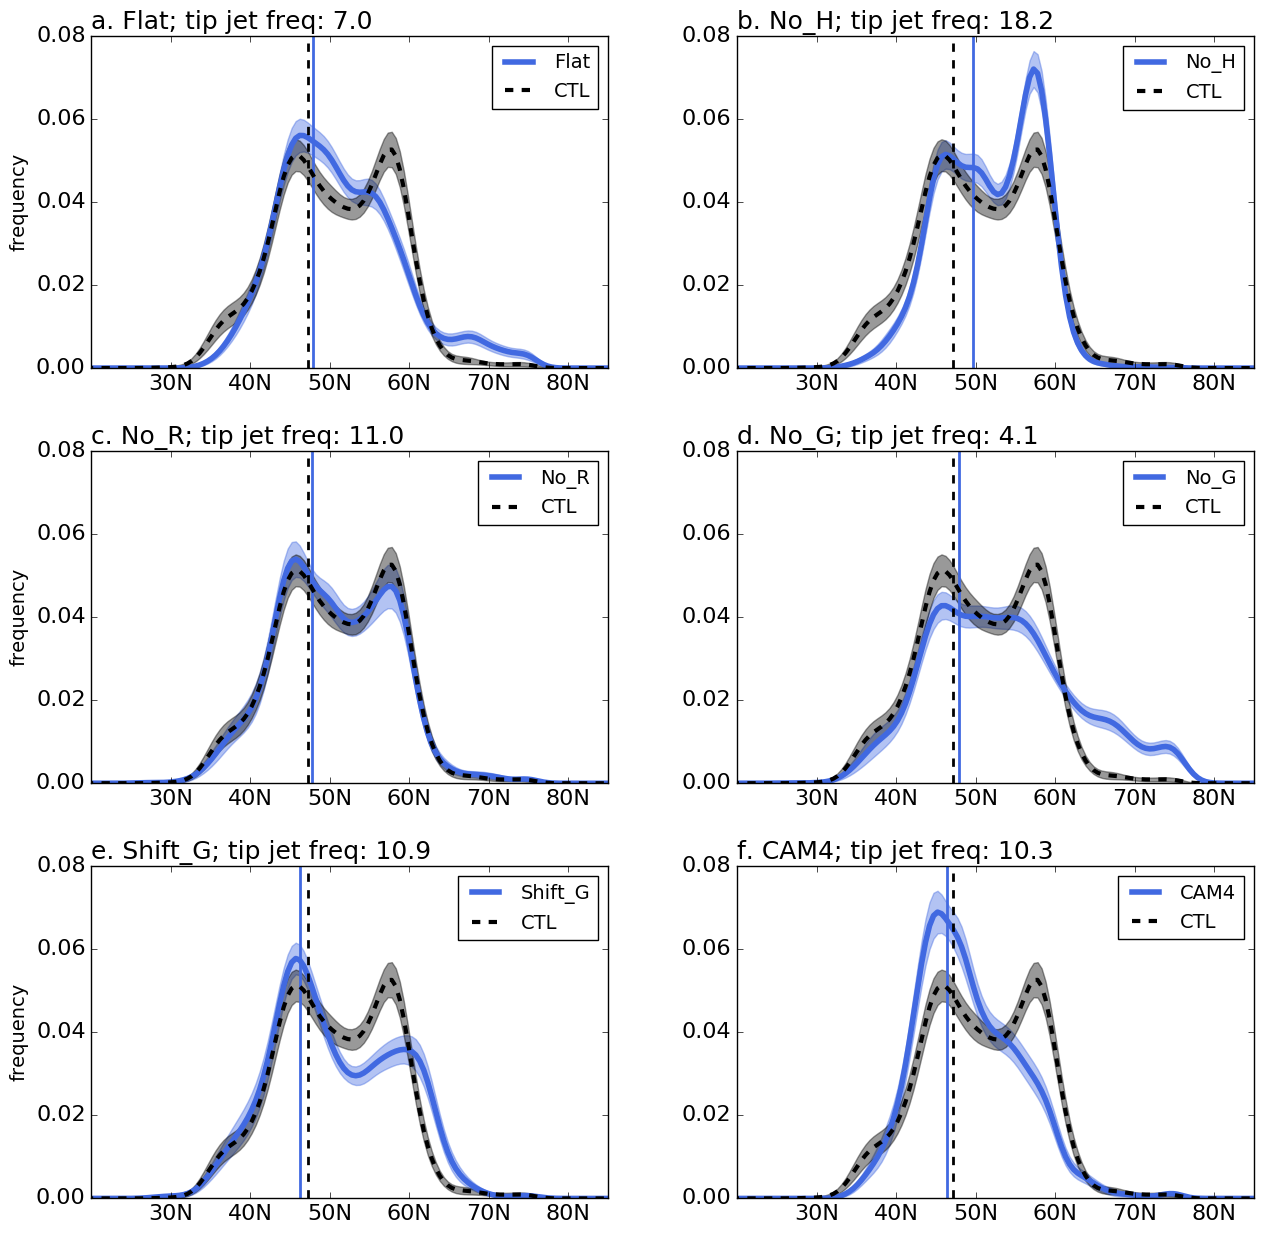

In [881]:
# plot for DJF new colours: Uthresh = 18
nMC = 1000
nrows =3

# nMC = 1000 
matplotlib.rcParams['figure.figsize']=(15,nrows * 5)
matplotlib.rcParams.update({'font.size':16})

subplottitles = ['a. Flat','b. No_H','c. No_R','d. No_G','e. Shift_G','f. CAM4']
legendtitles = ['Flat','No_H','No_R','No_G','Shift_G','CAM4']

n=1
Uthresh = 18

fig, axes = plt.subplots(nrows=nrows, ncols=2)

iseas = 'DJF'
ctl = 'waccm-ctl-extended'
for exp in ['waccm-flat-extended','waccm-NoMT-extended','waccm-NoR-extended',
            'waccm-NoG-extended','waccm-shiftG-extended','cesm-topo']:
    plt.subplot(nrows,2,n);
    plothist_error_comp(JLI_seas[ctl]['DJF']['jetlat'],kdeMCstd[iseas][nMC][ctl],
                atmfields['p' + ctl][iseas].U.sel(lev_p = 850).sel(lon=slice(300,360))
                        .mean(dim='lon').sel(lat=slice(20,80)).squeeze(),
                'CTL',
                JLI_seas[exp]['DJF']['jetlat'],kdeMCstd[iseas][nMC][exp],
                atmfields['p' + exp][iseas].U.sel(lev_p = 850).sel(lon=slice(300,360))
                        .mean(dim='lon').sel(lat=slice(20,80)),
                legendtitles[n-1],15,85,0.0,0.08,colorin='royalblue')
    plt.title(subplottitles[n-1] + '; tip jet freq: ' + "{:3.1f}".format(90.0 * TJ_freq_mean[Uthresh][TJnames[exp]]),
              loc='left',fontsize=18)
    plt.xticks([20,30,40,50,60,70,80],['','30N','40N','50N','60N','70N','80N'],fontsize=16)
    plt.yticks([0.0,0.02,0.04,0.06,0.08])
    plt.xlim(20,85)
    plt.subplots_adjust(wspace=0.25, hspace=0.25) 
    if exp in ['waccm-flat-extended','waccm-NoR-extended','waccm-shiftG-extended']:
        plt.ylabel('frequency',fontsize = 14)
    #plt.legend(loc='upper right')
    n+=1
    


## Figure 3

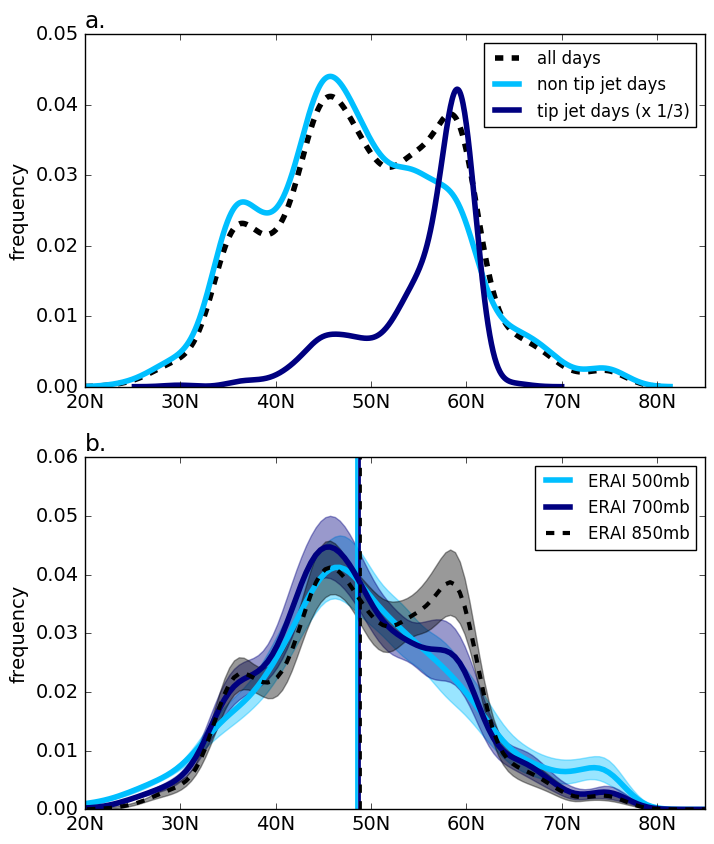

In [972]:
# print figure 3
nMC = 1000
nrows =2
matplotlib.rcParams['figure.figsize']=(8,nrows * 5)
matplotlib.rcParams.update({'font.size':14})
n=1

fig, axes = plt.subplots(nrows=nrows, ncols=1)

Uthresh = 16
iexp='erai'

indices = TJindices[Uthresh][iexp][0].copy()
temp = dailyU[iexp].sel(time=slice('1980','2011')).groupby('time.season')
for iseas,data in temp:
    if iseas == 'DJF':
        Udata = data

jetlats = jetdata[iexp]['Atl']['jetlat'].sel(time=slice('1980','2011'))

plt.subplot(2,1,n); n+=1
remove_tipdays(Udata,jetlats,indices)


plt.subplot(2,1,n)

ctl = 'erai'
seas = 'DJF'

Dir = '/home/disk/eos4/rachel/Obs/ERAI/Processed/'
ERAI_U = xrOpen(Dir + 'Clim_seas_U_TH_Z_pl_all_3deg_1980-2015.nc').u
seas_ERAI = ERAI_U.groupby('time.season')
for iseas,data in seas_ERAI:
    ERAI_DJF_U = data


inputdata = jetdata['erai']['Atl']['jetlat']
    
for exp in ['erai_500']:
    plothist_error_comp(JLI_seas[ctl]['DJF']['jetlat'],kdeMCstd[seas][nMC][ctl],
                ERAI_DJF_U.sel(level=850).sel(longitude=slice(300,360)).mean(dim='longitude')
                .sel(latitude=slice(80,20)).squeeze(),
                None,
                JLI_seas[exp]['DJF']['jetlat'],kdeMCstd[seas][nMC][exp],
                ERAI_DJF_U.sel(level=700).sel(longitude=slice(300,360)).mean(dim='longitude')
                .sel(latitude=slice(80,20)).squeeze(),
                'ERAI 500mb',
                15,85,0.0,0.075,colorin='deepskyblue',pltctl=False)
for exp in ['erai_700']:
    plothist_error_comp(JLI_seas[ctl]['DJF']['jetlat'],kdeMCstd[seas][nMC][ctl],
                ERAI_DJF_U.sel(level=850).sel(longitude=slice(300,360)).mean(dim='longitude')
                .sel(latitude=slice(80,20)).squeeze(),
                'ERAI 850mb',
                JLI_seas[exp]['DJF']['jetlat'],kdeMCstd[seas][nMC][exp],
                ERAI_DJF_U.sel(level=500).sel(longitude=slice(300,360)).mean(dim='longitude')
                .sel(latitude=slice(80,20)).squeeze(),
                'ERAI 700mb',
                15,85,0.0,0.06,colorin='navy')
    plt.title('')

    plt.xticks([20,30,40,50,60,70,80],['20N','30N','40N','50N','60N','70N','80N'])
    plt.xlim(20,85)
    plt.yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
    plt.ylim(0,0.06)
    plt.ylabel('frequency')
    plt.legend(loc='best',fontsize=12) 
    plt.title('b.',loc='left')
    

fig.savefig('/home/disk/eos4/rachel/Figures/JetRegimes/JLI_ERAI_TJs_July18.pdf')
plt.show()

## Figure 4

In [973]:
def make_figure4(Uthresh):
    plev = 850
    var='U'
    # Climatology
    n=1
    lon1 = 300; lon2 = 360
    ax = plt.subplot(2,1,n); n+=1

    exp = 'erai'
    argfileUdaily = dailyU[exp]
    #DJF_U850 = selectmonths(argfileUdaily,'DJF',obs=True)
    seas_U850 = argfileUdaily.groupby('time.season')
    for iseas,data in seas_U850:
        if iseas == 'DJF':
            DJF_U850 = data

    toplot = DJF_U850.sel(longitude = slice(lon1,lon2)).mean(dim='longitude')
    nyears = len(toplot.time)/90
    nlats = len(toplot.latitude)

    yeardata = np.zeros([nyears,nlats])
    yeardata[...] = np.nan
    for iyear in np.arange(1980,2015):
        yeardata[iyear-1980,:] = toplot.sel(time=slice(str(iyear),str(iyear))).mean(dim='time')

    meandata = np.nanmean(yeardata,axis=0)
    stderr = np.nanstd(yeardata,axis=0)/np.sqrt(nyears)

    #toplotPS = ERAps.mean(dim='time').sel(longitude = slice(lon1,lon2))
    #toplot[...] = np.where(toplotPS < plev*100,np.nan,toplot)

    plt.plot(toplot.latitude,meandata,label='ERA-I',linewidth=4,color='k',linestyle='-.',alpha=0.8)
    plt.fill_between(toplot.latitude, meandata + 1.96 * stderr, meandata - 1.96 * stderr,color='k',alpha = 0.1)


    #toplotPS = ERAps.mean(dim='time').sel(longitude = slice(lon1,lon2))
    #toplot[...] = np.where(toplotPS < plev*100,np.nan,toplot)

    exp = 'CTL'
    exp2= 'waccm-ctl-extended'
    argfileUdaily = dailyU[exp]

    DJF_U850 = selectmonths(argfileUdaily,'DJF')

    toplot = (DJF_U850.U.sel(lon = slice(lon1,lon2)))
    toplotPS = atmfields[exp2]['DJF']['PS'].mean(dim='time').sel(lon = slice(lon1,lon2))

    toplot[...] = np.where(toplotPS < plev*100,np.nan,toplot)

    toplot = toplot.mean(dim='lon')

    nyears = len(toplot.time)/90
    nlats = len(toplot.lat)

    yeardata = np.zeros([nyears,nlats])
    yeardata[...] = np.nan
    for iyear in np.arange(0,nyears):
        yeardata[iyear,:] = toplot.sel(time=slice(365*(iyear+1),365*(iyear+2))).mean(dim='time')

    meandata = np.nanmean(yeardata,axis=0)
    stderr = np.nanstd(yeardata,axis=0)/np.sqrt(nyears)

    plt.plot(toplot.lat,meandata,label=exptitles[exp2],linewidth=3,color='k')
    plt.fill_between(toplot.lat, meandata + 1.96 * stderr, meandata - 1.96 * stderr,color='k',alpha = 0.4)


    exp = 'cesm-topo'
    exp2= 'cesm-topo'

    argfileUdaily = dailyU[exp]

    DJF_U850 = selectmonths(argfileUdaily,'DJF')

    toplot = (DJF_U850.U.sel(lon = slice(lon1,lon2)))
    toplotPS = atmfields[exp2]['DJF']['PS'].mean(dim='time').sel(lon = slice(lon1,lon2))

    toplot[...] = np.where(toplotPS < plev*100,np.nan,toplot)

    toplot = toplot.mean(dim='lon')

    nyears = len(toplot.time)/90
    nlats = len(toplot.lat)

    yeardata = np.zeros([nyears,nlats])
    yeardata[...] = np.nan
    for iyear in np.arange(0,nyears):
        yeardata[iyear,:] = toplot.sel(time=slice(365*(iyear+1),365*(iyear+2))).mean(dim='time')

    meandata = np.nanmean(yeardata,axis=0)
    stderr = np.nanstd(yeardata,axis=0)/np.sqrt(nyears)

    plt.plot(toplot.lat,meandata,label=exptitles[exp2],linewidth=3,color='b',linestyle='--')
    plt.fill_between(toplot.lat, meandata + 1.96 * stderr, meandata - 1.96 * stderr,color='b',alpha = 0.4)


    plt.axvline(60,color='k',alpha=0.8)

    plt.ylabel('850mb U, m/s')
    plt.ylim(-10,20)
    plt.xlabel('')
    plt.xticks([30,40,50,60,70,80],['30N','40N','50N','60N','70N','80N'])
    plt.title('')
    plt.title('a.',loc='left')
    plt.xlim(20,85)
    plt.legend(fontsize = 14)
    plt.grid('on',which='both')


    # During tip jet events
    ax = plt.subplot(2,1,n); n+=1

    exp = 'ERAI'
    indices = TJindices[Uthresh][exp]
    argfileUdaily = dailyU[exp]
    #DJF_U850 = selectmonths(argfileUdaily,'DJF',obs=True)
    seas_U850 = argfileUdaily.groupby('time.season')
    for iseas,data in seas_U850:
        if iseas == 'DJF':
            DJF_U850 = data
    U850_tip = DJF_U850.isel(time=indices[0])

    toplot = U850_tip.sel(longitude = slice(lon1,lon2)).mean(dim='longitude')
    nyears = len(DJF_U850.time)/90
    nlats = len(toplot.latitude)

    yeardata = np.zeros([nyears-1,nlats])
    yeardata[...] = np.nan
    for iyear in np.arange(1980,2015):
        yeardata[iyear-1980,:] = toplot.sel(time=slice(str(iyear),str(iyear))).mean(dim='time')

    meandata = np.nanmean(yeardata,axis=0)
    stderr = np.nanstd(yeardata,axis=0)/np.sqrt(nyears)

    #toplotPS = ERAps.mean(dim='time').sel(longitude = slice(lon1,lon2))
    #toplot[...] = np.where(toplotPS < plev*100,np.nan,toplot)

    plt.plot(toplot.latitude,meandata,label='ERA-I',linewidth=4,color='k',linestyle='-.',alpha=0.8)
    plt.fill_between(toplot.latitude, meandata + 1.96 * stderr, meandata - 1.96 * stderr,color='k',alpha = 0.1)


    exp = 'CTL'
    exp2= 'waccm-ctl-extended'
    indices = TJindices[Uthresh][exp]
    argfileUdaily = dailyU[exp]

    DJF_U850 = selectmonths(argfileUdaily,'DJF')
    U850_tip = DJF_U850.isel(time=indices[0])

    toplot = (U850_tip.U.sel(lon = slice(lon1,lon2)))
    toplot = toplot.mean(dim='lon')

    nyears = len(DJF_U850.time)/90
    nlats = len(toplot.lat)

    yeardata = np.zeros([nyears,nlats])
    yeardata[...] = np.nan
    for iyear in np.arange(0,nyears):
        yeardata[iyear,:] = toplot.sel(time=slice(365*(iyear+1),365*(iyear+2))).mean(dim='time')

    meandata = np.nanmean(yeardata,axis=0)
    stderr = np.nanstd(yeardata,axis=0)/np.sqrt(nyears)

    plt.plot(toplot.lat,meandata,label=exptitles[exp2],linewidth=3,color='k',linestyle='-')
    plt.fill_between(toplot.lat, meandata + 1.96 * stderr, meandata - 1.96 * stderr,color='k',alpha = 0.4)


    exp = 'cesm-topo'
    exp2= 'cesm-topo'

    indices = TJindices[Uthresh][exp]
    argfileUdaily = dailyU[exp]

    DJF_U850 = selectmonths(argfileUdaily,'DJF')
    U850_tip = DJF_U850.isel(time=indices[0])

    toplot = (U850_tip.U.sel(lon = slice(lon1,lon2)))
    toplot = toplot.mean(dim='lon')

    nyears = len(DJF_U850.time)/90
    nlats = len(toplot.lat)

    yeardata = np.zeros([nyears,nlats])
    yeardata[...] = np.nan
    for iyear in np.arange(0,nyears):
        yeardata[iyear,:] = toplot.sel(time=slice(365*(iyear+1),365*(iyear+2))).mean(dim='time')

    meandata = np.nanmean(yeardata,axis=0)
    stderr = np.nanstd(yeardata,axis=0)/np.sqrt(nyears)

    plt.plot(toplot.lat,meandata,label=exptitles[exp2],linewidth=3,color='b',linestyle='--')
    plt.fill_between(toplot.lat, meandata + 1.96 * stderr, meandata - 1.96 * stderr,color='b',alpha = 0.4)


    plt.axvline(60,color='k',alpha=0.8)

    plt.ylabel('850mb U, m/s')
    plt.ylim(-10,20)
    plt.xlabel('')
    plt.xticks([30,40,50,60,70,80],['30N','40N','50N','60N','70N','80N'])
    plt.title('')
    plt.title('b.',loc='left')
    plt.xlim(20,85)
    plt.legend(fontsize = 14)
    plt.grid('on',which='both')


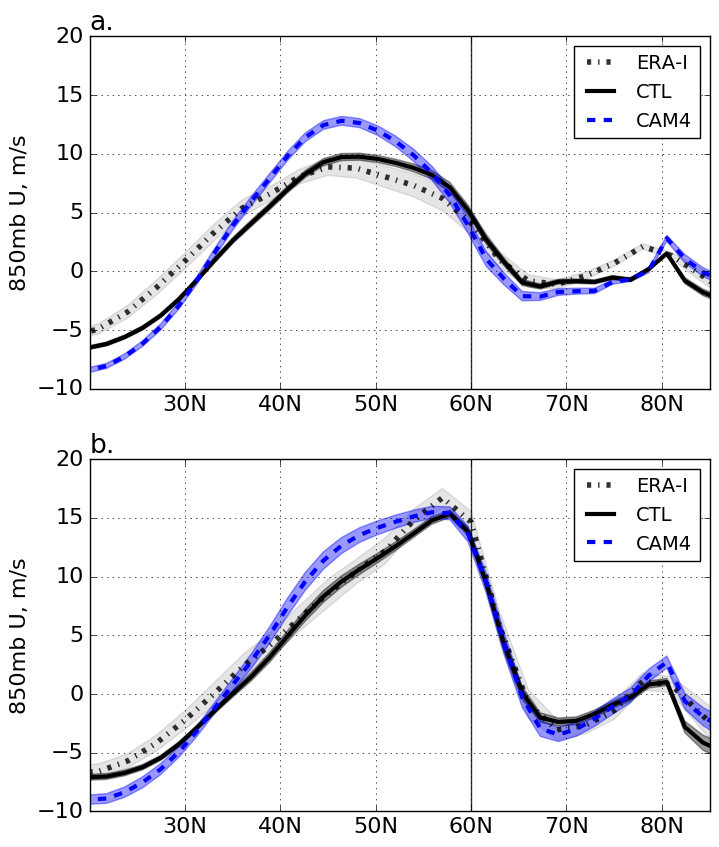

In [880]:
## WACCM and CAM comparison: Uthresh = 18
matplotlib.rcParams['figure.figsize']=(8,10)
matplotlib.rcParams.update({'font.size':16})

fig, axes = plt.subplots(nrows=2, ncols=1)

make_figure4(Uthresh=18)

fig.savefig('/home/disk/eos4/rachel/Figures/JetRegimes/U850CS_TJfig_July17.pdf')
plt.show()

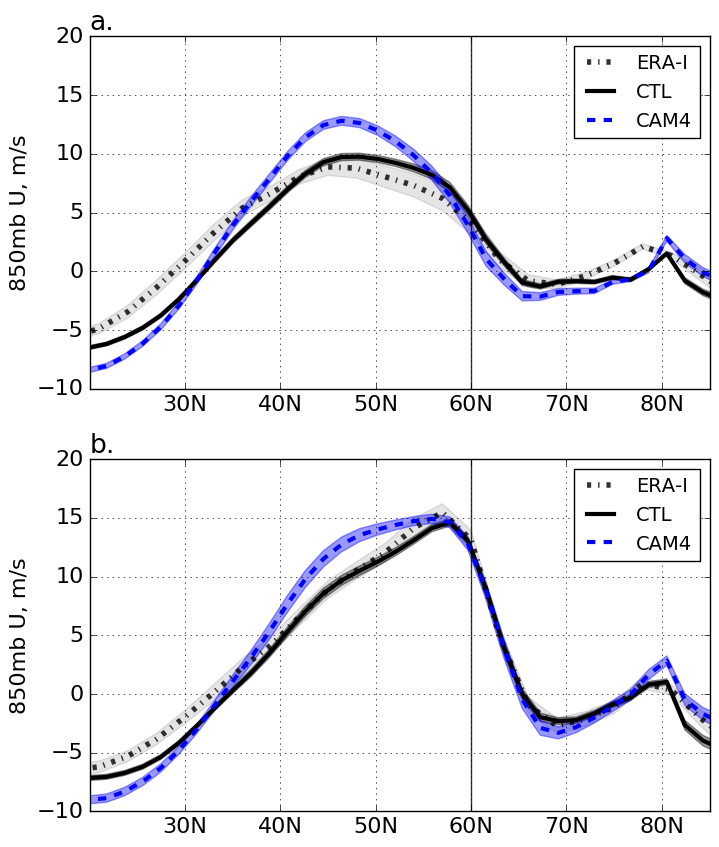

In [974]:
## WACCM and CAM comparison: Uthresh = 16
matplotlib.rcParams['figure.figsize']=(8,10)
matplotlib.rcParams.update({'font.size':16})

fig, axes = plt.subplots(nrows=2, ncols=1)

make_figure4(Uthresh=16)
plt.show()



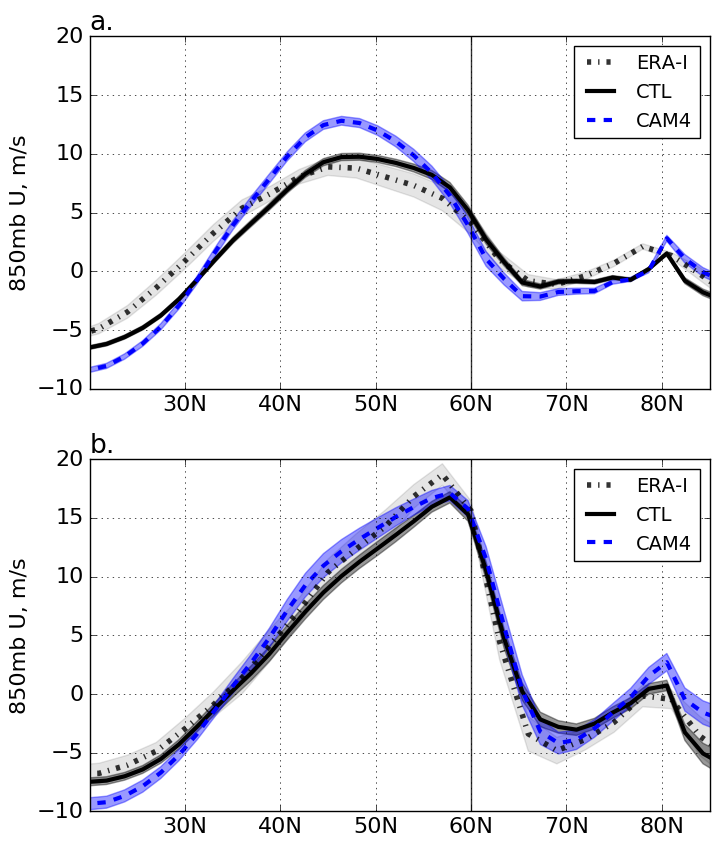

In [975]:
## WACCM and CAM comparison: Uthresh = 22
matplotlib.rcParams['figure.figsize']=(8,10)
matplotlib.rcParams.update({'font.size':16})

fig, axes = plt.subplots(nrows=2, ncols=1)

make_figure4(Uthresh=22)
plt.show()

## SF 1 maps of boundary conditions

In [8]:
# read in data
PHIS_files = {}
Dir = '/home/disk/eos4/rachel/CESM_outfiles/JetRegimes/'

for exp in ['WACCMSC_f19_Flat','WACCMSC_f19_NoG',
            'WACCMSC_f19_ShiftGLND','WACCMSC_f19_NoMT','WACCMSC_f19_NoR']:
    PHIS_files[exp] = xrOpen(Dir + exp + '/atm/hist/DJF2_60_mean_' + exp + '.cam.h0.nc',False)
    
exp = 'WACCMSC_CTL_122'
PHIS_files[exp] = xrOpen(Dir + exp + '/atm/hist/DJF2_100_mean_' + exp + '.cam.h0.nc',False)


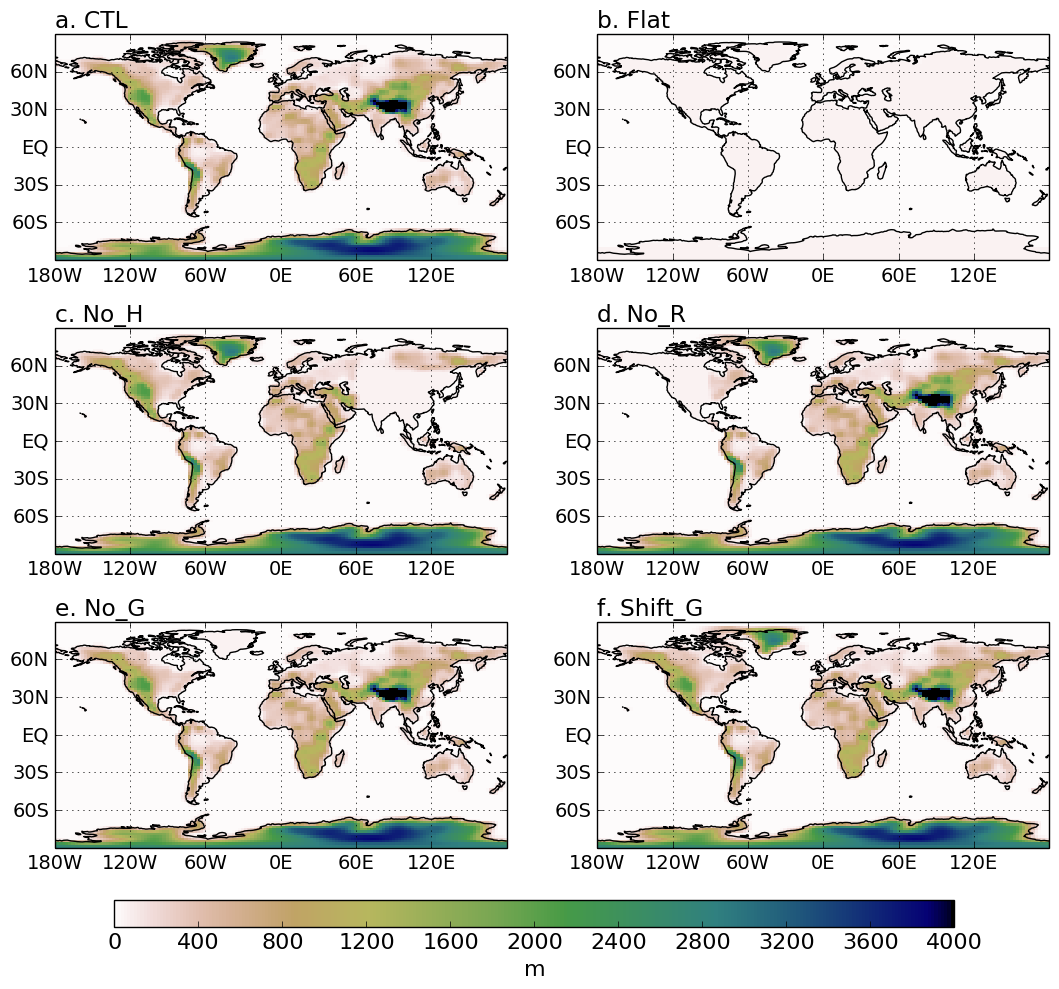

In [80]:
# plot orography
nrows=3
ncols=2
matplotlib.rcParams['figure.figsize']=(7*ncols,3.5*nrows)
matplotlib.rcParams.update({'font.size':14})

labels = ['a. CTL', 'b. Flat','c. No_H','d. No_R','e. No_G','f. Shift_G']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

n=0
for exp in ['WACCMSC_CTL_122','WACCMSC_f19_Flat','WACCMSC_f19_NoMT','WACCMSC_f19_NoR',
            'WACCMSC_f19_NoG', 'WACCMSC_f19_ShiftGLND',]:
    toplot = PHIS_files[exp].PHIS/9.81

    ax = plt.subplot(3,2,n+1,projection=ccrs.PlateCarree())
    # Draw land map
    ax.coastlines(color='k')
    # draw gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.set_xticks([-180,-120,-60,0,60,120],crs=ccrs.PlateCarree())
    ax.set_xticklabels(['180W','120W','60W','0E','60E','120E'])

    ax.set_yticks([-60,-30, 0, 30,60],crs=ccrs.PlateCarree())
    ax.set_yticklabels(['60S','30S', 'EQ', '30N','60N'])
    
    im = toplot.plot(vmin=0,vmax=4000,cmap='gist_earth_r',extend='both',ax=ax,add_colorbar=False)
    plt.title(labels[n],loc='left')
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    #plt.text(215,-110,'m')
    n+=1
    
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.025])
cbar_ax.tick_params(labelsize=16) 
cb = fig.colorbar(im,cax=cbar_ax,orientation='horizontal',drawedges=False)
cb.set_label(label = 'm',fontsize=16)

plt.subplots_adjust(wspace=0.0, hspace=0.3)  
plt.show()
    

## SF 2 Low-pass filter impact

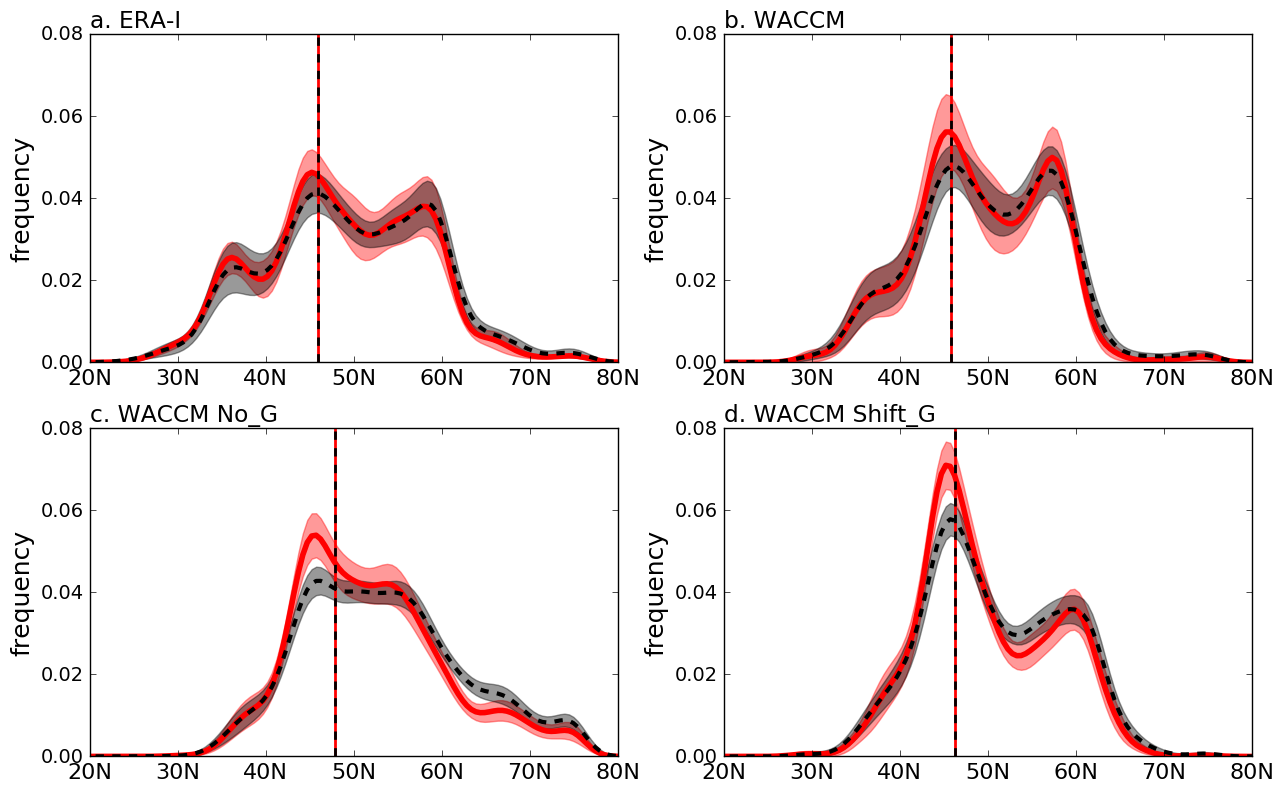

In [73]:
# Plot comparison of LPF and non-LPF
nMC = 1000
nrows =10
matplotlib.rcParams['figure.figsize']=(15,nrows * 5)
matplotlib.rcParams.update({'font.size':14})
n=1
seas='DJF'

ctl = 'erai'
for exp in ['erai']:
    plt.subplot(nrows,2,n); n+=1
    plothist_error_comp(JLI_seas[ctl][seas]['jetlat'],kdeMCstd[seas][nMC][ctl],
                avgDJFU[exp].sel(latitude=slice(80,20)).squeeze(),ctl,
                JLI_LPF_seas[exp][seas]['jetlat'],kdeMCstd_LPF[seas][nMC][exp],
                avgDJFU[exp].sel(latitude=slice(80,20)).squeeze(),exp,
                15,85,0.0,0.08,colorin='r',showlegend=False)
    plt.xticks([20,30,40,50,60,70,80],['20N','30N','40N','50N','60N','70N','80N'],fontsize=16)
    plt.yticks([0.0,0.02,0.04,0.06,0.08])
    plt.xlim(20,80)
    plt.ylabel('frequency',fontsize=18)
    plt.title('a. ERA-I',loc='left')

ctl = 'waccm-varyAll-1980-2010'
for exp in ['waccm-varyAll-1980-2010']:
    plt.subplot(nrows,2,n); n+=1
    plothist_error_comp(JLI_seas[ctl][seas]['jetlat'],kdeMCstd[seas][nMC][ctl],
                avgDJFU[ctl].sel(lat=slice(20,80)),ctl,
                JLI_LPF_seas[exp][seas]['jetlat'],kdeMCstd_LPF[seas][nMC][exp],
                avgDJFU[exp].sel(lat=slice(20,80)),exp,
                15,85,0.0,0.08,colorin='r',showlegend=False)
    plt.xticks([20,30,40,50,60,70,80],['20N','30N','40N','50N','60N','70N','80N'],fontsize=16)
    plt.yticks([0.0,0.02,0.04,0.06,0.08])
    plt.xlim(20,80)
    plt.ylabel('frequency',fontsize=18)
    plt.title('b. WACCM',loc='left')
    
ctl = 'waccm-NoG-extended'
for exp in ['waccm-NoG-extended']:
    plt.subplot(nrows,2,n); n+=1
    plothist_error_comp(JLI_seas[ctl][seas]['jetlat'],kdeMCstd[seas][nMC][ctl],
                avgDJFU[ctl].sel(lat=slice(20,80)),ctl,
                JLI_LPF_seas[exp][seas]['jetlat'],kdeMCstd_LPF[seas][nMC][exp],
                avgDJFU[exp].sel(lat=slice(20,80)),exp,
                15,85,0.0,0.08,colorin='r',showlegend=False)
    plt.xticks([20,30,40,50,60,70,80],['20N','30N','40N','50N','60N','70N','80N'],fontsize=16)
    plt.yticks([0.0,0.02,0.04,0.06,0.08])
    plt.xlim(20,80)
    plt.ylabel('frequency',fontsize=18)
    plt.title('c. WACCM No_G',loc='left')
    
ctl = 'waccm-shiftG-extended'
for exp in ['waccm-shiftG-extended']:
    plt.subplot(nrows,2,n); n+=1
    plothist_error_comp(JLI_seas[ctl][seas]['jetlat'],kdeMCstd[seas][nMC][ctl],
                avgDJFU[ctl].sel(lat=slice(20,80)),ctl,
                JLI_LPF_seas[exp][seas]['jetlat'],kdeMCstd_LPF[seas][nMC][exp],
                avgDJFU[exp].sel(lat=slice(20,80)),exp,
                15,85,0.0,0.08,colorin='r',showlegend=False)
    plt.xticks([20,30,40,50,60,70,80],['20N','30N','40N','50N','60N','70N','80N'],fontsize=16)
    plt.yticks([0.0,0.02,0.04,0.06,0.08])
    plt.xlim(20,80)
    plt.ylabel('frequency',fontsize=18)
    plt.title('d. WACCM Shift_G',loc='left')

## SF3 fig1 with anomalies

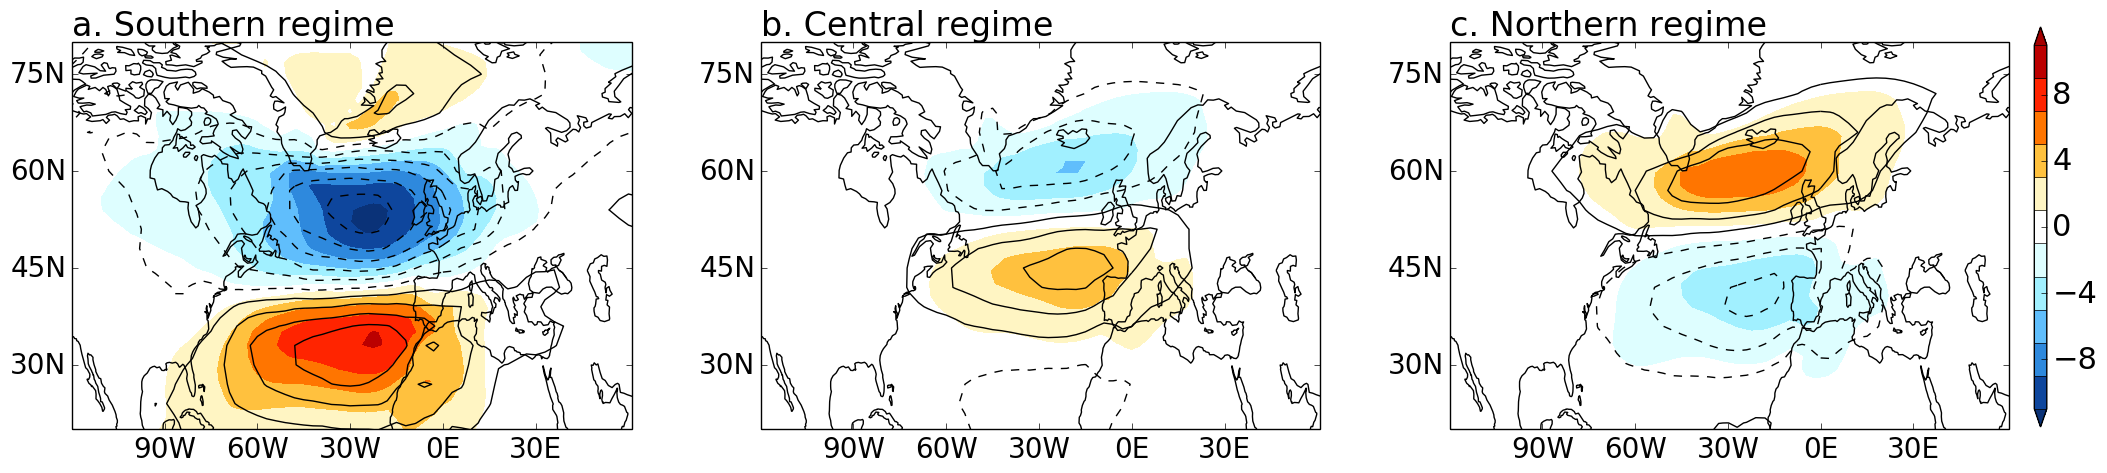

In [249]:
# plot for paper: anomalies 

matplotlib.rcParams['figure.figsize']=(25,5)
matplotlib.rcParams.update({'font.size':20})

n=1

exp = 'waccm-varyAll-1980-2010'
ctl = 'erai'

plev=850
ymin=20
ymax=80
cenlon = 0
iseas='DJF'

cmap='RdBu_r'

fig, axes = plt.subplots(nrows=5, ncols=6)
exp = 'waccm-ctl-extended'
ctl = 'erai'

levels0 = np.arange(-11,11.1,2.0)
levels0E = levels0

levellabels0 = [-8,-4,0,4,8]


ax = plt.subplot2grid((2, 6), (0, 0),rowspan=2, colspan = 2,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

toplotEXP = south_U[exp].U.mean(dim='time').squeeze() - dailyU_seas[exp][iseas].U.mean(dim='time').squeeze().values
toplotEXP = add_lon(toplotEXP,coord='lon')

plt.contourf(toplotEXP.lon,toplotEXP.lat,toplotEXP,
            cmap=cmap_wc,levels=levels0,extend='both',add_colorbar=True)

toplotCTL = south_U[ctl].mean(dim='time').squeeze()- dailyU_seas[ctl][iseas].mean(dim='time').squeeze()
toplotCTL = add_lon(toplotCTL,coord='longitude')

plt.contour(toplotCTL.longitude,toplotCTL.latitude,toplotCTL,
            colors='k',levels=levels0,extend='both',add_colorbar=True)


ax.set_xticks([-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['90W','60W','30W','0E','30E'],fontsize=20)

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'],fontsize=20)

    
plt.title('a. Southern regime',loc='left')
plt.title('')
plt.xlabel('')

plt.ylim(20,80)
plt.xlim(-120,61)


ax = plt.subplot2grid((2, 6), (0, 2),rowspan=2, colspan = 2,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

toplotEXP = mid_U[exp].U.mean(dim='time').squeeze() - dailyU_seas[exp][iseas].U.mean(dim='time').squeeze().values
toplotEXP = add_lon(toplotEXP,coord='lon')

plt.contourf(toplotEXP.lon,toplotEXP.lat,toplotEXP,
            cmap=cmap_wc,levels=levels0,extend='both',add_colorbar=True)


toplotCTL = mid_U[ctl].mean(dim='time').squeeze() - dailyU_seas[ctl][iseas].mean(dim='time').squeeze()
toplotCTL = add_lon(toplotCTL,coord='longitude')

plt.contour(toplotCTL.longitude,toplotCTL.latitude,toplotCTL,
            colors='k',levels=levels0,extend='both',add_colorbar=True)

ax.set_xticks([-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['90W','60W','30W','0E','30E'],fontsize=20)

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'],fontsize=20)

plt.title('b. Central regime',loc='left')
plt.title('')
plt.xlabel('')

plt.ylim(20,80)
plt.xlim(-120,61)



ax = plt.subplot2grid((2, 6), (0, 4),rowspan=2, colspan = 2,projection=ccrs.PlateCarree(central_longitude=cenlon)); n+=1
drawmap_sub(ax)
ax.set_aspect('auto')

toplotEXP = north_U[exp].U.mean(dim='time').squeeze() - dailyU_seas[exp][iseas].U.mean(dim='time').squeeze().values
toplotEXP = add_lon(toplotEXP,coord='lon')

im = plt.contourf(toplotEXP.lon,toplotEXP.lat,toplotEXP,
            cmap=cmap_wc,levels=levels0,extend='both',add_colorbar=True)

toplotCTL = north_U[ctl].mean(dim='time').squeeze() - dailyU_seas[ctl][iseas].mean(dim='time').squeeze()
toplotCTL = add_lon(toplotCTL,coord='longitude')

plt.contour(toplotCTL.longitude,toplotCTL.latitude,toplotCTL,
            colors='k',levels=levels0,extend='both',add_colorbar=True)

ax.set_xticks([-90,-60,-30,0,30],crs=ccrs.PlateCarree())
ax.set_xticklabels(['90W','60W','30W','0E','30E'],fontsize=20)

ax.set_yticks([30,45,60,75],crs=ccrs.PlateCarree())
ax.set_yticklabels(['30N','45N','60N','75N'],fontsize=20)

    
plt.title('c. Northern regime',loc='left')
plt.title('')
plt.xlabel('')

plt.ylim(20,80)
plt.xlim(-120,61)

plt.subplots_adjust(wspace=0.6, hspace=1.5)  

cbar_ax = fig.add_axes([0.91, 0.13, 0.005, 0.8])
cbar_ax.tick_params(labelsize=22) 
fig.colorbar(im,cax=cbar_ax,drawedges=True,orientation='vertical',ticks=levellabels0)

plt.show()



## SF 4 Greenland PS and Z changes

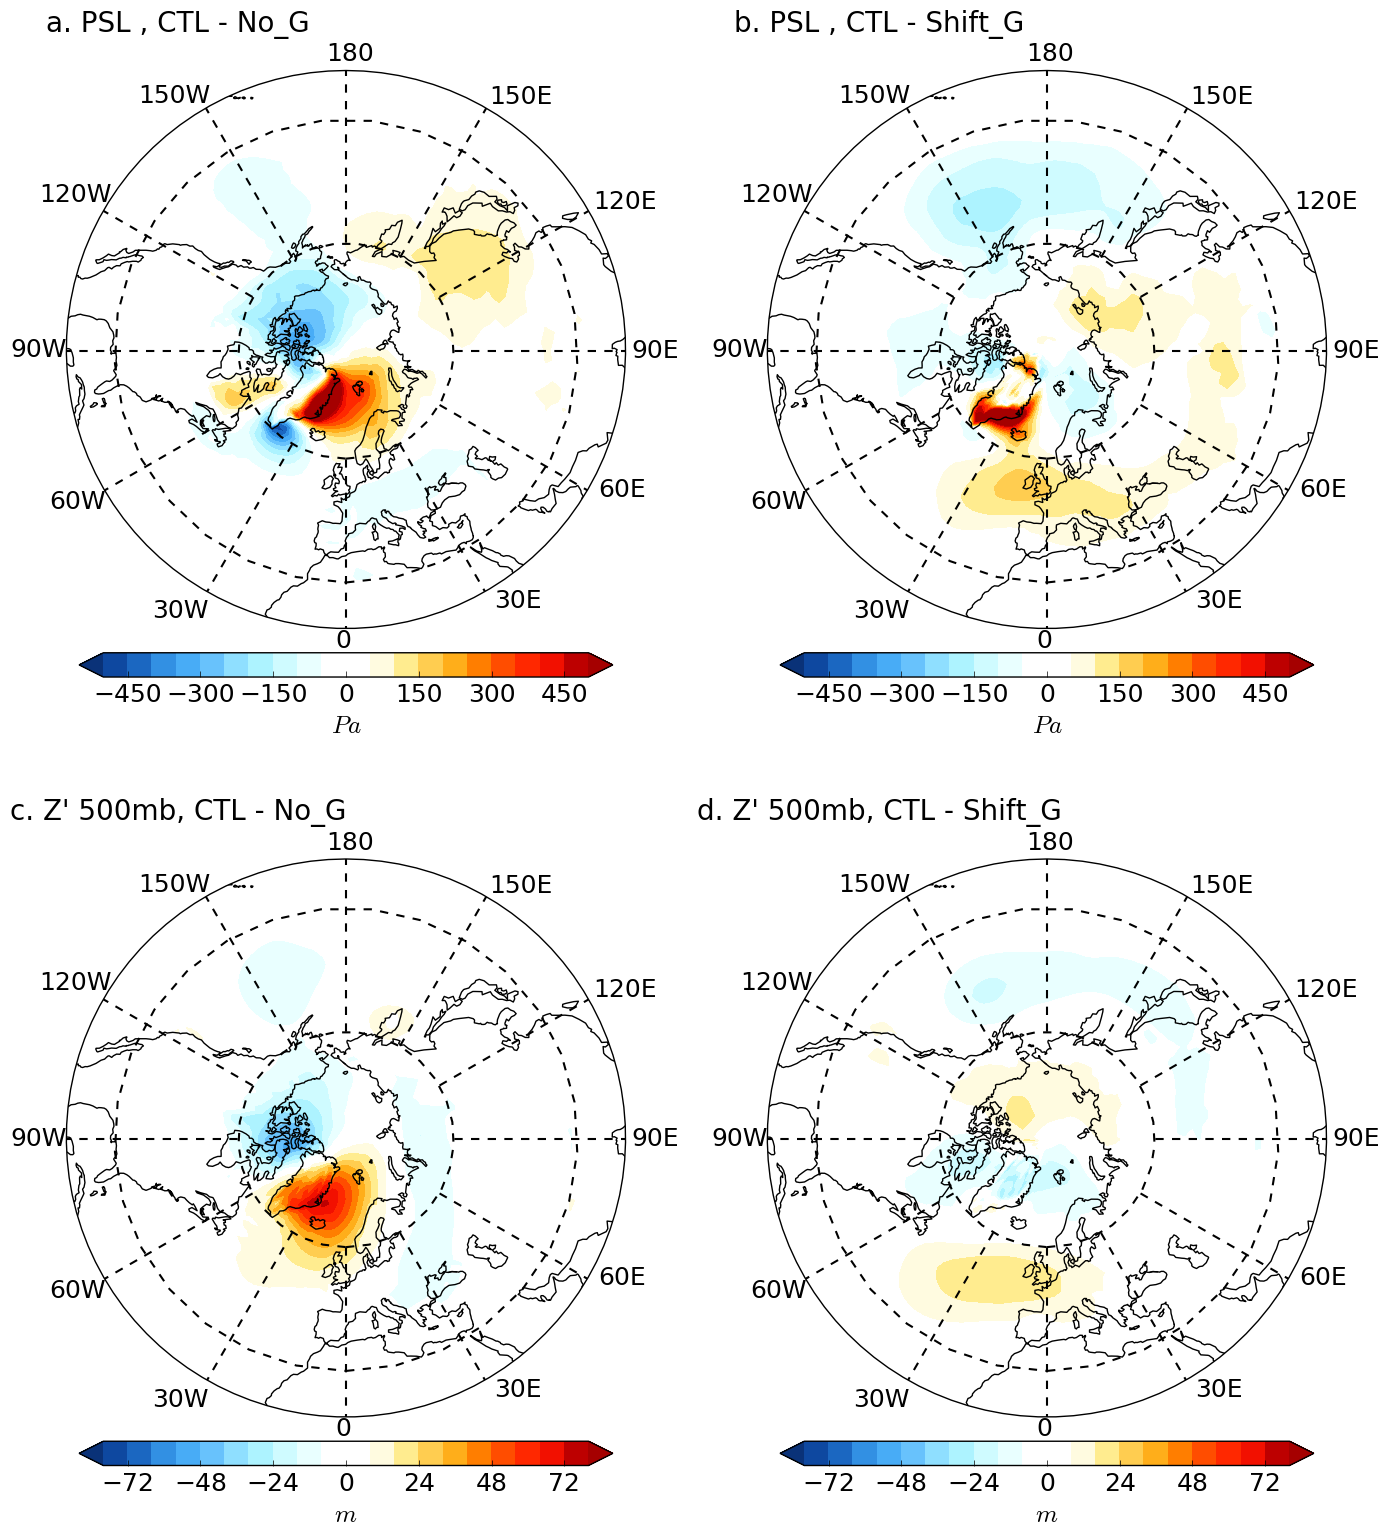

In [244]:
# plot SLP and Z500 differences 

nrows = 2
matplotlib.rcParams['figure.figsize']=(18,nrows*9)
matplotlib.rcParams.update({'font.size':18})
n=1
var='PSL'
plev=-1
cmap='RdBu_r'
vmin=-3.0;vmax=3.0
levels0 = np.arange(100000,103000,100)
nlevels=12
seas = 'DJF'
const = 1.0

fig, axes = plt.subplots(nrows=nrows, ncols=2)
fig.subplots_adjust(wspace=0.01)

levels = np.arange(-500,500.1,50)
plot_map_diffs('waccm-ctl-extended',['waccm-NoG-extended'],['No_G'],
               nrows=nrows,n=n,seas=seas,var=var,levels=levels,cmap=cmap_wc,plev=plev,const=const,
               rZM=False,proj='NPStereo',unit='Pa'); n+=1

levels = np.arange(-500,500.1,50)
plot_map_diffs('waccm-ctl-extended',['waccm-shiftG-extended'],['Shift_G'],
               nrows=nrows,n=n,seas=seas,var=var,levels=levels,cmap=cmap_wc,plev=plev,const=const,
               rZM=False,proj='NPStereo',unit='Pa'); n+=1
var='Z3'
plev=500
levels = np.arange(-80,80.1,8)
plot_map_diffs('waccm-ctl-extended',['waccm-NoG-extended'],['No_G'],
               nrows=nrows,n=n,seas=seas,var=var,levels=levels,cmap=cmap_wc,plev=plev,const=const,
               rZM=True,proj='NPStereo',unit='m'); n+=1

levels = np.arange(-80,80.1,8)
plot_map_diffs('waccm-ctl-extended',['waccm-shiftG-extended'],['Shift_G'],
               nrows=nrows,n=n,seas=seas,var=var,levels=levels,cmap=cmap_wc,plev=plev,const=const,
               rZM=True,proj='NPStereo',unit='m'); n+=1
plt.subplots_adjust(hspace=0.3)
plt.show()

## SF 5 maps of U850 changes

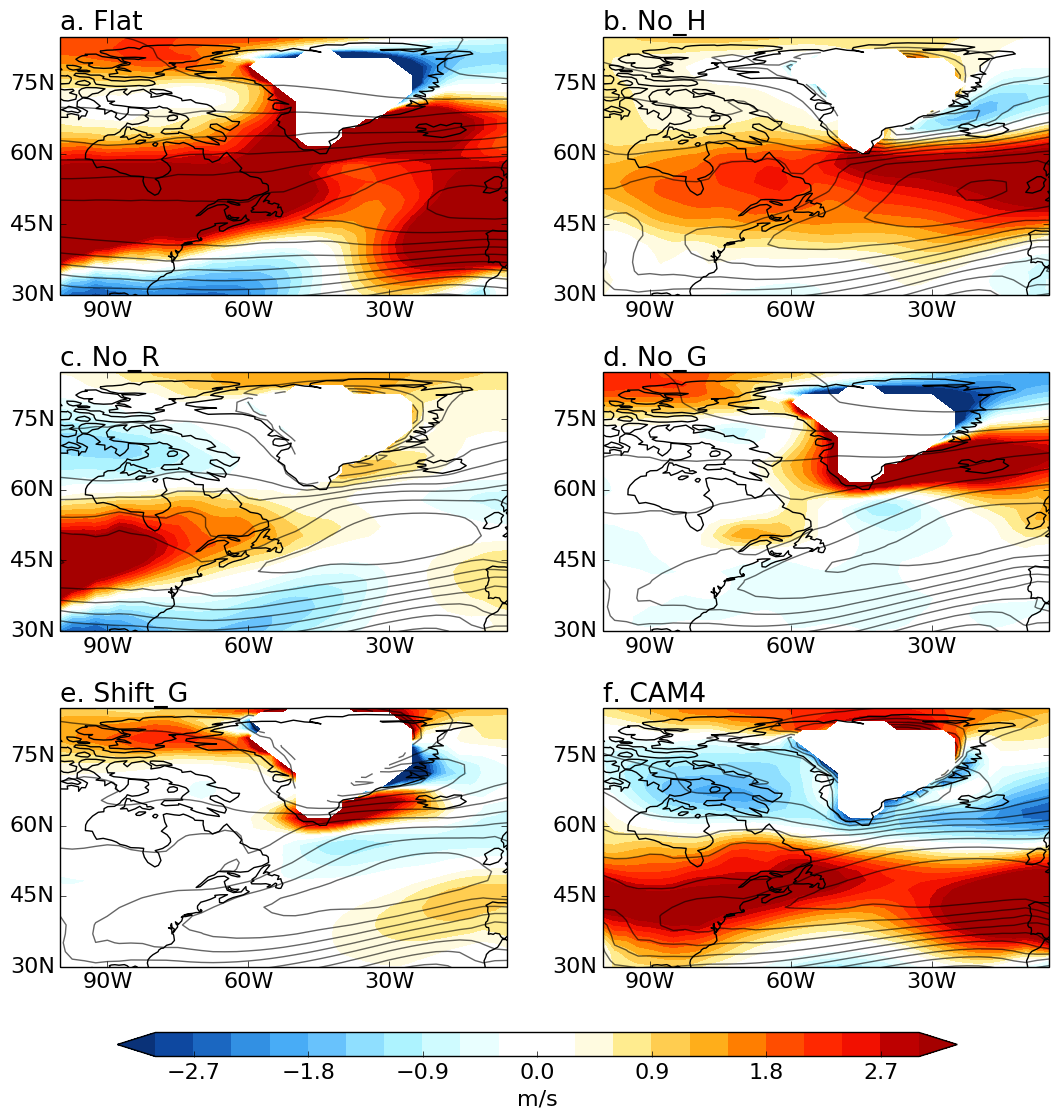

In [77]:
# plot at 850mb
nrows = 3
ncols=2

matplotlib.rcParams['figure.figsize']=(7*ncols,4*nrows)
matplotlib.rcParams.update({'font.size':16})

ctl='waccm-ctl-extended'

plev=850
var='U'
n=1
proj = ccrs.PlateCarree()

labels = ['a. Flat','b. No_H','c. No_R','d. No_G','e. Shift_G','f. CAM4']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

for exp in ['waccm-flat-extended','waccm-NoMT-extended','waccm-NoR-extended','waccm-NoG-extended',
           'waccm-shiftG-extended','cesm-topo']:

    ax = plt.subplot(nrows,ncols,n,projection=proj)
    ax.coastlines()
    ax.set_xticks([-90,-60,-30],crs=ccrs.PlateCarree())
    ax.set_xticklabels(['90W','60W','30W'])

    ax.set_yticks([30,45,60,75,90],crs=ccrs.PlateCarree())
    ax.set_yticklabels(['30N','45N','60N','75N','90N'])

    toplotctl = (atmfields['p' + ctl]['DJF'][var].mean(dim='time').sel(lev_p=plev))
    toplotPSctl = (atmfields[ctl]['DJF']['PS'].mean(dim='time'))

    toplotctl[...] = np.where(toplotPSctl<plev*100,np.nan,toplotctl)
    toplotPS = (atmfields[exp]['DJF']['PS'].mean(dim='time'))

    toplotexp = (atmfields['p' + exp]['DJF'][var].mean(dim='time').sel(lev_p=plev))
    toplotexp[...] = np.where(toplotPS<plev*100,np.nan,toplotexp)

    toplot = (toplotexp - toplotctl)

    im = toplot.plot.contourf(transform=ccrs.PlateCarree(),cmap=cmap_wc,levels = np.arange(-3,3.1,0.3),
                        add_colorbar=False)
    toplotexp.plot.contour(transform=ccrs.PlateCarree(),colors='k',levels = np.arange(-24,24.1,2.0),
                          alpha=0.6)

    plt.title(labels[n-1],loc='left')
    plt.title('')
    plt.xlim(-100,-5)
    plt.ylim(30,85)
    plt.ylabel('')
    plt.xlabel('')
    n+=1
    
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
cbar_ax.tick_params(labelsize=16) 
cb = fig.colorbar(im,cax=cbar_ax,orientation='horizontal',drawedges=False)
cb.set_label(label = 'm/s',fontsize=16)
#cbar_kwargs={'label': '','ticks': [-3,-2,-1,0,1,2,3]},
plt.subplots_adjust(wspace=0.0, hspace=0.3)  

fig.savefig('/home/disk/eos4/rachel/Figures/JetRegimes/Maps850Ufig_July19.pdf')
plt.show()

## SF 6 SSWs

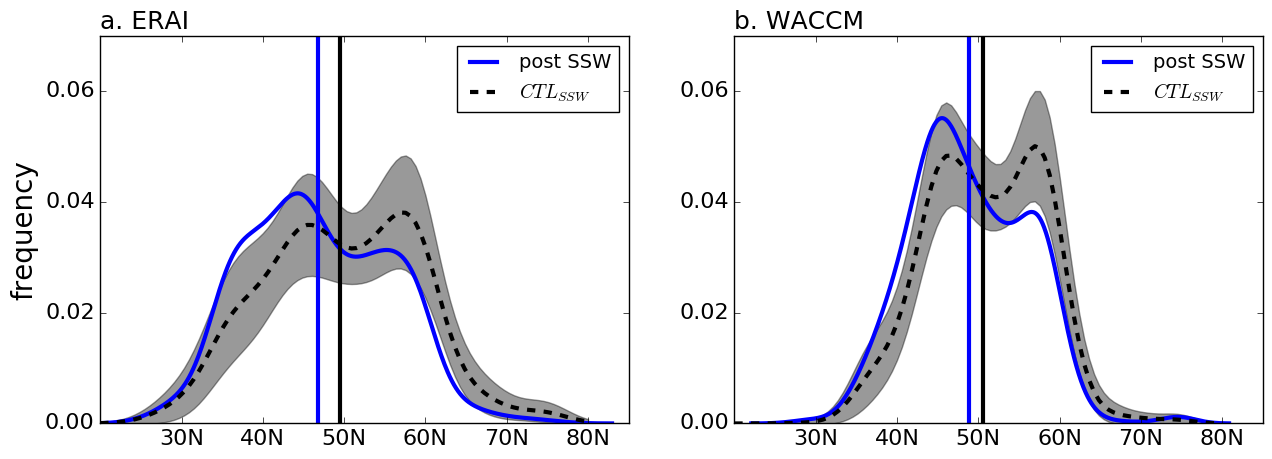

In [978]:
# plot for DJF new colours
nMC = 1000
nrows =1

# nMC = 1000 
matplotlib.rcParams['figure.figsize']=(15,nrows * 5)
matplotlib.rcParams.update({'font.size':16})

fig, axes = plt.subplots(nrows=nrows, ncols=2)

subplottitles = ['a. ERAI','b. WACCM']


n=1
dayspost1 = 10
dayspost2 = 40
exp = 'erai'

m = plotSSWhist_paper(exp,jetdata,JLI_seas,SSW_dates,SSW_dates_fake,'Atl','jetlat',nrows,n,20,80,0,0.07,
             dayspre1=30,dayspre2=10,dayspost1=dayspost1,dayspost2=dayspost2,color='b')
plt.title(subplottitles[n-1],loc='left',fontsize=18)
plt.xticks([20,30,40,50,60,70,80],['','30N','40N','50N','60N','70N','80N'],fontsize=16)
plt.yticks([0.0,0.02,0.04,0.06])
plt.xlim(20,85)
plt.ylabel('frequency',fontsize = 20)
n+=1

exp = 'waccm-ctl-extended'
m = plotSSWhist_paper(exp,jetdata,JLI_seas,SSW_dates,SSW_dates_fake,'Atl','jetlat',nrows,n,20,80,0,0.07,
             dayspre1=30,dayspre2=10,dayspost1=dayspost1,dayspost2=dayspost2,color='b')
plt.title(subplottitles[n-1],loc='left',fontsize=18)
plt.xticks([20,30,40,50,60,70,80],['','30N','40N','50N','60N','70N','80N'],fontsize=16)
plt.yticks([0.0,0.02,0.04,0.06])
plt.xlim(20,85)

fig.savefig('/home/disk/eos4/rachel/Figures/JetRegimes/SSWsfig_July18.pdf')
plt.show()

## SF 7 CMIP biases

In [949]:
# Find maxlat

maxlat = {}

# CMIP
for exp in CMIPexps:
    if avgDJFU[exp].lat[0] > avgDJFU[exp].lat[-1]:
        maxlat[exp] = getmaxlat(avgDJFU[exp].sel(lat=slice(80,30)))
        indata = avgDJFU[exp].sel(lat=slice(80,30))
    else:
        maxlat[exp] = getmaxlat(avgDJFU[exp].sel(lat=slice(30,80)))
        indata = avgDJFU[exp].sel(lat=slice(30,80))

exp = 'erai'
expname = 'erai'
if avgDJFU[exp].latitude[0] > avgDJFU[exp].latitude[-1]:
    maxlat[expname] = getmaxlat(avgDJFU[exp].sel(latitude=slice(80,30)))
    
else:
    maxlat[expname] = getmaxlat(avgDJFU[exp].sel(latitude=slice(30,80)))
    
for exp in ['waccm-ctl-extended','cesm-topo']:
    if avgDJFU[exp].lat[0] > avgDJFU[exp].lat[-1]:
        maxlat[exp] = getmaxlat(avgDJFU[exp].sel(lat=slice(80,30)))
        indata = avgDJFU[exp].sel(lat=slice(80,30))

    else:
        maxlat[exp] = getmaxlat(avgDJFU[exp].sel(lat=slice(30,80)))
        indata = avgDJFU[exp].sel(lat=slice(30,80))
    
# JLI peaks 
JLI_idx = {}
JLI_idx2 = {}

Xexps = ['erai','waccm-ctl-extended','cesm-topo']
    
exps_scatter = np.concatenate([CMIPexps,Xexps],axis=0)

# JLI peaks for CMIP data
for exp in exps_scatter:
    kdemean = sm.nonparametric.KDEUnivariate(JLI_seas[exp]['DJF']['jetlat'])
    kdemean.fit()

    fun = interp1d(kdemean.support, kdemean.density, kind='cubic',bounds_error=False)
    
    xmin = 40; xmax = 50
    x = np.linspace(xmin, xmax, num=40, endpoint=True)
    JLI1 = fun(x)
    max1 = JLI1.max()
    
    xmin = 56; xmax = 66 
    x = np.linspace(xmin, xmax, num=40, endpoint=True)
    JLI2 = fun(x)
    max2 = JLI2.max() 
    
    xmin = 50; xmax = 56
    x = np.linspace(xmin, xmax, num=40, endpoint=True)
    JLI3 = fun(x)
    min1 = JLI3.min() 
        
    ratio1 = max1 - min1
    ratio2 = max2 - min1
    
    JLI_idx2[exp]= np.amin([ratio1,ratio2])
    JLI_idx[exp]= ratio2/ratio1

    
# create scatter arrays
CMIPscatter = np.concatenate([CMIPexps,['cesm-topo','waccm-ctl-extended']],axis=0)

nCMIP = len(CMIPscatter)

Eexps = ['erai']
nERAI = 1

scatter_JLI = np.zeros([nCMIP  + nERAI])
scatter_CLIM = np.zeros([2,nCMIP + nERAI])

count = 0
for iexp in CMIPscatter:
    scatter_JLI[count] = JLI_idx[iexp] - JLI_idx['erai']

    scatter_CLIM[0,count] = maxlat[iexp] - maxlat['erai']
    count +=1


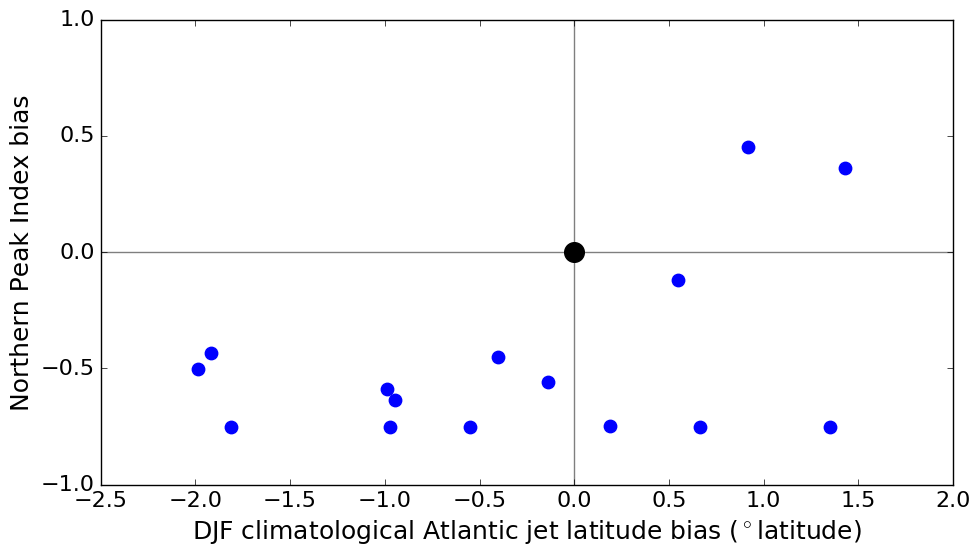

In [989]:
# scatter plot shows jet maximum bias and northern peak index bias
nrows = 1
matplotlib.rcParams['figure.figsize']=(11,6*nrows)
matplotlib.rcParams.update({'font.size':16})

fig, axes = plt.subplots(nrows=nrows, ncols=1)

nexps = nCMIP+1

y = scatter_JLI[0:nexps]
x1 = scatter_CLIM[0,0:nexps]


plt.subplot(nrows,1,1)
plt.scatter(scatter_CLIM[0,0:nCMIP],scatter_JLI[0:nCMIP],color='b',
            s=80,cmap=cmap_wc,vmin=-5,vmax=5)
plt.axhline(color='k',alpha=0.5)
plt.axvline(color='k',alpha=0.5)
plt.scatter(Escatter_CLIM[0,0],Escatter_JLI[0],color='k',
            s=200,cmap=cmap_wc,vmin=-5,vmax=5, edgecolors='k')

plt.xlabel('DJF climatological Atlantic jet latitude bias (' + r'$^\circ$' + 'latitude)',fontsize=18)
plt.ylabel('Northern Peak Index bias',fontsize=18)
#plt.xticks([43,44,45,46,47,48,49,50],['43N','44N','45N','46N','47N','48N','49N','50N'])

plt.ylim(-1,1)
fig.savefig('/home/disk/eos4/rachel/Figures/JetRegimes/CMIPfig_July18.pdf')

plt.show()


## Extra Analysis: Tip jet maps

### WACCM CTL

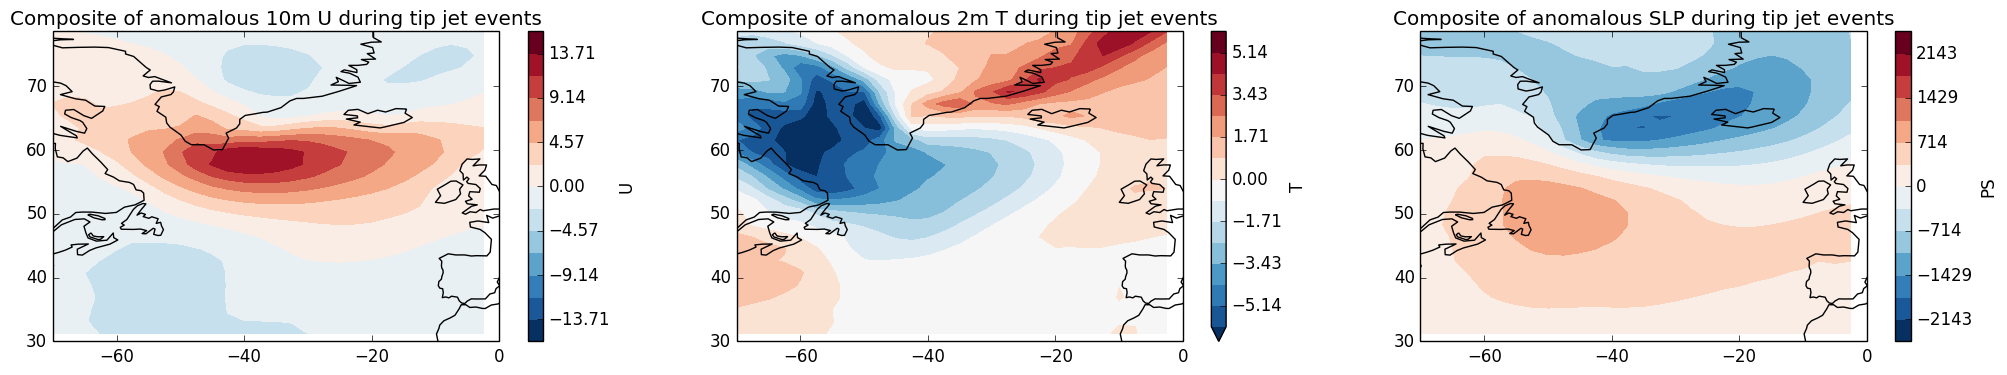

WACCM CTL; U threshold: 18m/s
684 events
Event frequency: 0.127222222222 +/- 0.0156657522717


In [296]:
# Calculate DJF tip jets - using Surface Pressure data
exp = 'CTL'
TJindices[exp] = print_tip_jets(infile[exp],infilePS[exp],'WACCM ' + exp,18)


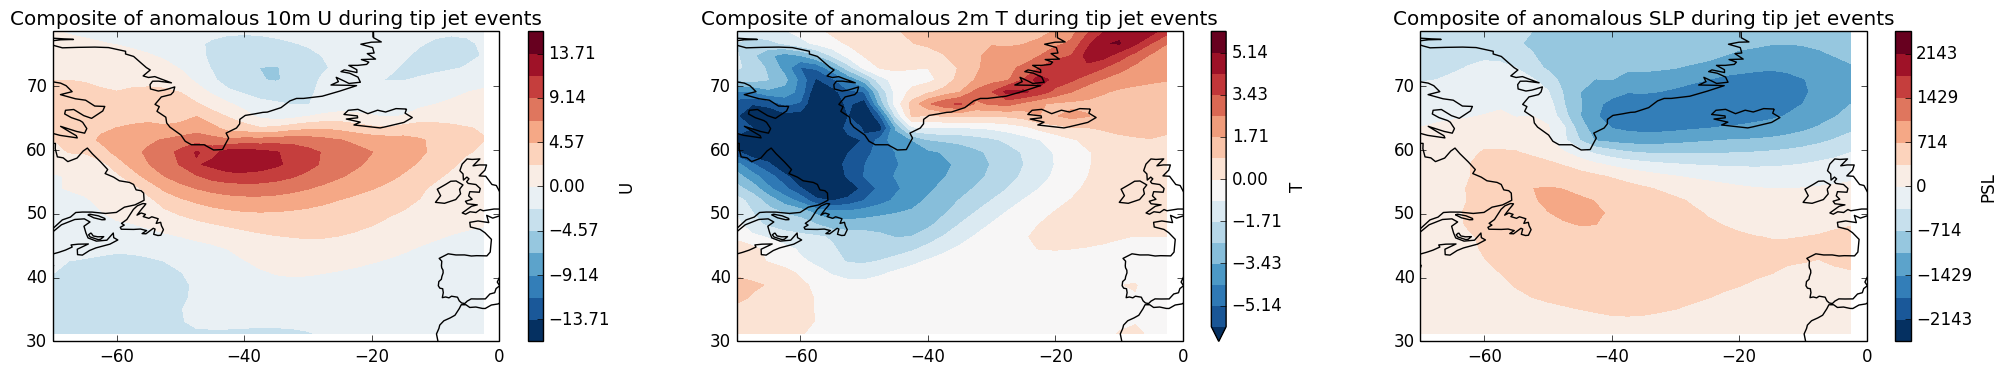

WACCM CTL; U threshold: 18m/s
480 events
Event frequency: 0.0892592592593 +/- 0.0134342067609


In [197]:
# Calculate DJF tip jets - using Sea Level Pressure data
exp = 'CTL'
TJindices[exp] = print_tip_jets(infile[exp],infilePSL[exp],'WACCM ' + exp,18)


### WACCM NoG

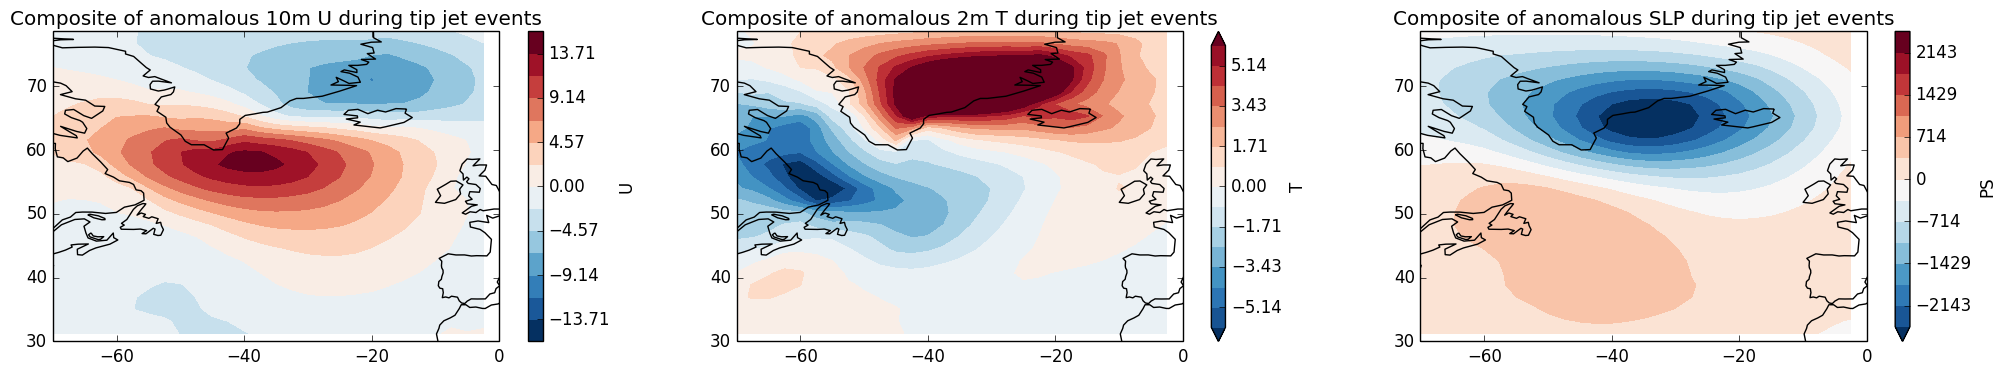

WACCM NoG; U threshold: 18m/s
248 events
Event frequency: 0.0461111111111 +/- 0.00666953703639


In [299]:
# Calculate DJF tip jets
exp = 'NoG'
TJindices[exp] = print_tip_jets(infile[exp],infilePS[exp],'WACCM ' + exp,18)


### WACCM Flat

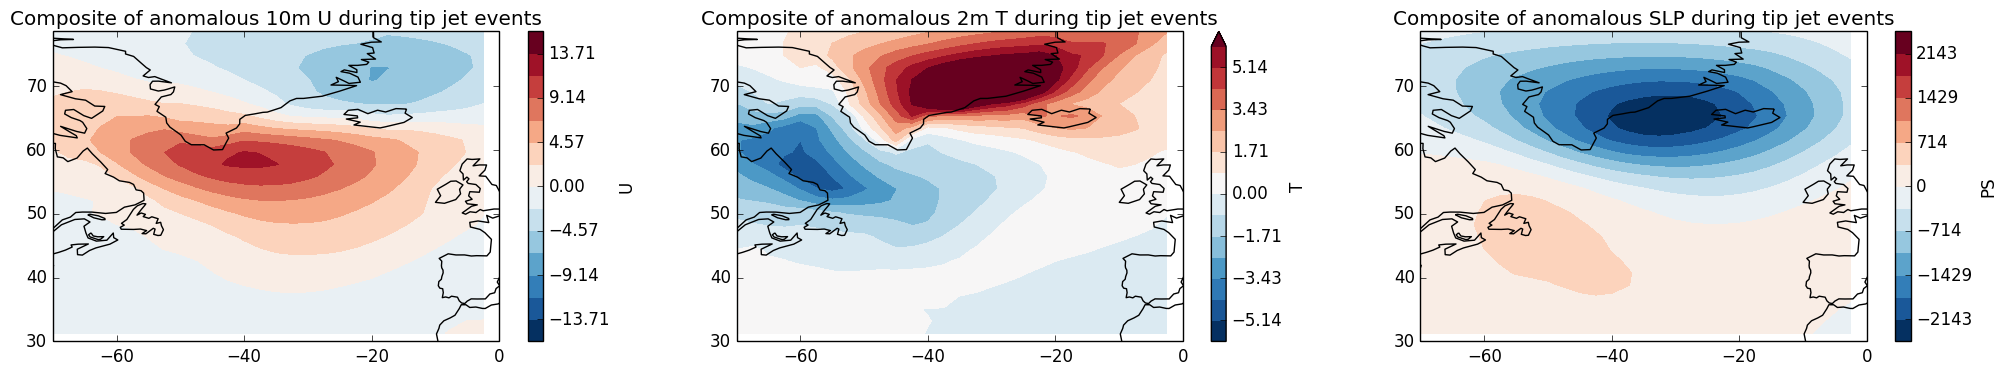

WACCM Flat; U threshold: 18m/s
416 events
Event frequency: 0.0783333333333 +/- 0.00758627325095


In [298]:
# Calculate DJF tip jets
exp = 'Flat'
TJindices[exp] = print_tip_jets(infile[exp],infilePS[exp],'WACCM ' + exp,18)


### Shift GLND

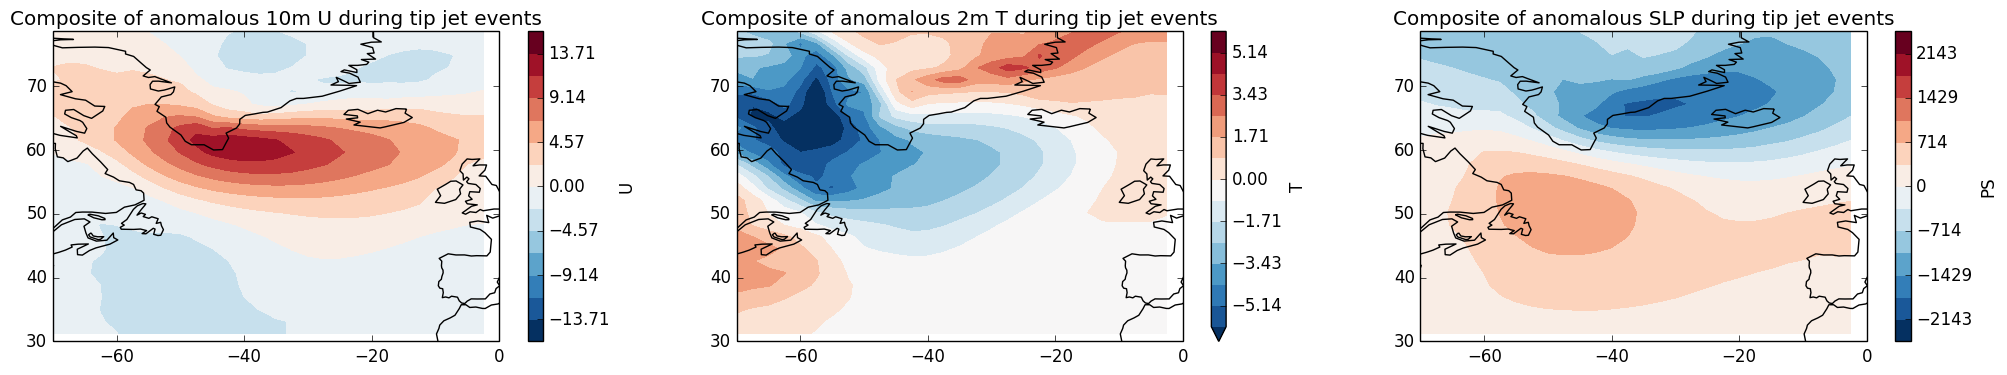

WACCM ShiftGLND; U threshold: 18m/s
645 events
Event frequency: 0.120925925926 +/- 0.0138411410032


In [297]:
# Calculate DJF tip jets
exp = 'ShiftGLND'
TJindices[exp] = print_tip_jets(infile[exp],infilePS[exp],'WACCM ' + exp,18)
